In [14]:
## dataset
#import tensorflow.keras as keras
## for Model definition/training
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow.keras.losses as losses

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

import random
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from numpy.random import RandomState
from itertools import chain
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from skbio.stats.distance import mantel
from os import listdir

In [2]:
def create_base_network(input_shape, embedding_size):
    """
    Base network to be shared (eq. to feature extraction).

    """
    input_vec = Input(shape= input_shape)
    x = Flatten()(input_vec)
    
    encoded = Dense(embedding_size, activation='relu', name = "encoder")(x)
   

    decoded = Dense(input_shape, activation = 'relu', name = "decoder")(encoded)
    
    autoencoder = Model(inputs=input_vec, outputs= decoded)
    
    encoder = Model(inputs = input_vec, outputs = encoded)
    
    encoded_input = Input(shape=(embedding_size,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs = encoded_input, outputs = decoder_layer(encoded_input))
    
    return autoencoder, encoder, decoder

In [3]:
def splitDatasets(data, mapping, state = 0):
    family_ids = mapping.familyID.values
    train, test = train_test_split(list(set(family_ids)), test_size = .4, random_state = state)
    test, val = train_test_split(test, test_size = .5, random_state = state)

    x_train = data.loc[[i in train for i in family_ids], :]
    x_val = data.loc[[i in val for i in family_ids], :]
    x_test = data.loc[[i in test for i in family_ids], :]

    print((x_train.shape[0] + x_val.shape[0] + x_test.shape[0]) == data.shape[0])

    y_train_tmp = mapping.loc[x_train.index.values, 'phenotype'].values
    y_train = [1 if i == "A" else 0 for i in y_train_tmp]

    y_val_tmp = mapping.loc[x_val.index.values, 'phenotype'].values
    y_val = [1 if i == "A" else 0 for i in y_val_tmp]

    y_test_tmp = mapping.loc[x_test.index.values, 'phenotype'].values
    y_test = [1 if i == "A" else 0 for i in y_test_tmp]

    print("Train size: " + str(x_train.shape))
    print("Train size: " + str(x_val.shape))
    print("Train size: " + str(x_test.shape))
    
    return(x_train, x_val, x_test)

In [4]:
def get16sData():
    s_tab = pd.read_csv("C:/Users/ctata/Documents/Lab/multiomics/data/16s/asv_table_nooutliers.txt", sep = "\t")
    s_map = pd.read_csv("C:/Users/ctata/Documents/Lab/multiomics/data/16s/mapping_nooutliers.txt", sep = "\t")
    s_tab = s_tab.T
    s_map.head()

    
    return(s_tab, s_map)

def getMtgData():
    mtg_tab = pd.read_csv("C:/Users/ctata/Documents/Lab/multiomics/data/mtg/asv_table_nooutliers.txt", sep = "\t")
    mtg_map = pd.read_csv("C:/Users/ctata/Documents/Lab/multiomics/data/mtg/mapping_nooutliers.txt", sep = "\t")
    mtg_tab = mtg_tab.T
    mtg_map.head()
    return(mtg_tab, mtg_map)

def getMttData():
    mtt_tab = pd.read_csv("C:/Users/ctata/Documents/Lab/multiomics/data/mtt/asv_table_nooutliers.txt", sep = "\t")
    mtt_map = pd.read_csv("C:/Users/ctata/Documents/Lab/multiomics/data/mtt/mapping_nooutliers.txt", sep = "\t")
    mtt_tab = mtt_tab.T
    mtt_map.head()
    print(mtt_map.shape)
    

    return(mtt_tab, mtt_map)

def brayCurtisLoss(y_true, y_pred):
    return(K.abs(K.sum(y_true - y_pred)) / K.sum(y_true + y_pred))

def encode(data, model_file):
    input_shape = data.shape[1]
    model = load_model(model_file, compile = False)
    model.compile(loss = brayCurtisLoss)
    input_vec = Input(shape= input_shape)
    x = Flatten()(input_vec)
    encoded = model.get_layer('encoder')(x)
    encoder = Model(inputs = input_vec, outputs = encoded)
    encoded = pd.DataFrame(encoder.predict(data), index = data.index)
    return(encoded)

def getEmbedded16s():
    s_tab = pd.read_csv("C:/Users/ctata/Documents/Lab/multiomics/data/16s/embedded_agp.txt", sep = "\t")
    s_map = pd.read_csv("C:/Users/ctata/Documents/Lab/multiomics/data/16s/mapping_nooutliers.txt", sep = "\t")
    x_train, x_test = splitDatasets(s_tab, s_map)
    map_train = s_map.loc[x_train.index.values, :]
    #map_val = s_map.loc[x_val.index.values, :]
    map_test = s_map.loc[x_test.index.values, :]
    return(x_train, x_test, map_train,  map_test )

def getMapping(data, mapping):
    mapping = pd.DataFrame()
    for i in data.index.values:
        mapping = mapping.append(mapping.loc[mapping.host_name == i, :], ignore_index = True)
    mapping = mapping.drop_duplicates(subset='host_name', keep='first')
    mapping.index = mapping.host_name
    return(mapping.loc[data.index.values, :])

def getMetabolData():
    tab = pd.read_csv("C:/Users/ctata/Documents/Lab/multiomics/data/metabol/asv_table_nooutliers.txt", sep = "\t", index_col = 0)
    mapping = pd.read_csv("C:/Users/ctata/Documents/Lab/multiomics/data/metabol/mapping_nooutliers.txt", sep = "\t")
    tab = tab.iloc[:, 1:]
    tab = tab.T
    return(tab, mapping)

def filterForProkaryotes(mbx_tab):
    metabolites_not_in_db = pd.read_csv('../../data/metabol/metabolites_not_in_database.csv', index_col = 0)
    metabolites_in_db_directly = mbx_tab.columns.values[[i not in metabolites_not_in_db.index.values for i in mbx_tab.columns.values]]
    keep1 = metabolites_not_in_db.IN_MICROBIAL_DATABASE != 'FALSE'
    keep3 = metabolites_not_in_db.IN_MICROBIAL_DATABASE != 'FALSE; not in pubchem'
    keep4 = metabolites_not_in_db.IN_MICROBIAL_DATABASE != 'FALSE, not in pubchem'
    keep2 = [i == i for i in metabolites_not_in_db.IN_MICROBIAL_DATABASE] #check for NaN
    keep = [i and j and k and l for i,j,k,l in zip(keep1.values, keep2, keep3.values, keep4.values)]
    metabolites_in_db_indirectly = metabolites_not_in_db.loc[keep, :].index.values
    metabolites_keep = np.concatenate((metabolites_in_db_directly, metabolites_in_db_indirectly))
    return(mbx_tab[metabolites_keep])


In [5]:
s_tab, s_map = get16sData()
x_train, x_val, x_test = splitDatasets(s_tab, s_map)

True
Train size: (267, 5265)
Train size: (96, 5265)
Train size: (87, 5265)


In [118]:
mtg_tab, mtg_map = getMtgData()
x_train, x_val, x_test = splitDatasets(mtg_tab, mtg_map)

True
Train size: (116, 6189)
Train size: (39, 6189)
Train size: (38, 6189)


In [119]:
mtt_tab, mtt_map = getMttData()
x_train, x_val, x_test = splitDatasets(mtt_tab, mtt_map)

(177, 56)
True
Train size: (106, 7127)
Train size: (36, 7127)
Train size: (35, 7127)


In [120]:
mbx_tab, mbx_map = getMetabolData()
x_train, x_val, x_test = splitDatasets(mbx_tab, mbx_map)

True
Train size: (103, 1267)
Train size: (36, 1267)
Train size: (36, 1267)


In [6]:
def brayCurtisLoss(y_true, y_pred):
    return(K.abs(K.sum(y_true - y_pred)) / K.sum(y_true + y_pred))

In [7]:
def lamb(y):
    return(K.sum(K.square(y), axis = 1) / K.square(K.sum(y, axis = 1)))
def hornLoss(y_true, y_pred):
    print("Y shape" + str(y_true.shape))
    return(1 - 2*K.dot(y_true, K.transpose(y_pred)) / ((lamb(y_true) + lamb(y_pred)) *K.sum(y_true, axis = 1) * K.sum(y_pred, axis = 1)))
    #return(1 - 2* K.dot(y_true, y_pred) / ((lamb(y_true) + lamb(y_pred)) *K.sum(y_true) * K.sum(y_pred)))

In [47]:
def lamb_morisita(y):
    loss = K.dot(y, (K.transpose(y)-1)) / ( K.sum(y)* (K.sum(y)- 1) )
    #print(loss)
    return(loss)
    
def morisitaLoss(y_true, y_pred):
    #y_true = tf.math.round(y_true)
    #y_pred = tf.math.round(y_pred + 1)
    print("Y shape" + str(y_true.shape))
    return(1 - K.dot(y_true, K.transpose(y_pred)) / ((lamb_morisita(y_true) + lamb_morisita(y_pred)) *K.sum(y_true, axis = 1) * K.sum(y_pred, axis = 1)))

losses.custom_loss = morisitaLoss


## do samples maintain their distances?

## Check autoencoding success

In [48]:
omic = '16s'
dim = '100'
x_train = pd.read_csv("data/" + omic + "/x_train.csv", index_col = 0)
x_val = pd.read_csv("data/" + omic + "/x_val.csv", index_col = 0)
x_test = pd.read_csv("data/" + omic + "/x_test.csv", index_col = 0)
print(x_train.shape)

autoencoder, encoder, decoder = create_base_network(x_train.shape[1], int(dim))

(267, 5265)


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 5265)]            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5265)              0         
_________________________________________________________________
encoder (Dense)              (None, 100)               526600    
_________________________________________________________________
decoder (Dense)              (None, 5265)              531765    
Total params: 1,058,365
Trainable params: 1,058,365
Non-trainable params: 0
_________________________________________________________________
Y shape(None, None)
Train on 267 samples, validate on 96 samples
Epoch 1/500
Y shape(267, 5265)
Y shape(267, 5265)
Y shape(None, 5265)
267/267 [==============================] - 1s 4ms/sample - loss: 360.8574 - val_loss: 150.1429
Epoch 2/500
267/


Epoch 00060: val_loss did not improve from -6246.80322
267/267 [==============================] - 0s 371us/sample - loss: 59.4266 - val_loss: 373.1232
Epoch 61/500
267/267 [==============================] - 0s 318us/sample - loss: 57.5645 - val_loss: -178.3763
Epoch 62/500
267/267 [==============================] - 0s 352us/sample - loss: 55.7708 - val_loss: 179.3666
Epoch 63/500
267/267 [==============================] - 0s 311us/sample - loss: 54.0566 - val_loss: -1422.2026
Epoch 64/500
267/267 [==============================] - 0s 352us/sample - loss: 52.4082 - val_loss: -4279.4600
Epoch 65/500
267/267 [==============================] - 0s 352us/sample - loss: 50.7956 - val_loss: 3761.1177
Epoch 66/500
267/267 [==============================] - 0s 326us/sample - loss: 49.2382 - val_loss: -762.1989
Epoch 67/500
267/267 [==============================] - 0s 348us/sample - loss: 47.7538 - val_loss: 3522.6433
Epoch 68/500
267/267 [==============================] - 0s 423us/sample - los

Epoch 131/500
267/267 [==============================] - 0s 315us/sample - loss: 9.5088 - val_loss: 23867.8203
Epoch 132/500
267/267 [==============================] - 0s 341us/sample - loss: 9.3207 - val_loss: -4537.1709
Epoch 133/500
267/267 [==============================] - 0s 315us/sample - loss: 9.1363 - val_loss: -79687.2344
Epoch 134/500
267/267 [==============================] - 0s 352us/sample - loss: 8.9549 - val_loss: 2546.6011
Epoch 135/500
267/267 [==============================] - 0s 345us/sample - loss: 8.7748 - val_loss: 1275.0228
Epoch 136/500
267/267 [==============================] - 0s 333us/sample - loss: 8.5951 - val_loss: 3897.9988
Epoch 137/500
267/267 [==============================] - 0s 326us/sample - loss: 8.4139 - val_loss: 540.2194
Epoch 138/500
267/267 [==============================] - 0s 378us/sample - loss: 8.2290 - val_loss: 3629.8069
Epoch 139/500
267/267 [==============================] - 0s 360us/sample - loss: 8.0455 - val_loss: 1097.8357
Epoch 1

Epoch 202/500
267/267 [==============================] - 0s 344us/sample - loss: 1.6870 - val_loss: 1850.2056
Epoch 203/500
267/267 [==============================] - 0s 363us/sample - loss: 1.6564 - val_loss: 1607.7891
Epoch 204/500
267/267 [==============================] - 0s 345us/sample - loss: 1.6271 - val_loss: -8354.3271
Epoch 205/500
267/267 [==============================] - 0s 348us/sample - loss: 1.5990 - val_loss: 5960.5244
Epoch 206/500
267/267 [==============================] - 0s 330us/sample - loss: 1.5725 - val_loss: -16681.3867
Epoch 207/500
267/267 [==============================] - 0s 345us/sample - loss: 1.5476 - val_loss: 684.3958
Epoch 208/500
267/267 [==============================] - 0s 341us/sample - loss: 1.5243 - val_loss: -675.6911
Epoch 209/500
267/267 [==============================] - 0s 303us/sample - loss: 1.5024 - val_loss: -1241.1869
Epoch 210/500

Epoch 00210: val_loss did not improve from -6246.80322
267/267 [==============================] - 0s 3

Epoch 272/500
267/267 [==============================] - 0s 345us/sample - loss: 1.1131 - val_loss: -1308.6952
Epoch 273/500
267/267 [==============================] - 0s 352us/sample - loss: 1.1118 - val_loss: 54.7454
Epoch 274/500
267/267 [==============================] - 0s 318us/sample - loss: 1.1106 - val_loss: 3119.9856
Epoch 275/500
267/267 [==============================] - 0s 352us/sample - loss: 1.1095 - val_loss: 5757.7339
Epoch 276/500
267/267 [==============================] - 0s 311us/sample - loss: 1.1084 - val_loss: -474.3478
Epoch 277/500
267/267 [==============================] - 0s 337us/sample - loss: 1.1073 - val_loss: 40262.5117
Epoch 278/500
267/267 [==============================] - 0s 371us/sample - loss: 1.1063 - val_loss: -11869.6504
Epoch 279/500
267/267 [==============================] - 0s 390us/sample - loss: 1.1053 - val_loss: -1462.8947
Epoch 280/500

Epoch 00280: val_loss did not improve from -4670555.50000
267/267 [==============================] - 0

Epoch 343/500
267/267 [==============================] - 0s 333us/sample - loss: 1.0620 - val_loss: 2789.7864
Epoch 344/500
267/267 [==============================] - 0s 322us/sample - loss: 1.0615 - val_loss: 1705.4230
Epoch 345/500
267/267 [==============================] - 0s 345us/sample - loss: 1.0610 - val_loss: 12740.4912
Epoch 346/500
267/267 [==============================] - 0s 315us/sample - loss: 1.0604 - val_loss: 2021.4540
Epoch 347/500
267/267 [==============================] - 0s 393us/sample - loss: 1.0599 - val_loss: -3623.2222
Epoch 348/500
267/267 [==============================] - 0s 345us/sample - loss: 1.0594 - val_loss: -2358.4009
Epoch 349/500
267/267 [==============================] - 0s 345us/sample - loss: 1.0588 - val_loss: -11.2865
Epoch 350/500

Epoch 00350: val_loss did not improve from -4670555.50000
267/267 [==============================] - 0s 360us/sample - loss: 1.0583 - val_loss: -5713.1665
Epoch 351/500
267/267 [==============================] - 0

Epoch 414/500
267/267 [==============================] - 0s 345us/sample - loss: 1.0327 - val_loss: -55555.8867
Epoch 415/500
267/267 [==============================] - 0s 311us/sample - loss: 1.0325 - val_loss: -5241.8887
Epoch 416/500
267/267 [==============================] - 0s 363us/sample - loss: 1.0322 - val_loss: -3881.2314
Epoch 417/500
267/267 [==============================] - 0s 330us/sample - loss: 1.0320 - val_loss: -3730.1445
Epoch 418/500
267/267 [==============================] - 0s 345us/sample - loss: 1.0317 - val_loss: -1524.6510
Epoch 419/500
267/267 [==============================] - 0s 322us/sample - loss: 1.0315 - val_loss: -698.1639
Epoch 420/500

Epoch 00420: val_loss did not improve from -4670555.50000
267/267 [==============================] - 0s 360us/sample - loss: 1.0312 - val_loss: 24.2435
Epoch 421/500
267/267 [==============================] - 0s 363us/sample - loss: 1.0310 - val_loss: 1090.9841
Epoch 422/500
267/267 [==============================] - 

Epoch 485/500
267/267 [==============================] - 0s 318us/sample - loss: 1.0155 - val_loss: 3472.0659
Epoch 486/500
267/267 [==============================] - 0s 345us/sample - loss: 1.0153 - val_loss: -7282.5044
Epoch 487/500
267/267 [==============================] - 0s 307us/sample - loss: 1.0150 - val_loss: -43123.5898
Epoch 488/500
267/267 [==============================] - 0s 348us/sample - loss: 1.0148 - val_loss: -21332.0352
Epoch 489/500
267/267 [==============================] - 0s 337us/sample - loss: 1.0145 - val_loss: -4327.4043
Epoch 490/500

Epoch 00490: val_loss did not improve from -4670555.50000
267/267 [==============================] - 0s 315us/sample - loss: 1.0143 - val_loss: -2721.8169
Epoch 491/500
267/267 [==============================] - 0s 363us/sample - loss: 1.0141 - val_loss: -1884.0968
Epoch 492/500
267/267 [==============================] - 0s 352us/sample - loss: 1.0138 - val_loss: -1274.4312
Epoch 493/500
267/267 [=============================

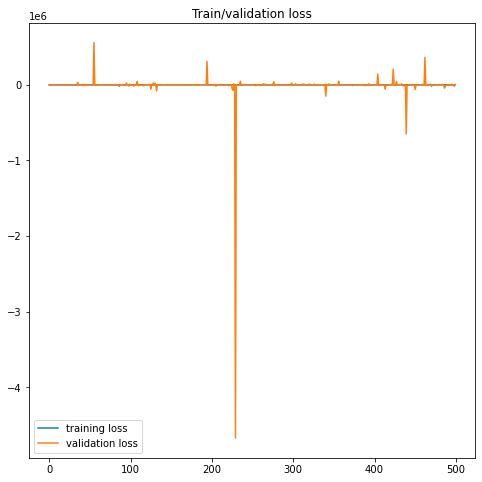

In [50]:
autoencoder.summary()
batch_size = 267
filepath = "weights/autoencoder/" + omic + "/horn/" + dim + "dim/ep{epoch:02d}_train{loss:.3f}_val{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, period= 10)
callbacks_list = [checkpoint]

#autoencoder = load_model("weights/autoencoder/16s/braycurtis/200dim/ep500_train0.136_val0.134.hdf5", compile = False)
autoencoder.compile(optimizer = Adam(.00001), loss = morisitaLoss)
H = autoencoder.fit(np.array(x_train), np.array(x_train),
                validation_data = (np.array(x_val), np.array(x_val)),
                epochs = 500, batch_size = 267, callbacks = callbacks_list)

plt.figure(figsize=(8,8))
plt.plot(H.history['loss'], label='training loss')
plt.plot(H.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Train/validation loss')
plt.show()

#autoencoder.evaluate(np.array(x_train), np.array(x_train))



In [35]:
omic = '16s'
dim = '200'
x_train = pd.read_csv("data/" + omic + "/x_train.csv", index_col = 0)
x_val = pd.read_csv("data/" + omic + "/x_val.csv", index_col = 0)
x_test = pd.read_csv("data/" + omic + "/x_test.csv", index_col = 0)

weight_files = listdir("weights/autoencoder/" + omic + "/braycurtis/" + dim + "dim/")
val_scores = [float(i.split('val')[1][0:5]) for i in weight_files]
file = weight_files[np.argmin(val_scores)]
print(file)

model_file = "weights/autoencoder/" + omic + "/braycurtis/" + dim + "dim/" + file
autoencoder = load_model(model_file, compile = False)
autoencoder.compile(optimizer = Adam(.0000001), loss = brayCurtisLoss)
autoencoder.evaluate(np.array(x_train), np.array(x_train))
#autoencoder.fit(np.array(x_train), np.array(x_train),
#                validation_data = (np.array(x_val), np.array(x_val)),
#                epochs = 90, batch_size = 267)
autoencoder.evaluate(np.array(x_val), np.array(x_val))

ep450_train0.000_val0.001.hdf5
96/96 [==============================] - 0s 635us/sample - loss: 0.0033


0.003297640631596247

In [37]:
encoded = encode(x_train, model_file)

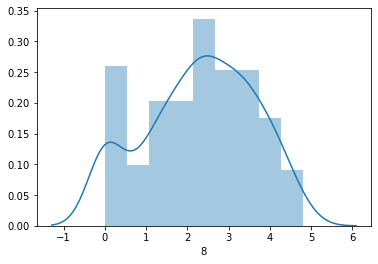

In [54]:
sns.distplot(np.sqrt(encoded.iloc[:, 8] ))

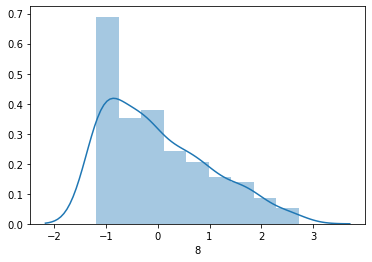

In [52]:
sns.distplot((encoded.iloc[:, 8]  - np.mean(encoded.iloc[:, 8] )) / np.std(encoded.iloc[:, 8]))

(267, 267)
(267, 267)
(267, 267)
(267, 267)
(0.8545946907658524, 0.001, 267)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(0.9004179632567587, 0.001, 96)
(90, 90)
(90, 90)
(90, 90)
(90, 90)
(0.8863596900014395, 0.001, 90)


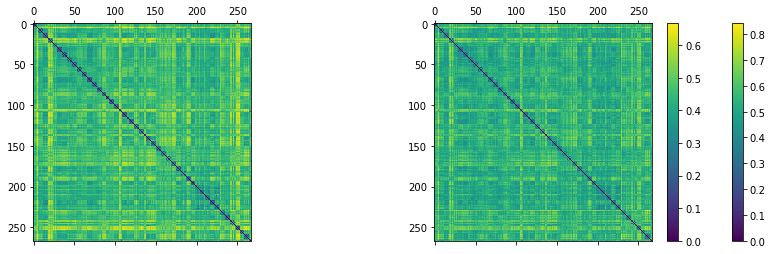

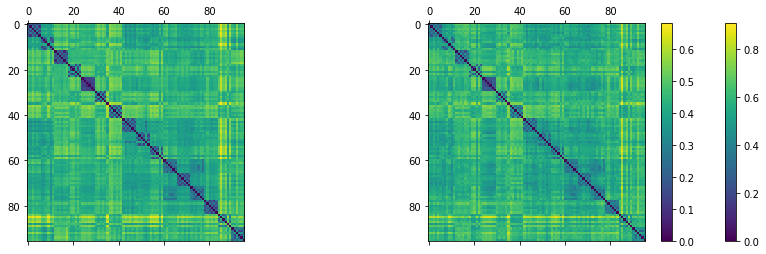

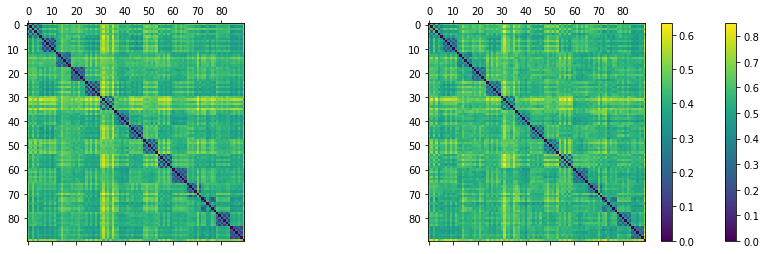

In [36]:
def getCosineSim(A):
    similarity = np.dot(A, A.T)
    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag = np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine = similarity * inv_mag
    cosine = cosine.T * inv_mag
    return(cosine)

    

def getCorrs(use, model_file):
    encoded = encode(use, model_file)
    #corrs = getCosineSim(pred)
    #corrs_base = getCosineSim(np.array(use))
    corrs_base = squareform(pdist(np.array(use), metric = 'braycurtis'))
    corrs_encoded = squareform(pdist(encoded, metric = 'braycurtis'))
    print(corrs_base.shape)
    print(corrs_encoded.shape)
    return(corrs_base,corrs_encoded)

def plotCorrs(corrs_base, corrs_encoded):
    fig = plt.figure(figsize=(15, 4))
    axarr = fig.subplots(1,2)
    p = axarr[0].matshow(corrs_base)
    p2 = axarr[1].matshow(corrs_encoded)
    print(corrs_base.shape)
    print(corrs_encoded.shape)
    print(mantel(corrs_base, corrs_encoded))
    fig.colorbar(p)
    fig.colorbar(p2)
    #Print mantel test metric
    
corrs_base, corrs_encoded = getCorrs(x_train, model_file)
plotCorrs(corrs_base, corrs_encoded)

corrs_base, corrs_encoded = getCorrs(x_val, model_file)
plotCorrs(corrs_base, corrs_encoded)

corrs_base, corrs_encoded = getCorrs(x_test, model_file)
plotCorrs(corrs_base, corrs_encoded)

In [16]:
def encode(data, model_file):
    input_shape = data.shape[1]
    model = load_model(model_file, compile = False)
    
    model.compile(loss = brayCurtisLoss)
    input_vec = Input(shape= input_shape)
    x = Flatten()(input_vec)
    encoded = model.get_layer('encoder')(x)
    encoder = Model(inputs = input_vec, outputs = encoded)
    encoded = pd.DataFrame(encoder.predict(data))
    return(encoded)

In [102]:
model = load_model(model_file, compile = False)
model.compile(loss = brayCurtisLoss)
model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 1720)]            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1720)              0         
_________________________________________________________________
encoder (Dense)              (None, 200)               344200    
_________________________________________________________________
decoder (Dense)              (None, 1720)              345720    
Total params: 689,920
Trainable params: 689,920
Non-trainable params: 0
_________________________________________________________________


(96, 100)


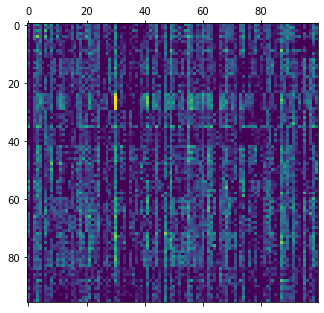

In [113]:
pred = encode(np.array(x_val), model_file)
plt.figure(figsize=(10, 5))
#axarr = fig.subplots(1,2)
#axarr[0].matshow(x_val)
print(pred.shape)
plt.matshow(pred, fignum = 1)

## Dimensions by performance

In [17]:
omic = 'metabol'
dims = ['10', '25', '50', '100', '200']
best_val_scores = []
train_errs = []
val_errs = []
test_errs = []
x_train = pd.read_csv("data/" + omic + "/x_train.csv", index_col = 0)
x_val = pd.read_csv("data/" + omic + "/x_val.csv", index_col = 0)
x_test = pd.read_csv("data/" + omic + "/x_test.csv", index_col = 0)

for dim in dims:
    
    weight_files = listdir("weights/autoencoder/" + omic + "/braycurtis/" + dim + "dim/")
    
    val_scores = [float(i.split('val')[1][0:5]) for i in weight_files]
    best_val_score = np.min(val_scores)
    file = weight_files[np.argmin(val_scores)]
    print(file)
    model = load_model("weights/autoencoder/" + omic + "/braycurtis/" + dim + "dim/" + file, compile = False)
    model.compile(loss = brayCurtisLoss)
    
    corrs_raw, corrs_encoded = getCorrs(x_train, model)
    train_correspondence = mantel(corrs_raw, corrs_encoded)[0]
    corrs_raw, corrs_encoded = getCorrs(x_val, model)
    val_correspondence = mantel(corrs_raw, corrs_encoded)[0]
    corrs_raw, corrs_encoded = getCorrs(x_test, model)
    test_correspondence = mantel(corrs_raw, corrs_encoded)[0]
    
    train_errs = train_errs + [train_correspondence]
    val_errs = val_errs + [val_correspondence]
    test_errs = test_errs + [test_correspondence]
    #train_errs = train_errs + [model.evaluate(np.array(x_train), np.array(x_train))]
    #val_errs = val_errs + [model.evaluate(np.array(x_val), np.array(x_val))]
    #test_errs = test_errs + [model.evaluate(np.array(x_test), np.array(x_test))]
    #best_val_scores = best_val_scores + [best_val_score]

ep3900_train0.182_val0.449.hdf5
ep100_train0.124_val0.502.hdf5
ep1400_train0.107_val0.001.hdf5
ep100_train0.115_val0.001.hdf5
ep100_train0.000_val0.090.hdf5


[0.9338637078006282, 0.9663490208290825, 0.7851519015826652, 0.7233411245410841, 0.7320103393955031]
[0.9007735938907674, 0.9241704007292262, 0.8359720483500561, 0.7957978491613911, 0.7936807174712786]
[0.9371141808352924, 0.9493542424416453, 0.8617831826032489, 0.7953284572067152, 0.8230734656365724]


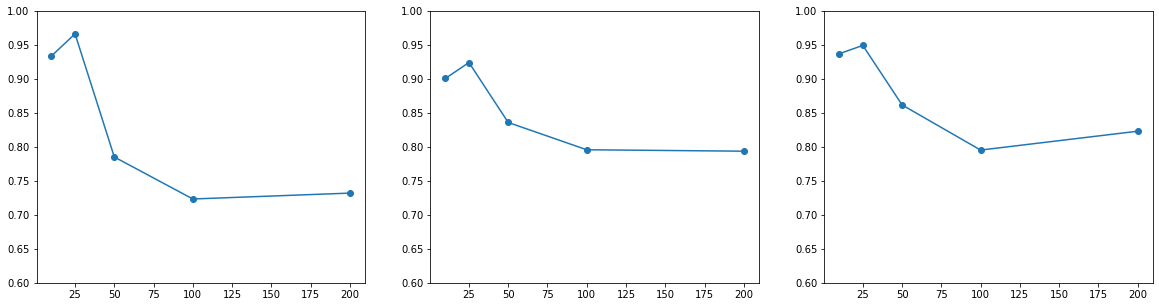

In [18]:
fig = plt.figure(figsize = (20, 5))
axarr = fig.subplots(1,3)
plt.setp(axarr, ylim = (.6, 1))
axarr[0].plot([int(i) for i in dims], train_errs, '-o')
axarr[1].plot([int(i) for i in dims], val_errs, '-o')
axarr[2].plot([int(i) for i in dims], test_errs, '-o')
print(train_errs)
print(val_errs)
print(test_errs)

## Encode samples using the trained model

In [7]:
x_train_16s, x_val_16s, x_test_16s, map_train_16s, map_val_16s, map_test_16s = get16sData()
x_train_mtg, x_val_mtg, x_test_mtg, map_train_mtg, map_val_mtg, map_test_mtg = getMtgData()
x_train_mtt, x_val_mtt, x_test_mtt, map_train_mtt, map_val_mtt, map_test_mtt = getMttData()

data_16s = pd.concat([x_train_16s, x_val_16s, x_test_16s], axis = 0)
data_mtg = pd.concat([x_train_mtg, x_val_mtg, x_test_mtg], axis = 0)
data_mtt = pd.concat([x_train_mtt, x_val_mtt, x_test_mtt], axis = 0)

map_16s = pd.concat([map_train_16s, map_val_16s, map_test_16s], axis = 0)
map_mtg = pd.concat([map_train_mtg, map_val_mtg, map_test_mtg], axis = 0)
map_mtt = pd.concat([map_train_mtt, map_val_mtt, map_test_mtt], axis = 0)

(453, 55)
(453, 5265)
(453, 1720)
True
Train size: (267, 1720)
Train size: (96, 1720)
Train size: (90, 1720)
(193, 55)
(193, 5714)
True
Train size: (116, 5714)
Train size: (39, 5714)
Train size: (38, 5714)
(177, 55)
(177, 5499)
True
Train size: (106, 5499)
Train size: (36, 5499)
Train size: (35, 5499)


In [8]:
#load models and encode
def getEncoder(input_shape, model):
    input_vec = Input(shape= input_shape)
    x = Flatten()(input_vec)
    encoded = model.get_layer('dense')(x)
    encoder = Model(inputs = input_vec, outputs = encoded)
    return(encoder)

model_16s = load_model("weights/autoencoder/16s/100dim/ep300_val0.450.hdf5")
encoder_16s = getEncoder(data_16s.shape[1], model_16s)
model_mtg = load_model("weights/autoencoder/mtg/100dim/ep4300_train0.682_val1.296.hdf5")
encoder_mtg = getEncoder(data_mtg.shape[1], model_mtg)
model_mtt = load_model("weights/autoencoder/mtt/100dim/ep5000_train0.896_val1.731.hdf5")
encoder_mtt = getEncoder(data_mtt.shape[1], model_mtt)


encoded_16s = pd.DataFrame(encoder_16s.predict(data_16s), index = data_16s.index)
encoded_mtg = pd.DataFrame(encoder_mtg.predict(data_mtg), index = data_mtg.index)
encoded_mtt = pd.DataFrame(encoder_mtt.predict(data_mtt), index = data_mtt.index)

In [9]:

#One sample per person
data_16s_grouped = encoded_16s.groupby(map_16s.host_name).mean()
data_mtg_grouped = encoded_mtg.groupby(map_mtg.host_name).mean()
data_mtt_grouped = encoded_mtt.groupby(map_mtt.host_name).mean()



In [533]:
#get overlapping samples in each omic set
def getMapping(data):
    mapping = pd.DataFrame()
    for i in data.index.values:
        mapping = mapping.append(map_16s.loc[map_16s.host_name == i, :], ignore_index = True)
    mapping = mapping.drop_duplicates(subset='host_name', keep='first')
    mapping.index = mapping.host_name
    return(mapping.loc[data.index.values, :])

def getEncodedData(data_16s_grouped, data_mtg_grouped, data_mtt_grouped, state = 0):
    samples = set(data_16s_grouped.index.values).intersection(set(data_mtg_grouped.index.values))
    samples = list(set(samples).intersection(set(data_mtt_grouped.index.values)))
    print(len(samples))

    data = pd.concat([data_16s_grouped.loc[samples, :], data_mtg_grouped.loc[samples, :], data_mtt_grouped.loc[samples, :]], axis = 1)
    family_id = [i.split("_")[0] for i in data.index.values]
    phenotype = [i.split("_")[1] for i in data.index.values]
    mapping = pd.DataFrame({"familyID" : family_id, "phenotype": phenotype}, index = data.index)

    train, val, test = splitDatasets(data, mapping, state = state)


    map_train = getMapping(train)
    map_val = getMapping(val)
    map_test = getMapping(test)


    #y_train = np.array([float(i) for i in map_train.fruit_freq])
    #y_val = np.array([float(i) for i in map_val.fruit_freq])
    #y_test = np.array([float(i) for i in map_test.fruit_freq])
    
    #y_train = np.array([1 if i.split("_")[1] == "A" else 0 for i in train.index.values])
    #y_val = np.array([1 if i.split("_")[1] == "A" else 0 for i in val.index.values])
    #y_test = np.array([1 if i.split("_")[1] == "A" else 0 for i in test.index.values])

    import math
    #keep_train = [not math.isnan(i) for i in y_train]
    #keep_val = [not math.isnan(i) for i in y_val]
    #keep_test = [not math.isnan(i) for i in y_test]

    #train = train.loc[keep_train, :]
    #train = train.iloc[:, 0:200]
    #y_train = y_train[keep_train]

    #val = val.loc[keep_val, :]
    #val = val.iloc[:, 0:200]
    #y_val = y_val[keep_val]

    #test = test.loc[keep_test, :]
    #test = test.iloc[:, 0:200]
    #y_test = y_test[keep_test]

    return(train, val, test, map_train, map_val, map_test)


In [177]:
print(map_train.shape)
print(train.shape)
print(len(keep_train))

(81, 55)
(81, 300)
81


In [187]:
from tensorflow.keras import regularizers
def create_predictive_network(embedding_size):
    size1 = 20
    size2 = 10
    dropout = 0.1
    reg = .06
    input_layer = Input(shape= embedding_size * 2)
    x = Flatten()(input_layer)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l1(reg))(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l2(reg))(x)
    x = Dropout(dropout)(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l1(reg))(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l2(reg))(x)
    x = Dropout(dropout)(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l1(reg))(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l2(reg))(x)
    x = Dropout(dropout)(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l1(reg))(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l2(reg))(x)
    x = Dropout(dropout)(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l1(reg))(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l2(reg))(x)
    x = Dropout(dropout)(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l1(reg))(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l2(reg))(x)
    x = Dropout(dropout)(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l1(reg))(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l2(reg))(x)
    x = Dropout(dropout)(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l1(reg))(x)
    x = Dense(size1, activation = 'relu', kernel_regularizer=regularizers.l2(reg))(x)

    output = Dense(1)(x)
    
    model = Model(inputs = input_layer, outputs = output)
    #print(model.summary())
    return model

In [188]:
embedding_size = 100
model = create_predictive_network(embedding_size)
model.compile(optimizer = Adam(.0001), loss = 'mean_squared_error')

from numpy.random import seed
seed(1)
tf.random.set_seed(1)


Train on 74 samples, validate on 28 samples
Epoch 1/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.6285 - val_loss: 3.6605
Epoch 2/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.6357 - val_loss: 3.6671
Epoch 3/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5664 - val_loss: 3.6750
Epoch 4/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.6267 - val_loss: 3.6829
Epoch 5/15000
74/74 [==============================] - 0s 136us/sample - loss: 1.5869 - val_loss: 3.6878
Epoch 6/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5901 - val_loss: 3.6880
Epoch 7/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.5861 - val_loss: 3.6876
Epoch 8/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.5672 - val_loss: 3.6889
Epoch 9/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.5677 - val_loss: 3.6967
Epoch 10/15

Epoch 77/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.6017 - val_loss: 3.7855
Epoch 78/15000
74/74 [==============================] - 0s 122us/sample - loss: 1.5973 - val_loss: 3.7784
Epoch 79/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.5402 - val_loss: 3.7705
Epoch 80/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.6050 - val_loss: 3.7544
Epoch 81/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.5638 - val_loss: 3.7396
Epoch 82/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5634 - val_loss: 3.7360
Epoch 83/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5796 - val_loss: 3.7322
Epoch 84/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5949 - val_loss: 3.7215
Epoch 85/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.6129 - val_loss: 3.7187
Epoch 86/15000
74/74 [========================

Epoch 154/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.5518 - val_loss: 3.7125
Epoch 155/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.5873 - val_loss: 3.7070
Epoch 156/15000
74/74 [==============================] - 0s 122us/sample - loss: 1.5362 - val_loss: 3.7001
Epoch 157/15000
74/74 [==============================] - 0s 122us/sample - loss: 1.6538 - val_loss: 3.6845
Epoch 158/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.6680 - val_loss: 3.6716
Epoch 159/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.5804 - val_loss: 3.6664
Epoch 160/15000
74/74 [==============================] - 0s 122us/sample - loss: 1.5480 - val_loss: 3.6657
Epoch 161/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.7238 - val_loss: 3.6718
Epoch 162/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5331 - val_loss: 3.6784
Epoch 163/15000
74/74 [==============

Epoch 231/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.5463 - val_loss: 3.7147
Epoch 232/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.5092 - val_loss: 3.7322
Epoch 233/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5466 - val_loss: 3.7446
Epoch 234/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.6099 - val_loss: 3.7449
Epoch 235/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.5434 - val_loss: 3.7354
Epoch 236/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5590 - val_loss: 3.7244
Epoch 237/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.6318 - val_loss: 3.7112
Epoch 238/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5457 - val_loss: 3.7041
Epoch 239/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5651 - val_loss: 3.7021
Epoch 240/15000
74/74 [==============

Epoch 308/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.6016 - val_loss: 3.6789
Epoch 309/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.6117 - val_loss: 3.6742
Epoch 310/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5913 - val_loss: 3.6714
Epoch 311/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.6121 - val_loss: 3.6739
Epoch 312/15000
74/74 [==============================] - 0s 271us/sample - loss: 1.5659 - val_loss: 3.6803
Epoch 313/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.6202 - val_loss: 3.6853
Epoch 314/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5619 - val_loss: 3.6920
Epoch 315/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.6422 - val_loss: 3.6900
Epoch 316/15000
74/74 [==============================] - 0s 297us/sample - loss: 1.5493 - val_loss: 3.6929
Epoch 317/15000
74/74 [==============

Epoch 385/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.5642 - val_loss: 3.7498
Epoch 386/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5502 - val_loss: 3.7489
Epoch 387/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5328 - val_loss: 3.7455
Epoch 388/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.6360 - val_loss: 3.7244
Epoch 389/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5383 - val_loss: 3.7021
Epoch 390/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5859 - val_loss: 3.6807
Epoch 391/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5942 - val_loss: 3.6561
Epoch 392/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5574 - val_loss: 3.6515
Epoch 393/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5345 - val_loss: 3.6582
Epoch 394/15000
74/74 [==============

Epoch 462/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.5239 - val_loss: 3.7226
Epoch 463/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.6261 - val_loss: 3.7168
Epoch 464/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5407 - val_loss: 3.7089
Epoch 465/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.6893 - val_loss: 3.7034
Epoch 466/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5690 - val_loss: 3.6980
Epoch 467/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.5725 - val_loss: 3.7072
Epoch 468/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5363 - val_loss: 3.7186
Epoch 469/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4999 - val_loss: 3.7226
Epoch 470/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5763 - val_loss: 3.7220
Epoch 471/15000
74/74 [==============

Epoch 538/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5502 - val_loss: 3.6504
Epoch 539/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5418 - val_loss: 3.6620
Epoch 540/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.6084 - val_loss: 3.6696
Epoch 541/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.6104 - val_loss: 3.6700
Epoch 542/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.6086 - val_loss: 3.6690
Epoch 543/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.6039 - val_loss: 3.6642
Epoch 544/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5672 - val_loss: 3.6636
Epoch 545/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5457 - val_loss: 3.6661
Epoch 546/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5241 - val_loss: 3.6763
Epoch 547/15000
74/74 [==============

Epoch 615/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5295 - val_loss: 3.7106
Epoch 616/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5864 - val_loss: 3.7098
Epoch 617/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.5323 - val_loss: 3.7154
Epoch 618/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5456 - val_loss: 3.7265
Epoch 619/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5719 - val_loss: 3.7282
Epoch 620/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5418 - val_loss: 3.7283
Epoch 621/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5872 - val_loss: 3.7258
Epoch 622/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5300 - val_loss: 3.7203
Epoch 623/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5422 - val_loss: 3.7135
Epoch 624/15000
74/74 [==============

Epoch 692/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.5791 - val_loss: 3.6473
Epoch 693/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.6848 - val_loss: 3.6640
Epoch 694/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5238 - val_loss: 3.6790
Epoch 695/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.6250 - val_loss: 3.6920
Epoch 696/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5173 - val_loss: 3.7044
Epoch 697/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5198 - val_loss: 3.7150
Epoch 698/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.5230 - val_loss: 3.7247
Epoch 699/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.5645 - val_loss: 3.7338
Epoch 700/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5385 - val_loss: 3.7353
Epoch 701/15000
74/74 [==============

Epoch 769/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5383 - val_loss: 3.7457
Epoch 770/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5210 - val_loss: 3.7604
Epoch 771/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5824 - val_loss: 3.7644
Epoch 772/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5384 - val_loss: 3.7628
Epoch 773/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5294 - val_loss: 3.7611
Epoch 774/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5187 - val_loss: 3.7645
Epoch 775/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5512 - val_loss: 3.7674
Epoch 776/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.6834 - val_loss: 3.7550
Epoch 777/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5372 - val_loss: 3.7330
Epoch 778/15000
74/74 [==============

Epoch 846/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5646 - val_loss: 3.7250
Epoch 847/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5791 - val_loss: 3.7336
Epoch 848/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5253 - val_loss: 3.7424
Epoch 849/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5456 - val_loss: 3.7447
Epoch 850/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.5558 - val_loss: 3.7400
Epoch 851/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5465 - val_loss: 3.7283
Epoch 852/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5769 - val_loss: 3.7131
Epoch 853/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5414 - val_loss: 3.6958
Epoch 854/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.6471 - val_loss: 3.6795
Epoch 855/15000
74/74 [==============

Epoch 923/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5098 - val_loss: 3.7087
Epoch 924/15000
74/74 [==============================] - 0s 155us/sample - loss: 1.4979 - val_loss: 3.7176
Epoch 925/15000
74/74 [==============================] - 0s 214us/sample - loss: 1.5224 - val_loss: 3.7238
Epoch 926/15000
74/74 [==============================] - 0s 150us/sample - loss: 1.5271 - val_loss: 3.7384
Epoch 927/15000
74/74 [==============================] - 0s 152us/sample - loss: 1.5507 - val_loss: 3.7483
Epoch 928/15000
74/74 [==============================] - 0s 150us/sample - loss: 1.5626 - val_loss: 3.7511
Epoch 929/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5239 - val_loss: 3.7497
Epoch 930/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5238 - val_loss: 3.7540
Epoch 931/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4972 - val_loss: 3.7647
Epoch 932/15000
74/74 [==============

Epoch 1000/15000

Epoch 01000: val_loss did not improve from 3.66043
74/74 [==============================] - 0s 162us/sample - loss: 1.5692 - val_loss: 3.7037
Epoch 1001/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.6632 - val_loss: 3.6851
Epoch 1002/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5319 - val_loss: 3.6657
Epoch 1003/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5154 - val_loss: 3.6581
Epoch 1004/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.6791 - val_loss: 3.6639
Epoch 1005/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5239 - val_loss: 3.6719
Epoch 1006/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5447 - val_loss: 3.6747
Epoch 1007/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.6197 - val_loss: 3.6750
Epoch 1008/15000
74/74 [==============================] - 0s 229us/sample - loss: 1.

Epoch 1076/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5353 - val_loss: 3.6674
Epoch 1077/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5347 - val_loss: 3.6773
Epoch 1078/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5672 - val_loss: 3.6854
Epoch 1079/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5413 - val_loss: 3.6948
Epoch 1080/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.5409 - val_loss: 3.6989
Epoch 1081/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.6202 - val_loss: 3.7029
Epoch 1082/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5510 - val_loss: 3.7027
Epoch 1083/15000
74/74 [==============================] - 0s 297us/sample - loss: 1.5708 - val_loss: 3.6954
Epoch 1084/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.6065 - val_loss: 3.6820
Epoch 1085/15000
74/74 [====

Epoch 1152/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.7188 - val_loss: 3.6423
Epoch 1153/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5851 - val_loss: 3.6317
Epoch 1154/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5138 - val_loss: 3.6183
Epoch 1155/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5191 - val_loss: 3.6257
Epoch 1156/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5494 - val_loss: 3.6446
Epoch 1157/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5001 - val_loss: 3.6636
Epoch 1158/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5002 - val_loss: 3.6786
Epoch 1159/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5682 - val_loss: 3.6866
Epoch 1160/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5146 - val_loss: 3.6891
Epoch 1161/15000
74/74 [====

Epoch 1228/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5520 - val_loss: 3.6933
Epoch 1229/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5621 - val_loss: 3.6936
Epoch 1230/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5844 - val_loss: 3.6918
Epoch 1231/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5806 - val_loss: 3.6969
Epoch 1232/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.7201 - val_loss: 3.7022
Epoch 1233/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5257 - val_loss: 3.7161
Epoch 1234/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5216 - val_loss: 3.7322
Epoch 1235/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5190 - val_loss: 3.7495
Epoch 1236/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.7688 - val_loss: 3.7603
Epoch 1237/15000
74/74 [====

Epoch 1304/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5292 - val_loss: 3.7205
Epoch 1305/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.5492 - val_loss: 3.7257
Epoch 1306/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5265 - val_loss: 3.7246
Epoch 1307/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5438 - val_loss: 3.7200
Epoch 1308/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.5929 - val_loss: 3.7122
Epoch 1309/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.6590 - val_loss: 3.7003
Epoch 1310/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5138 - val_loss: 3.7017
Epoch 1311/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5637 - val_loss: 3.6965
Epoch 1312/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4956 - val_loss: 3.7009
Epoch 1313/15000
74/74 [====

Epoch 1380/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5422 - val_loss: 3.6582
Epoch 1381/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5188 - val_loss: 3.6697
Epoch 1382/15000
74/74 [==============================] - 0s 256us/sample - loss: 1.5614 - val_loss: 3.6804
Epoch 1383/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5484 - val_loss: 3.6845
Epoch 1384/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5219 - val_loss: 3.6810
Epoch 1385/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5662 - val_loss: 3.6893
Epoch 1386/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5342 - val_loss: 3.6955
Epoch 1387/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5563 - val_loss: 3.7024
Epoch 1388/15000
74/74 [==============================] - 0s 229us/sample - loss: 1.5331 - val_loss: 3.7298
Epoch 1389/15000
74/74 [====

Epoch 1456/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5889 - val_loss: 3.6708
Epoch 1457/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5635 - val_loss: 3.6859
Epoch 1458/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.5856 - val_loss: 3.6937
Epoch 1459/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5252 - val_loss: 3.6987
Epoch 1460/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.5376 - val_loss: 3.6966
Epoch 1461/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5248 - val_loss: 3.6929
Epoch 1462/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5093 - val_loss: 3.6951
Epoch 1463/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5325 - val_loss: 3.6972
Epoch 1464/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5600 - val_loss: 3.6965
Epoch 1465/15000
74/74 [====

Epoch 1532/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5038 - val_loss: 3.6714
Epoch 1533/15000
74/74 [==============================] - 0s 256us/sample - loss: 1.5095 - val_loss: 3.6825
Epoch 1534/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5570 - val_loss: 3.6835
Epoch 1535/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4740 - val_loss: 3.6840
Epoch 1536/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5557 - val_loss: 3.6732
Epoch 1537/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5082 - val_loss: 3.6643
Epoch 1538/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5085 - val_loss: 3.6637
Epoch 1539/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5633 - val_loss: 3.6663
Epoch 1540/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4918 - val_loss: 3.6631
Epoch 1541/15000
74/74 [====

Epoch 1608/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5117 - val_loss: 3.7322
Epoch 1609/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5642 - val_loss: 3.7360
Epoch 1610/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4941 - val_loss: 3.7465
Epoch 1611/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5889 - val_loss: 3.7559
Epoch 1612/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4934 - val_loss: 3.7644
Epoch 1613/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5898 - val_loss: 3.7672
Epoch 1614/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5777 - val_loss: 3.7666
Epoch 1615/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5386 - val_loss: 3.7607
Epoch 1616/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5419 - val_loss: 3.7543
Epoch 1617/15000
74/74 [====

Epoch 1684/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5097 - val_loss: 3.5852
Epoch 1685/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5000 - val_loss: 3.5779
Epoch 1686/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.5441 - val_loss: 3.5765
Epoch 1687/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5491 - val_loss: 3.5728
Epoch 1688/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5639 - val_loss: 3.5727
Epoch 1689/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4783 - val_loss: 3.5794
Epoch 1690/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5231 - val_loss: 3.5854
Epoch 1691/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5054 - val_loss: 3.5930
Epoch 1692/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5390 - val_loss: 3.6032
Epoch 1693/15000
74/74 [====

Epoch 1760/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4900 - val_loss: 3.5953
Epoch 1761/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.6488 - val_loss: 3.6051
Epoch 1762/15000
74/74 [==============================] - 0s 338us/sample - loss: 1.5647 - val_loss: 3.6103
Epoch 1763/15000
74/74 [==============================] - 0s 405us/sample - loss: 1.5116 - val_loss: 3.6108
Epoch 1764/15000
74/74 [==============================] - 0s 378us/sample - loss: 1.5624 - val_loss: 3.6158
Epoch 1765/15000
74/74 [==============================] - 0s 338us/sample - loss: 1.5348 - val_loss: 3.6216
Epoch 1766/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5193 - val_loss: 3.6264
Epoch 1767/15000
74/74 [==============================] - 0s 378us/sample - loss: 1.5147 - val_loss: 3.6292
Epoch 1768/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.5218 - val_loss: 3.6289
Epoch 1769/15000
74/74 [====

Epoch 1836/15000
74/74 [==============================] - 0s 365us/sample - loss: 1.5311 - val_loss: 3.6269
Epoch 1837/15000
74/74 [==============================] - 0s 237us/sample - loss: 1.4886 - val_loss: 3.6268
Epoch 1838/15000
74/74 [==============================] - 0s 245us/sample - loss: 1.5419 - val_loss: 3.6224
Epoch 1839/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5871 - val_loss: 3.6217
Epoch 1840/15000
74/74 [==============================] - 0s 338us/sample - loss: 1.5515 - val_loss: 3.6205
Epoch 1841/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5267 - val_loss: 3.6190
Epoch 1842/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5587 - val_loss: 3.6191
Epoch 1843/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5261 - val_loss: 3.6172
Epoch 1844/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5204 - val_loss: 3.6204
Epoch 1845/15000
74/74 [====

Epoch 1912/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.5265 - val_loss: 3.6560
Epoch 1913/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4987 - val_loss: 3.6570
Epoch 1914/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5434 - val_loss: 3.6559
Epoch 1915/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.5825 - val_loss: 3.6478
Epoch 1916/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5780 - val_loss: 3.6368
Epoch 1917/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5843 - val_loss: 3.6345
Epoch 1918/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4992 - val_loss: 3.6377
Epoch 1919/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.6228 - val_loss: 3.6550
Epoch 1920/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5068 - val_loss: 3.6621
Epoch 1921/15000
74/74 [====

Epoch 1988/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5353 - val_loss: 3.7056
Epoch 1989/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5427 - val_loss: 3.6979
Epoch 1990/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5663 - val_loss: 3.6818
Epoch 1991/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5482 - val_loss: 3.6743
Epoch 1992/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.5102 - val_loss: 3.6704
Epoch 1993/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.5144 - val_loss: 3.6739
Epoch 1994/15000
74/74 [==============================] - 0s 338us/sample - loss: 1.5674 - val_loss: 3.6757
Epoch 1995/15000
74/74 [==============================] - 0s 324us/sample - loss: 1.5364 - val_loss: 3.6763
Epoch 1996/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5239 - val_loss: 3.6858
Epoch 1997/15000
74/74 [====

Epoch 2064/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5604 - val_loss: 3.6719
Epoch 2065/15000
74/74 [==============================] - 0s 229us/sample - loss: 1.5673 - val_loss: 3.6889
Epoch 2066/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5106 - val_loss: 3.7028
Epoch 2067/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.5200 - val_loss: 3.7117
Epoch 2068/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.6865 - val_loss: 3.7112
Epoch 2069/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5118 - val_loss: 3.7084
Epoch 2070/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5346 - val_loss: 3.7048
Epoch 2071/15000
74/74 [==============================] - 0s 271us/sample - loss: 1.5225 - val_loss: 3.6943
Epoch 2072/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4923 - val_loss: 3.6875
Epoch 2073/15000
74/74 [====

Epoch 2140/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5165 - val_loss: 3.6758
Epoch 2141/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5218 - val_loss: 3.6859
Epoch 2142/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5122 - val_loss: 3.6938
Epoch 2143/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5326 - val_loss: 3.6972
Epoch 2144/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5068 - val_loss: 3.6958
Epoch 2145/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5296 - val_loss: 3.6956
Epoch 2146/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4773 - val_loss: 3.6944
Epoch 2147/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5258 - val_loss: 3.6898
Epoch 2148/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5187 - val_loss: 3.6823
Epoch 2149/15000
74/74 [====

Epoch 2216/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4996 - val_loss: 3.6645
Epoch 2217/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5065 - val_loss: 3.6514
Epoch 2218/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5494 - val_loss: 3.6460
Epoch 2219/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5002 - val_loss: 3.6394
Epoch 2220/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5077 - val_loss: 3.6359
Epoch 2221/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5069 - val_loss: 3.6284
Epoch 2222/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4981 - val_loss: 3.6236
Epoch 2223/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5176 - val_loss: 3.6214
Epoch 2224/15000
74/74 [==============================] - 0s 229us/sample - loss: 1.5208 - val_loss: 3.6210
Epoch 2225/15000
74/74 [====

Epoch 2292/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.5191 - val_loss: 3.6862
Epoch 2293/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4873 - val_loss: 3.6814
Epoch 2294/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5119 - val_loss: 3.6807
Epoch 2295/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4803 - val_loss: 3.6818
Epoch 2296/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5289 - val_loss: 3.6827
Epoch 2297/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5308 - val_loss: 3.6835
Epoch 2298/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4958 - val_loss: 3.6829
Epoch 2299/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5653 - val_loss: 3.6856
Epoch 2300/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5182 - val_loss: 3.6832
Epoch 2301/15000
74/74 [====

Epoch 2368/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.5328 - val_loss: 3.6539
Epoch 2369/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.5632 - val_loss: 3.6562
Epoch 2370/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.5395 - val_loss: 3.6563
Epoch 2371/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5325 - val_loss: 3.6520
Epoch 2372/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4985 - val_loss: 3.6556
Epoch 2373/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5227 - val_loss: 3.6605
Epoch 2374/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5006 - val_loss: 3.6626
Epoch 2375/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5375 - val_loss: 3.6543
Epoch 2376/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4807 - val_loss: 3.6405
Epoch 2377/15000
74/74 [====

Epoch 2444/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5126 - val_loss: 3.6909
Epoch 2445/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5782 - val_loss: 3.6869
Epoch 2446/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4973 - val_loss: 3.6811
Epoch 2447/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5073 - val_loss: 3.6745
Epoch 2448/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5420 - val_loss: 3.6736
Epoch 2449/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5229 - val_loss: 3.6683
Epoch 2450/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5753 - val_loss: 3.6561
Epoch 2451/15000
74/74 [==============================] - 0s 540us/sample - loss: 1.5148 - val_loss: 3.6455
Epoch 2452/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5367 - val_loss: 3.6450
Epoch 2453/15000
74/74 [====

Epoch 2520/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5704 - val_loss: 3.6044
Epoch 2521/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4931 - val_loss: 3.6063
Epoch 2522/15000
74/74 [==============================] - 0s 690us/sample - loss: 1.5560 - val_loss: 3.6128
Epoch 2523/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4889 - val_loss: 3.6168
Epoch 2524/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5279 - val_loss: 3.6201
Epoch 2525/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4939 - val_loss: 3.6243
Epoch 2526/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5434 - val_loss: 3.6342
Epoch 2527/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5663 - val_loss: 3.6414
Epoch 2528/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5090 - val_loss: 3.6486
Epoch 2529/15000
74/74 [====

Epoch 2596/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5208 - val_loss: 3.6669
Epoch 2597/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5422 - val_loss: 3.6852
Epoch 2598/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5274 - val_loss: 3.7033
Epoch 2599/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5190 - val_loss: 3.7125
Epoch 2600/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4648 - val_loss: 3.7142
Epoch 2601/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5442 - val_loss: 3.7068
Epoch 2602/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5341 - val_loss: 3.6972
Epoch 2603/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5448 - val_loss: 3.6849
Epoch 2604/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5080 - val_loss: 3.6707
Epoch 2605/15000
74/74 [====

Epoch 2672/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5256 - val_loss: 3.6631
Epoch 2673/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4789 - val_loss: 3.6606
Epoch 2674/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.5279 - val_loss: 3.6523
Epoch 2675/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5064 - val_loss: 3.6425
Epoch 2676/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5035 - val_loss: 3.6345
Epoch 2677/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5150 - val_loss: 3.6375
Epoch 2678/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5066 - val_loss: 3.6506
Epoch 2679/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5180 - val_loss: 3.6685
Epoch 2680/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5729 - val_loss: 3.6807
Epoch 2681/15000
74/74 [====

Epoch 2748/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5022 - val_loss: 3.6239
Epoch 2749/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5105 - val_loss: 3.6344
Epoch 2750/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5814 - val_loss: 3.6413
Epoch 2751/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5187 - val_loss: 3.6422
Epoch 2752/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5010 - val_loss: 3.6405
Epoch 2753/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5088 - val_loss: 3.6382
Epoch 2754/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5239 - val_loss: 3.6345
Epoch 2755/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5212 - val_loss: 3.6327
Epoch 2756/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5939 - val_loss: 3.6319
Epoch 2757/15000
74/74 [====

Epoch 2824/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5444 - val_loss: 3.6016
Epoch 2825/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5361 - val_loss: 3.6069
Epoch 2826/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5233 - val_loss: 3.6110
Epoch 2827/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.6209 - val_loss: 3.6125
Epoch 2828/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5299 - val_loss: 3.6157
Epoch 2829/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5796 - val_loss: 3.6277
Epoch 2830/15000
74/74 [==============================] - 0s 229us/sample - loss: 1.4561 - val_loss: 3.6407
Epoch 2831/15000
74/74 [==============================] - 0s 311us/sample - loss: 1.5612 - val_loss: 3.6497
Epoch 2832/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4757 - val_loss: 3.6535
Epoch 2833/15000
74/74 [====

Epoch 2900/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5166 - val_loss: 3.7096
Epoch 2901/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4622 - val_loss: 3.6964
Epoch 2902/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5060 - val_loss: 3.6816
Epoch 2903/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4921 - val_loss: 3.6699
Epoch 2904/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.6202 - val_loss: 3.6553
Epoch 2905/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.6241 - val_loss: 3.6437
Epoch 2906/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5479 - val_loss: 3.6390
Epoch 2907/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5323 - val_loss: 3.6479
Epoch 2908/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4580 - val_loss: 3.6593
Epoch 2909/15000
74/74 [====

Epoch 2976/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4861 - val_loss: 3.5885
Epoch 2977/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5452 - val_loss: 3.5865
Epoch 2978/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5208 - val_loss: 3.5816
Epoch 2979/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5482 - val_loss: 3.5788
Epoch 2980/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5589 - val_loss: 3.5802
Epoch 2981/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5039 - val_loss: 3.5864
Epoch 2982/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5260 - val_loss: 3.5976
Epoch 2983/15000
74/74 [==============================] - 0s 254us/sample - loss: 1.5016 - val_loss: 3.6034
Epoch 2984/15000
74/74 [==============================] - 0s 191us/sample - loss: 1.4804 - val_loss: 3.6067
Epoch 2985/15000
74/74 [====

Epoch 3051/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5757 - val_loss: 3.6963
Epoch 3052/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4758 - val_loss: 3.6837
Epoch 3053/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5767 - val_loss: 3.6703
Epoch 3054/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4878 - val_loss: 3.6577
Epoch 3055/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5488 - val_loss: 3.6448
Epoch 3056/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5382 - val_loss: 3.6435
Epoch 3057/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5076 - val_loss: 3.6572
Epoch 3058/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5241 - val_loss: 3.6782
Epoch 3059/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5345 - val_loss: 3.6928
Epoch 3060/15000
74/74 [====

Epoch 3127/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.5162 - val_loss: 3.6413
Epoch 3128/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5329 - val_loss: 3.6401
Epoch 3129/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4769 - val_loss: 3.6470
Epoch 3130/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5100 - val_loss: 3.6584
Epoch 3131/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4628 - val_loss: 3.6793
Epoch 3132/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5997 - val_loss: 3.6881
Epoch 3133/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5056 - val_loss: 3.6887
Epoch 3134/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4700 - val_loss: 3.6842
Epoch 3135/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4652 - val_loss: 3.6801
Epoch 3136/15000
74/74 [====

Epoch 3203/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4869 - val_loss: 3.6117
Epoch 3204/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5169 - val_loss: 3.6173
Epoch 3205/15000
74/74 [==============================] - 0s 297us/sample - loss: 1.5077 - val_loss: 3.6184
Epoch 3206/15000
74/74 [==============================] - 0s 297us/sample - loss: 1.5191 - val_loss: 3.6189
Epoch 3207/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5210 - val_loss: 3.6262
Epoch 3208/15000
74/74 [==============================] - 0s 248us/sample - loss: 1.4578 - val_loss: 3.6332
Epoch 3209/15000
74/74 [==============================] - 0s 156us/sample - loss: 1.4971 - val_loss: 3.6371
Epoch 3210/15000
74/74 [==============================] - 0s 242us/sample - loss: 1.5053 - val_loss: 3.6433
Epoch 3211/15000
74/74 [==============================] - 0s 240us/sample - loss: 1.4938 - val_loss: 3.6500
Epoch 3212/15000
74/74 [====

Epoch 3279/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5014 - val_loss: 3.5992
Epoch 3280/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4998 - val_loss: 3.5978
Epoch 3281/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5082 - val_loss: 3.5888
Epoch 3282/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.4778 - val_loss: 3.5781
Epoch 3283/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4818 - val_loss: 3.5749
Epoch 3284/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.5139 - val_loss: 3.5742
Epoch 3285/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4621 - val_loss: 3.5724
Epoch 3286/15000
74/74 [==============================] - 0s 229us/sample - loss: 1.4735 - val_loss: 3.5689
Epoch 3287/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4585 - val_loss: 3.5648
Epoch 3288/15000
74/74 [====

Epoch 3355/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4935 - val_loss: 3.5842
Epoch 3356/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4741 - val_loss: 3.5865
Epoch 3357/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.4600 - val_loss: 3.5913
Epoch 3358/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4845 - val_loss: 3.5949
Epoch 3359/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5063 - val_loss: 3.6049
Epoch 3360/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.5031 - val_loss: 3.6178
Epoch 3361/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5221 - val_loss: 3.6329
Epoch 3362/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4569 - val_loss: 3.6436
Epoch 3363/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5167 - val_loss: 3.6470
Epoch 3364/15000
74/74 [====

Epoch 3431/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4794 - val_loss: 3.5886
Epoch 3432/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5634 - val_loss: 3.5721
Epoch 3433/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.5037 - val_loss: 3.5587
Epoch 3434/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5346 - val_loss: 3.5447
Epoch 3435/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4918 - val_loss: 3.5367
Epoch 3436/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.6327 - val_loss: 3.5311
Epoch 3437/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5368 - val_loss: 3.5378
Epoch 3438/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.6313 - val_loss: 3.5435
Epoch 3439/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5158 - val_loss: 3.5464
Epoch 3440/15000
74/74 [====

Epoch 3507/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5429 - val_loss: 3.6063
Epoch 3508/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5617 - val_loss: 3.6019
Epoch 3509/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4803 - val_loss: 3.6076
Epoch 3510/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4618 - val_loss: 3.6200
Epoch 3511/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5085 - val_loss: 3.6247
Epoch 3512/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4975 - val_loss: 3.6253
Epoch 3513/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5273 - val_loss: 3.6243
Epoch 3514/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4466 - val_loss: 3.6261
Epoch 3515/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5051 - val_loss: 3.6268
Epoch 3516/15000
74/74 [====

Epoch 3583/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4766 - val_loss: 3.6061
Epoch 3584/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5594 - val_loss: 3.6130
Epoch 3585/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5191 - val_loss: 3.6145
Epoch 3586/15000
74/74 [==============================] - 0s 297us/sample - loss: 1.4965 - val_loss: 3.6143
Epoch 3587/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4623 - val_loss: 3.6217
Epoch 3588/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4903 - val_loss: 3.6283
Epoch 3589/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4576 - val_loss: 3.6335
Epoch 3590/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.4833 - val_loss: 3.6406
Epoch 3591/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5057 - val_loss: 3.6429
Epoch 3592/15000
74/74 [====

Epoch 3659/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4755 - val_loss: 3.5684
Epoch 3660/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4588 - val_loss: 3.5544
Epoch 3661/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4670 - val_loss: 3.5444
Epoch 3662/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4956 - val_loss: 3.5407
Epoch 3663/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4893 - val_loss: 3.5515
Epoch 3664/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4571 - val_loss: 3.5626
Epoch 3665/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.4649 - val_loss: 3.5688
Epoch 3666/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5604 - val_loss: 3.5690
Epoch 3667/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5132 - val_loss: 3.5712
Epoch 3668/15000
74/74 [====

Epoch 3735/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5481 - val_loss: 3.5642
Epoch 3736/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4969 - val_loss: 3.5744
Epoch 3737/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5740 - val_loss: 3.5787
Epoch 3738/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4986 - val_loss: 3.5725
Epoch 3739/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4791 - val_loss: 3.5667
Epoch 3740/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4884 - val_loss: 3.5623
Epoch 3741/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4944 - val_loss: 3.5566
Epoch 3742/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4999 - val_loss: 3.5505
Epoch 3743/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4621 - val_loss: 3.5425
Epoch 3744/15000
74/74 [====

Epoch 3811/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4922 - val_loss: 3.6646
Epoch 3812/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4908 - val_loss: 3.6611
Epoch 3813/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4504 - val_loss: 3.6580
Epoch 3814/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5190 - val_loss: 3.6525
Epoch 3815/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4797 - val_loss: 3.6500
Epoch 3816/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4791 - val_loss: 3.6501
Epoch 3817/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4895 - val_loss: 3.6475
Epoch 3818/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4914 - val_loss: 3.6499
Epoch 3819/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4793 - val_loss: 3.6510
Epoch 3820/15000
74/74 [====

Epoch 3887/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4976 - val_loss: 3.5835
Epoch 3888/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5106 - val_loss: 3.5773
Epoch 3889/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5165 - val_loss: 3.5742
Epoch 3890/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4992 - val_loss: 3.5804
Epoch 3891/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5052 - val_loss: 3.5857
Epoch 3892/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4755 - val_loss: 3.5938
Epoch 3893/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.4842 - val_loss: 3.5953
Epoch 3894/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5374 - val_loss: 3.5956
Epoch 3895/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4867 - val_loss: 3.5996
Epoch 3896/15000
74/74 [====

Epoch 3963/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.6665 - val_loss: 3.5305
Epoch 3964/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5470 - val_loss: 3.5251
Epoch 3965/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4740 - val_loss: 3.5180
Epoch 3966/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5293 - val_loss: 3.5118
Epoch 3967/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5279 - val_loss: 3.5096
Epoch 3968/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5339 - val_loss: 3.5130
Epoch 3969/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4600 - val_loss: 3.5215
Epoch 3970/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4748 - val_loss: 3.5264
Epoch 3971/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4780 - val_loss: 3.5243
Epoch 3972/15000
74/74 [====

Epoch 4038/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5266 - val_loss: 3.4914
Epoch 4039/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4735 - val_loss: 3.4941
Epoch 4040/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5283 - val_loss: 3.4926
Epoch 4041/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4550 - val_loss: 3.4894
Epoch 4042/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5384 - val_loss: 3.4872
Epoch 4043/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4768 - val_loss: 3.4872
Epoch 4044/15000
74/74 [==============================] - 0s 311us/sample - loss: 1.5679 - val_loss: 3.4801
Epoch 4045/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4639 - val_loss: 3.4750
Epoch 4046/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.5304 - val_loss: 3.4700
Epoch 4047/15000
74/74 [====

Epoch 4114/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4683 - val_loss: 3.5824
Epoch 4115/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5343 - val_loss: 3.5879
Epoch 4116/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.4619 - val_loss: 3.5901
Epoch 4117/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4961 - val_loss: 3.5892
Epoch 4118/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4960 - val_loss: 3.5895
Epoch 4119/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4800 - val_loss: 3.5824
Epoch 4120/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4762 - val_loss: 3.5759
Epoch 4121/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4912 - val_loss: 3.5650
Epoch 4122/15000
74/74 [==============================] - 0s 256us/sample - loss: 1.4685 - val_loss: 3.5547
Epoch 4123/15000
74/74 [====

Epoch 4190/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5104 - val_loss: 3.4519
Epoch 4191/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4820 - val_loss: 3.4364
Epoch 4192/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5325 - val_loss: 3.4186
Epoch 4193/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5882 - val_loss: 3.4074
Epoch 4194/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4633 - val_loss: 3.4028
Epoch 4195/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.6085 - val_loss: 3.4096
Epoch 4196/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4530 - val_loss: 3.4227
Epoch 4197/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4690 - val_loss: 3.4337
Epoch 4198/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5365 - val_loss: 3.4494
Epoch 4199/15000
74/74 [====

Epoch 4266/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5421 - val_loss: 3.5452
Epoch 4267/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5134 - val_loss: 3.5321
Epoch 4268/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4786 - val_loss: 3.5209
Epoch 4269/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4474 - val_loss: 3.5137
Epoch 4270/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5258 - val_loss: 3.5097
Epoch 4271/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5494 - val_loss: 3.5038
Epoch 4272/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5698 - val_loss: 3.4998
Epoch 4273/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4713 - val_loss: 3.4963
Epoch 4274/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4736 - val_loss: 3.4893
Epoch 4275/15000
74/74 [====

Epoch 4342/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4798 - val_loss: 3.4393
Epoch 4343/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.5482 - val_loss: 3.4416
Epoch 4344/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.4475 - val_loss: 3.4449
Epoch 4345/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4534 - val_loss: 3.4480
Epoch 4346/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4734 - val_loss: 3.4518
Epoch 4347/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.5436 - val_loss: 3.4548
Epoch 4348/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4625 - val_loss: 3.4535
Epoch 4349/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4809 - val_loss: 3.4535
Epoch 4350/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4523 - val_loss: 3.4545
Epoch 4351/15000
74/74 [====

Epoch 4418/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4518 - val_loss: 3.4476
Epoch 4419/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4829 - val_loss: 3.4359
Epoch 4420/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4718 - val_loss: 3.4232
Epoch 4421/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5752 - val_loss: 3.4092
Epoch 4422/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5032 - val_loss: 3.3982
Epoch 4423/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4714 - val_loss: 3.3869
Epoch 4424/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4714 - val_loss: 3.3829
Epoch 4425/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4619 - val_loss: 3.3798
Epoch 4426/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4885 - val_loss: 3.3812
Epoch 4427/15000
74/74 [====

Epoch 4494/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5138 - val_loss: 3.4381
Epoch 4495/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4929 - val_loss: 3.4332
Epoch 4496/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4837 - val_loss: 3.4264
Epoch 4497/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.4916 - val_loss: 3.4177
Epoch 4498/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4696 - val_loss: 3.4087
Epoch 4499/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4851 - val_loss: 3.3997
Epoch 4500/15000

Epoch 04500: val_loss improved from 3.48353 to 3.39293, saving model to weights/fruit_prediction/val3.393_train1.445_ep4500.hdf5
74/74 [==============================] - 0s 1ms/sample - loss: 1.4450 - val_loss: 3.3929
Epoch 4501/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.4965 - val_loss: 3.3862
Epoch 45

Epoch 4569/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4693 - val_loss: 3.3198
Epoch 4570/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4669 - val_loss: 3.3259
Epoch 4571/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5023 - val_loss: 3.3247
Epoch 4572/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5090 - val_loss: 3.3223
Epoch 4573/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5687 - val_loss: 3.3211
Epoch 4574/15000
74/74 [==============================] - 0s 256us/sample - loss: 1.4594 - val_loss: 3.3192
Epoch 4575/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5110 - val_loss: 3.3186
Epoch 4576/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4843 - val_loss: 3.3212
Epoch 4577/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4661 - val_loss: 3.3254
Epoch 4578/15000
74/74 [====

Epoch 4645/15000
74/74 [==============================] - 0s 297us/sample - loss: 1.5044 - val_loss: 3.3870
Epoch 4646/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4445 - val_loss: 3.3882
Epoch 4647/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4853 - val_loss: 3.3902
Epoch 4648/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4258 - val_loss: 3.3880
Epoch 4649/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4563 - val_loss: 3.3838
Epoch 4650/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4492 - val_loss: 3.3791
Epoch 4651/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4991 - val_loss: 3.3700
Epoch 4652/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5325 - val_loss: 3.3625
Epoch 4653/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4441 - val_loss: 3.3568
Epoch 4654/15000
74/74 [====

Epoch 4721/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5544 - val_loss: 3.4206
Epoch 4722/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4592 - val_loss: 3.4239
Epoch 4723/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4361 - val_loss: 3.4286
Epoch 4724/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5187 - val_loss: 3.4384
Epoch 4725/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4557 - val_loss: 3.4493
Epoch 4726/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4469 - val_loss: 3.4599
Epoch 4727/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.6137 - val_loss: 3.4600
Epoch 4728/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4426 - val_loss: 3.4573
Epoch 4729/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4767 - val_loss: 3.4563
Epoch 4730/15000
74/74 [====

Epoch 4797/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4474 - val_loss: 3.3366
Epoch 4798/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4950 - val_loss: 3.3479
Epoch 4799/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5013 - val_loss: 3.3543
Epoch 4800/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.5050 - val_loss: 3.3579
Epoch 4801/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4398 - val_loss: 3.3562
Epoch 4802/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5053 - val_loss: 3.3533
Epoch 4803/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4759 - val_loss: 3.3507
Epoch 4804/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4538 - val_loss: 3.3499
Epoch 4805/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4483 - val_loss: 3.3530
Epoch 4806/15000
74/74 [====

Epoch 4873/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4692 - val_loss: 3.2947
Epoch 4874/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5046 - val_loss: 3.2967
Epoch 4875/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.6097 - val_loss: 3.3026
Epoch 4876/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5898 - val_loss: 3.3048
Epoch 4877/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4384 - val_loss: 3.3062
Epoch 4878/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4367 - val_loss: 3.3040
Epoch 4879/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4522 - val_loss: 3.3006
Epoch 4880/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4877 - val_loss: 3.2911
Epoch 4881/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4846 - val_loss: 3.2815
Epoch 4882/15000
74/74 [====

Epoch 4949/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4469 - val_loss: 3.3482
Epoch 4950/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4453 - val_loss: 3.3556
Epoch 4951/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5414 - val_loss: 3.3630
Epoch 4952/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.4775 - val_loss: 3.3655
Epoch 4953/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4709 - val_loss: 3.3624
Epoch 4954/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5057 - val_loss: 3.3549
Epoch 4955/15000
74/74 [==============================] - 0s 324us/sample - loss: 1.4597 - val_loss: 3.3484
Epoch 4956/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4536 - val_loss: 3.3411
Epoch 4957/15000
74/74 [==============================] - 0s 297us/sample - loss: 1.4341 - val_loss: 3.3323
Epoch 4958/15000
74/74 [====

Epoch 5024/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.5261 - val_loss: 3.3152
Epoch 5025/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4173 - val_loss: 3.3184
Epoch 5026/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4550 - val_loss: 3.3167
Epoch 5027/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4905 - val_loss: 3.3109
Epoch 5028/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.5172 - val_loss: 3.3065
Epoch 5029/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4897 - val_loss: 3.3029
Epoch 5030/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4622 - val_loss: 3.2956
Epoch 5031/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4133 - val_loss: 3.2884
Epoch 5032/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4800 - val_loss: 3.2857
Epoch 5033/15000
74/74 [====

Epoch 5100/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4417 - val_loss: 3.3005
Epoch 5101/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.6184 - val_loss: 3.2881
Epoch 5102/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4670 - val_loss: 3.2760
Epoch 5103/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4953 - val_loss: 3.2670
Epoch 5104/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4527 - val_loss: 3.2594
Epoch 5105/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4514 - val_loss: 3.2505
Epoch 5106/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4687 - val_loss: 3.2457
Epoch 5107/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4696 - val_loss: 3.2417
Epoch 5108/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4834 - val_loss: 3.2362
Epoch 5109/15000
74/74 [====

Epoch 5176/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5024 - val_loss: 3.3352
Epoch 5177/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4803 - val_loss: 3.3327
Epoch 5178/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4544 - val_loss: 3.3281
Epoch 5179/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.4964 - val_loss: 3.3265
Epoch 5180/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4459 - val_loss: 3.3262
Epoch 5181/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5567 - val_loss: 3.3200
Epoch 5182/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5186 - val_loss: 3.3127
Epoch 5183/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4487 - val_loss: 3.3071
Epoch 5184/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.5321 - val_loss: 3.3042
Epoch 5185/15000
74/74 [====

Epoch 5252/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4830 - val_loss: 3.2688
Epoch 5253/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4375 - val_loss: 3.2703
Epoch 5254/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4659 - val_loss: 3.2755
Epoch 5255/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4891 - val_loss: 3.2790
Epoch 5256/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4798 - val_loss: 3.2871
Epoch 5257/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4818 - val_loss: 3.2963
Epoch 5258/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.5031 - val_loss: 3.3054
Epoch 5259/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5276 - val_loss: 3.3114
Epoch 5260/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.4942 - val_loss: 3.3133
Epoch 5261/15000
74/74 [====

Epoch 5328/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4956 - val_loss: 3.3383
Epoch 5329/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4606 - val_loss: 3.3372
Epoch 5330/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4868 - val_loss: 3.3380
Epoch 5331/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4980 - val_loss: 3.3395
Epoch 5332/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4474 - val_loss: 3.3400
Epoch 5333/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5237 - val_loss: 3.3428
Epoch 5334/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4364 - val_loss: 3.3436
Epoch 5335/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4224 - val_loss: 3.3439
Epoch 5336/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4900 - val_loss: 3.3449
Epoch 5337/15000
74/74 [====

Epoch 5404/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4266 - val_loss: 3.2845
Epoch 5405/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4746 - val_loss: 3.2991
Epoch 5406/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4341 - val_loss: 3.3160
Epoch 5407/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5006 - val_loss: 3.3259
Epoch 5408/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.5325 - val_loss: 3.3283
Epoch 5409/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4480 - val_loss: 3.3252
Epoch 5410/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4952 - val_loss: 3.3159
Epoch 5411/15000
74/74 [==============================] - 0s 271us/sample - loss: 1.4647 - val_loss: 3.3069
Epoch 5412/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4481 - val_loss: 3.2984
Epoch 5413/15000
74/74 [====

Epoch 5480/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5095 - val_loss: 3.2842
Epoch 5481/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4946 - val_loss: 3.2783
Epoch 5482/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4450 - val_loss: 3.2698
Epoch 5483/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4630 - val_loss: 3.2644
Epoch 5484/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4563 - val_loss: 3.2546
Epoch 5485/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4312 - val_loss: 3.2447
Epoch 5486/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4490 - val_loss: 3.2347
Epoch 5487/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5857 - val_loss: 3.2268
Epoch 5488/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4884 - val_loss: 3.2198
Epoch 5489/15000
74/74 [====

Epoch 5555/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4264 - val_loss: 3.2551
Epoch 5556/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4418 - val_loss: 3.2548
Epoch 5557/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4146 - val_loss: 3.2533
Epoch 5558/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5852 - val_loss: 3.2530
Epoch 5559/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4191 - val_loss: 3.2557
Epoch 5560/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4568 - val_loss: 3.2554
Epoch 5561/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5173 - val_loss: 3.2583
Epoch 5562/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.4352 - val_loss: 3.2619
Epoch 5563/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4487 - val_loss: 3.2636
Epoch 5564/15000
74/74 [====

Epoch 5631/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4410 - val_loss: 3.2177
Epoch 5632/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4484 - val_loss: 3.2185
Epoch 5633/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4364 - val_loss: 3.2182
Epoch 5634/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.4293 - val_loss: 3.2179
Epoch 5635/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4145 - val_loss: 3.2195
Epoch 5636/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4400 - val_loss: 3.2190
Epoch 5637/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.5545 - val_loss: 3.2181
Epoch 5638/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5429 - val_loss: 3.2144
Epoch 5639/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.4444 - val_loss: 3.2111
Epoch 5640/15000
74/74 [====

Epoch 5707/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4187 - val_loss: 3.1990
Epoch 5708/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4680 - val_loss: 3.2036
Epoch 5709/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4051 - val_loss: 3.2076
Epoch 5710/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4237 - val_loss: 3.2099
Epoch 5711/15000
74/74 [==============================] - 0s 177us/sample - loss: 1.5152 - val_loss: 3.2102
Epoch 5712/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4897 - val_loss: 3.2078
Epoch 5713/15000
74/74 [==============================] - 0s 204us/sample - loss: 1.4440 - val_loss: 3.2051
Epoch 5714/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4602 - val_loss: 3.2018
Epoch 5715/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4633 - val_loss: 3.1983
Epoch 5716/15000
74/74 [====

Epoch 5783/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4286 - val_loss: 3.2145
Epoch 5784/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4386 - val_loss: 3.2143
Epoch 5785/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4419 - val_loss: 3.2152
Epoch 5786/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4417 - val_loss: 3.2162
Epoch 5787/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4317 - val_loss: 3.2173
Epoch 5788/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5457 - val_loss: 3.2208
Epoch 5789/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4634 - val_loss: 3.2270
Epoch 5790/15000
74/74 [==============================] - 0s 271us/sample - loss: 1.4401 - val_loss: 3.2332
Epoch 5791/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.4829 - val_loss: 3.2389
Epoch 5792/15000
74/74 [====

Epoch 5859/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5908 - val_loss: 3.2374
Epoch 5860/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4503 - val_loss: 3.2441
Epoch 5861/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4562 - val_loss: 3.2495
Epoch 5862/15000
74/74 [==============================] - 0s 365us/sample - loss: 1.4835 - val_loss: 3.2552
Epoch 5863/15000
74/74 [==============================] - 0s 297us/sample - loss: 1.4601 - val_loss: 3.2593
Epoch 5864/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4366 - val_loss: 3.2603
Epoch 5865/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4824 - val_loss: 3.2591
Epoch 5866/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4243 - val_loss: 3.2562
Epoch 5867/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4455 - val_loss: 3.2542
Epoch 5868/15000
74/74 [====

Epoch 5935/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4550 - val_loss: 3.1659
Epoch 5936/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4165 - val_loss: 3.1692
Epoch 5937/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4304 - val_loss: 3.1738
Epoch 5938/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4325 - val_loss: 3.1788
Epoch 5939/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.4729 - val_loss: 3.1802
Epoch 5940/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5236 - val_loss: 3.1809
Epoch 5941/15000
74/74 [==============================] - 0s 298us/sample - loss: 1.4311 - val_loss: 3.1817
Epoch 5942/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4914 - val_loss: 3.1835
Epoch 5943/15000
74/74 [==============================] - 0s 297us/sample - loss: 1.5131 - val_loss: 3.1803
Epoch 5944/15000
74/74 [====

Epoch 6011/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4916 - val_loss: 3.1588
Epoch 6012/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4194 - val_loss: 3.1681
Epoch 6013/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4478 - val_loss: 3.1763
Epoch 6014/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4490 - val_loss: 3.1886
Epoch 6015/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4581 - val_loss: 3.1997
Epoch 6016/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4603 - val_loss: 3.2074
Epoch 6017/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4317 - val_loss: 3.2138
Epoch 6018/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.4514 - val_loss: 3.2182
Epoch 6019/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4769 - val_loss: 3.2201
Epoch 6020/15000
74/74 [====

Epoch 6087/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4329 - val_loss: 3.2085
Epoch 6088/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5098 - val_loss: 3.1999
Epoch 6089/15000
74/74 [==============================] - 0s 419us/sample - loss: 1.4797 - val_loss: 3.1886
Epoch 6090/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4443 - val_loss: 3.1756
Epoch 6091/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4367 - val_loss: 3.1676
Epoch 6092/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4190 - val_loss: 3.1669
Epoch 6093/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4332 - val_loss: 3.1719
Epoch 6094/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4562 - val_loss: 3.1783
Epoch 6095/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4656 - val_loss: 3.1819
Epoch 6096/15000
74/74 [====

Epoch 6163/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4302 - val_loss: 3.1975
Epoch 6164/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4782 - val_loss: 3.1939
Epoch 6165/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4504 - val_loss: 3.1918
Epoch 6166/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.4270 - val_loss: 3.1952
Epoch 6167/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4514 - val_loss: 3.1995
Epoch 6168/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4194 - val_loss: 3.2040
Epoch 6169/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4257 - val_loss: 3.2039
Epoch 6170/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4134 - val_loss: 3.2016
Epoch 6171/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4287 - val_loss: 3.1964
Epoch 6172/15000
74/74 [====

Epoch 6239/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4948 - val_loss: 3.1349
Epoch 6240/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4200 - val_loss: 3.1346
Epoch 6241/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3978 - val_loss: 3.1360
Epoch 6242/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4387 - val_loss: 3.1364
Epoch 6243/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4657 - val_loss: 3.1355
Epoch 6244/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4216 - val_loss: 3.1392
Epoch 6245/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4529 - val_loss: 3.1415
Epoch 6246/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4345 - val_loss: 3.1490
Epoch 6247/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4565 - val_loss: 3.1642
Epoch 6248/15000
74/74 [====

Epoch 6315/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5332 - val_loss: 3.1838
Epoch 6316/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4353 - val_loss: 3.1790
Epoch 6317/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4694 - val_loss: 3.1772
Epoch 6318/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4390 - val_loss: 3.1762
Epoch 6319/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4697 - val_loss: 3.1759
Epoch 6320/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4569 - val_loss: 3.1771
Epoch 6321/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4316 - val_loss: 3.1790
Epoch 6322/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.4096 - val_loss: 3.1815
Epoch 6323/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4662 - val_loss: 3.1839
Epoch 6324/15000
74/74 [====

Epoch 6391/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.4341 - val_loss: 3.2013
Epoch 6392/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4694 - val_loss: 3.2035
Epoch 6393/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4330 - val_loss: 3.2002
Epoch 6394/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5194 - val_loss: 3.1951
Epoch 6395/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4518 - val_loss: 3.1902
Epoch 6396/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3846 - val_loss: 3.1842
Epoch 6397/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4494 - val_loss: 3.1811
Epoch 6398/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4478 - val_loss: 3.1814
Epoch 6399/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4230 - val_loss: 3.1811
Epoch 6400/15000
74/74 [====

Epoch 6467/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4071 - val_loss: 3.1924
Epoch 6468/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.4979 - val_loss: 3.1948
Epoch 6469/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4446 - val_loss: 3.1975
Epoch 6470/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4330 - val_loss: 3.1941
Epoch 6471/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4537 - val_loss: 3.1947
Epoch 6472/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4255 - val_loss: 3.1933
Epoch 6473/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.5206 - val_loss: 3.1905
Epoch 6474/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4810 - val_loss: 3.1892
Epoch 6475/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4906 - val_loss: 3.1884
Epoch 6476/15000
74/74 [====

Epoch 6543/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4183 - val_loss: 3.1653
Epoch 6544/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4672 - val_loss: 3.1711
Epoch 6545/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4432 - val_loss: 3.1753
Epoch 6546/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4429 - val_loss: 3.1781
Epoch 6547/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4160 - val_loss: 3.1800
Epoch 6548/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4519 - val_loss: 3.1872
Epoch 6549/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4097 - val_loss: 3.2067
Epoch 6550/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5059 - val_loss: 3.2270
Epoch 6551/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4205 - val_loss: 3.2433
Epoch 6552/15000
74/74 [====

Epoch 6619/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4550 - val_loss: 3.1601
Epoch 6620/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4992 - val_loss: 3.1707
Epoch 6621/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4150 - val_loss: 3.1821
Epoch 6622/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4696 - val_loss: 3.1896
Epoch 6623/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.4442 - val_loss: 3.1916
Epoch 6624/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4537 - val_loss: 3.1916
Epoch 6625/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4364 - val_loss: 3.1918
Epoch 6626/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4713 - val_loss: 3.1927
Epoch 6627/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4301 - val_loss: 3.1916
Epoch 6628/15000
74/74 [====

Epoch 6695/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4185 - val_loss: 3.1876
Epoch 6696/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.4212 - val_loss: 3.1841
Epoch 6697/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4220 - val_loss: 3.1804
Epoch 6698/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4319 - val_loss: 3.1763
Epoch 6699/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3743 - val_loss: 3.1765
Epoch 6700/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4788 - val_loss: 3.1731
Epoch 6701/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3996 - val_loss: 3.1703
Epoch 6702/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4769 - val_loss: 3.1669
Epoch 6703/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4303 - val_loss: 3.1627
Epoch 6704/15000
74/74 [====

Epoch 6771/15000
74/74 [==============================] - 0s 252us/sample - loss: 1.4245 - val_loss: 3.1179
Epoch 6772/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4447 - val_loss: 3.1150
Epoch 6773/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4209 - val_loss: 3.1125
Epoch 6774/15000
74/74 [==============================] - 0s 198us/sample - loss: 1.5058 - val_loss: 3.1127
Epoch 6775/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4384 - val_loss: 3.1126
Epoch 6776/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.4659 - val_loss: 3.1162
Epoch 6777/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4182 - val_loss: 3.1221
Epoch 6778/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.4292 - val_loss: 3.1306
Epoch 6779/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4693 - val_loss: 3.1389
Epoch 6780/15000
74/74 [====

Epoch 6847/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4276 - val_loss: 3.1578
Epoch 6848/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4072 - val_loss: 3.1675
Epoch 6849/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4325 - val_loss: 3.1774
Epoch 6850/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4125 - val_loss: 3.1883
Epoch 6851/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4694 - val_loss: 3.1993
Epoch 6852/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.4519 - val_loss: 3.2053
Epoch 6853/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4133 - val_loss: 3.2028
Epoch 6854/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4122 - val_loss: 3.1966
Epoch 6855/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3967 - val_loss: 3.1920
Epoch 6856/15000
74/74 [====

Epoch 6923/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4587 - val_loss: 3.1538
Epoch 6924/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.4125 - val_loss: 3.1579
Epoch 6925/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.4873 - val_loss: 3.1605
Epoch 6926/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.4381 - val_loss: 3.1610
Epoch 6927/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4438 - val_loss: 3.1609
Epoch 6928/15000
74/74 [==============================] - 0s 224us/sample - loss: 1.4040 - val_loss: 3.1598
Epoch 6929/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3853 - val_loss: 3.1648
Epoch 6930/15000
74/74 [==============================] - 0s 229us/sample - loss: 1.4823 - val_loss: 3.1649
Epoch 6931/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5302 - val_loss: 3.1602
Epoch 6932/15000
74/74 [====

Epoch 6999/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4767 - val_loss: 3.1731
Epoch 7000/15000

Epoch 07000: val_loss improved from 3.19184 to 3.18690, saving model to weights/fruit_prediction/val3.187_train1.583_ep7000.hdf5
74/74 [==============================] - 0s 2ms/sample - loss: 1.5831 - val_loss: 3.1869
Epoch 7001/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4341 - val_loss: 3.2024
Epoch 7002/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.4365 - val_loss: 3.2174
Epoch 7003/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4428 - val_loss: 3.2262
Epoch 7004/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4094 - val_loss: 3.2301
Epoch 7005/15000
74/74 [==============================] - 0s 311us/sample - loss: 1.4467 - val_loss: 3.2301
Epoch 7006/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4732 - val_loss: 3.2256
Epoch 70

Epoch 7074/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3856 - val_loss: 3.1748
Epoch 7075/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4237 - val_loss: 3.1736
Epoch 7076/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4065 - val_loss: 3.1756
Epoch 7077/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4603 - val_loss: 3.1754
Epoch 7078/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4366 - val_loss: 3.1739
Epoch 7079/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4148 - val_loss: 3.1747
Epoch 7080/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3720 - val_loss: 3.1741
Epoch 7081/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4368 - val_loss: 3.1794
Epoch 7082/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4053 - val_loss: 3.1795
Epoch 7083/15000
74/74 [====

Epoch 7150/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4555 - val_loss: 3.2089
Epoch 7151/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4631 - val_loss: 3.2088
Epoch 7152/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3707 - val_loss: 3.2074
Epoch 7153/15000
74/74 [==============================] - 0s 258us/sample - loss: 1.4410 - val_loss: 3.2039
Epoch 7154/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4023 - val_loss: 3.1983
Epoch 7155/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.3901 - val_loss: 3.1923
Epoch 7156/15000
74/74 [==============================] - 0s 273us/sample - loss: 1.4471 - val_loss: 3.1900
Epoch 7157/15000
74/74 [==============================] - 0s 209us/sample - loss: 1.4236 - val_loss: 3.1839
Epoch 7158/15000
74/74 [==============================] - 0s 228us/sample - loss: 1.4590 - val_loss: 3.1785
Epoch 7159/15000
74/74 [====

Epoch 7226/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4483 - val_loss: 3.1294
Epoch 7227/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4196 - val_loss: 3.1219
Epoch 7228/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4892 - val_loss: 3.1183
Epoch 7229/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4363 - val_loss: 3.1166
Epoch 7230/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4424 - val_loss: 3.1143
Epoch 7231/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4058 - val_loss: 3.1180
Epoch 7232/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4953 - val_loss: 3.1189
Epoch 7233/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4045 - val_loss: 3.1202
Epoch 7234/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.3357 - val_loss: 3.1240
Epoch 7235/15000
74/74 [====

Epoch 7302/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4140 - val_loss: 3.1646
Epoch 7303/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4001 - val_loss: 3.1623
Epoch 7304/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4781 - val_loss: 3.1576
Epoch 7305/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4688 - val_loss: 3.1490
Epoch 7306/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3825 - val_loss: 3.1399
Epoch 7307/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4073 - val_loss: 3.1319
Epoch 7308/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4285 - val_loss: 3.1234
Epoch 7309/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.3907 - val_loss: 3.1155
Epoch 7310/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4147 - val_loss: 3.1082
Epoch 7311/15000
74/74 [====

Epoch 7378/15000
74/74 [==============================] - 0s 229us/sample - loss: 1.4985 - val_loss: 3.1776
Epoch 7379/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.6472 - val_loss: 3.1762
Epoch 7380/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4400 - val_loss: 3.1698
Epoch 7381/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3957 - val_loss: 3.1628
Epoch 7382/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4934 - val_loss: 3.1529
Epoch 7383/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4699 - val_loss: 3.1480
Epoch 7384/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4084 - val_loss: 3.1451
Epoch 7385/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4189 - val_loss: 3.1421
Epoch 7386/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.3898 - val_loss: 3.1405
Epoch 7387/15000
74/74 [====

Epoch 7454/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3781 - val_loss: 3.1037
Epoch 7455/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4395 - val_loss: 3.1047
Epoch 7456/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4137 - val_loss: 3.1061
Epoch 7457/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4552 - val_loss: 3.1055
Epoch 7458/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4730 - val_loss: 3.1066
Epoch 7459/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4228 - val_loss: 3.1074
Epoch 7460/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4521 - val_loss: 3.1065
Epoch 7461/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4315 - val_loss: 3.1047
Epoch 7462/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4359 - val_loss: 3.1006
Epoch 7463/15000
74/74 [====

Epoch 7529/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4092 - val_loss: 3.1482
Epoch 7530/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4361 - val_loss: 3.1573
Epoch 7531/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4197 - val_loss: 3.1607
Epoch 7532/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4017 - val_loss: 3.1634
Epoch 7533/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4041 - val_loss: 3.1618
Epoch 7534/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4101 - val_loss: 3.1601
Epoch 7535/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4271 - val_loss: 3.1545
Epoch 7536/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3930 - val_loss: 3.1519
Epoch 7537/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4935 - val_loss: 3.1535
Epoch 7538/15000
74/74 [====

Epoch 7605/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4230 - val_loss: 3.1703
Epoch 7606/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3995 - val_loss: 3.1712
Epoch 7607/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4471 - val_loss: 3.1691
Epoch 7608/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4022 - val_loss: 3.1660
Epoch 7609/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4379 - val_loss: 3.1592
Epoch 7610/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.4487 - val_loss: 3.1491
Epoch 7611/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4755 - val_loss: 3.1341
Epoch 7612/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4008 - val_loss: 3.1173
Epoch 7613/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4428 - val_loss: 3.1017
Epoch 7614/15000
74/74 [====

Epoch 7681/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4167 - val_loss: 3.1187
Epoch 7682/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3991 - val_loss: 3.1162
Epoch 7683/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4880 - val_loss: 3.1113
Epoch 7684/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4381 - val_loss: 3.1063
Epoch 7685/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3947 - val_loss: 3.1021
Epoch 7686/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4022 - val_loss: 3.1018
Epoch 7687/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4084 - val_loss: 3.1022
Epoch 7688/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4500 - val_loss: 3.1052
Epoch 7689/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4287 - val_loss: 3.1051
Epoch 7690/15000
74/74 [====

Epoch 7757/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3935 - val_loss: 3.1482
Epoch 7758/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4585 - val_loss: 3.1448
Epoch 7759/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4662 - val_loss: 3.1390
Epoch 7760/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3936 - val_loss: 3.1345
Epoch 7761/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4152 - val_loss: 3.1326
Epoch 7762/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4263 - val_loss: 3.1308
Epoch 7763/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4259 - val_loss: 3.1281
Epoch 7764/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4293 - val_loss: 3.1209
Epoch 7765/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4188 - val_loss: 3.1147
Epoch 7766/15000
74/74 [====

Epoch 7833/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4720 - val_loss: 3.1367
Epoch 7834/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4005 - val_loss: 3.1246
Epoch 7835/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4028 - val_loss: 3.1156
Epoch 7836/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4335 - val_loss: 3.1102
Epoch 7837/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3977 - val_loss: 3.1079
Epoch 7838/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4305 - val_loss: 3.1083
Epoch 7839/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4896 - val_loss: 3.1079
Epoch 7840/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4007 - val_loss: 3.1130
Epoch 7841/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4890 - val_loss: 3.1196
Epoch 7842/15000
74/74 [====

Epoch 7909/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3938 - val_loss: 3.0916
Epoch 7910/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.5544 - val_loss: 3.0981
Epoch 7911/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4266 - val_loss: 3.1086
Epoch 7912/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.4074 - val_loss: 3.1190
Epoch 7913/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4348 - val_loss: 3.1260
Epoch 7914/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4200 - val_loss: 3.1310
Epoch 7915/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4089 - val_loss: 3.1386
Epoch 7916/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4646 - val_loss: 3.1440
Epoch 7917/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3984 - val_loss: 3.1484
Epoch 7918/15000
74/74 [====

Epoch 7985/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3924 - val_loss: 3.1187
Epoch 7986/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4723 - val_loss: 3.1185
Epoch 7987/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4377 - val_loss: 3.1196
Epoch 7988/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4130 - val_loss: 3.1205
Epoch 7989/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4129 - val_loss: 3.1195
Epoch 7990/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4305 - val_loss: 3.1185
Epoch 7991/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.3790 - val_loss: 3.1175
Epoch 7992/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4247 - val_loss: 3.1170
Epoch 7993/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4319 - val_loss: 3.1171
Epoch 7994/15000
74/74 [====

Epoch 8060/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4097 - val_loss: 3.1224
Epoch 8061/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5008 - val_loss: 3.1221
Epoch 8062/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4929 - val_loss: 3.1237
Epoch 8063/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4040 - val_loss: 3.1275
Epoch 8064/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4036 - val_loss: 3.1327
Epoch 8065/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3893 - val_loss: 3.1379
Epoch 8066/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4040 - val_loss: 3.1442
Epoch 8067/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4182 - val_loss: 3.1492
Epoch 8068/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4202 - val_loss: 3.1525
Epoch 8069/15000
74/74 [====

Epoch 8136/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5117 - val_loss: 3.1150
Epoch 8137/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4355 - val_loss: 3.1124
Epoch 8138/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4207 - val_loss: 3.1123
Epoch 8139/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4148 - val_loss: 3.1204
Epoch 8140/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4452 - val_loss: 3.1300
Epoch 8141/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4144 - val_loss: 3.1425
Epoch 8142/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4160 - val_loss: 3.1549
Epoch 8143/15000
74/74 [==============================] - 0s 229us/sample - loss: 1.4369 - val_loss: 3.1640
Epoch 8144/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4080 - val_loss: 3.1724
Epoch 8145/15000
74/74 [====

Epoch 8212/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.3821 - val_loss: 3.1522
Epoch 8213/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4706 - val_loss: 3.1543
Epoch 8214/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4341 - val_loss: 3.1560
Epoch 8215/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4081 - val_loss: 3.1548
Epoch 8216/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4084 - val_loss: 3.1490
Epoch 8217/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4616 - val_loss: 3.1475
Epoch 8218/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3945 - val_loss: 3.1443
Epoch 8219/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3806 - val_loss: 3.1418
Epoch 8220/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4670 - val_loss: 3.1380
Epoch 8221/15000
74/74 [====

Epoch 8288/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4062 - val_loss: 3.1120
Epoch 8289/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4142 - val_loss: 3.1144
Epoch 8290/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4316 - val_loss: 3.1144
Epoch 8291/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5453 - val_loss: 3.1191
Epoch 8292/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4082 - val_loss: 3.1231
Epoch 8293/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3715 - val_loss: 3.1281
Epoch 8294/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4146 - val_loss: 3.1353
Epoch 8295/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3953 - val_loss: 3.1410
Epoch 8296/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4122 - val_loss: 3.1450
Epoch 8297/15000
74/74 [====

Epoch 8364/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4474 - val_loss: 3.1277
Epoch 8365/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4405 - val_loss: 3.1261
Epoch 8366/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4742 - val_loss: 3.1244
Epoch 8367/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4133 - val_loss: 3.1218
Epoch 8368/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4049 - val_loss: 3.1174
Epoch 8369/15000
74/74 [==============================] - 0s 271us/sample - loss: 1.3998 - val_loss: 3.1113
Epoch 8370/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3929 - val_loss: 3.1068
Epoch 8371/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4585 - val_loss: 3.1018
Epoch 8372/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4438 - val_loss: 3.0972
Epoch 8373/15000
74/74 [====

Epoch 8440/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4782 - val_loss: 3.1501
Epoch 8441/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3942 - val_loss: 3.1474
Epoch 8442/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4663 - val_loss: 3.1423
Epoch 8443/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.4517 - val_loss: 3.1348
Epoch 8444/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.3689 - val_loss: 3.1268
Epoch 8445/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4059 - val_loss: 3.1172
Epoch 8446/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4458 - val_loss: 3.1082
Epoch 8447/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4534 - val_loss: 3.1019
Epoch 8448/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4487 - val_loss: 3.1000
Epoch 8449/15000
74/74 [====

Epoch 8515/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3896 - val_loss: 3.1228
Epoch 8516/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.5042 - val_loss: 3.1215
Epoch 8517/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3898 - val_loss: 3.1238
Epoch 8518/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3684 - val_loss: 3.1278
Epoch 8519/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4660 - val_loss: 3.1293
Epoch 8520/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3693 - val_loss: 3.1314
Epoch 8521/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3861 - val_loss: 3.1320
Epoch 8522/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4178 - val_loss: 3.1268
Epoch 8523/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3949 - val_loss: 3.1208
Epoch 8524/15000
74/74 [====

Epoch 8591/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4340 - val_loss: 3.1066
Epoch 8592/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4063 - val_loss: 3.1044
Epoch 8593/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4176 - val_loss: 3.0995
Epoch 8594/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4392 - val_loss: 3.0984
Epoch 8595/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4255 - val_loss: 3.1008
Epoch 8596/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3812 - val_loss: 3.1023
Epoch 8597/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4218 - val_loss: 3.1068
Epoch 8598/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4719 - val_loss: 3.1111
Epoch 8599/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3817 - val_loss: 3.1133
Epoch 8600/15000
74/74 [====

Epoch 8667/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4446 - val_loss: 3.1261
Epoch 8668/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.4207 - val_loss: 3.1281
Epoch 8669/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.3848 - val_loss: 3.1293
Epoch 8670/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4064 - val_loss: 3.1261
Epoch 8671/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4114 - val_loss: 3.1252
Epoch 8672/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4537 - val_loss: 3.1200
Epoch 8673/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4355 - val_loss: 3.1159
Epoch 8674/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4593 - val_loss: 3.1147
Epoch 8675/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4566 - val_loss: 3.1136
Epoch 8676/15000
74/74 [====

Epoch 8743/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4262 - val_loss: 3.1214
Epoch 8744/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3871 - val_loss: 3.1158
Epoch 8745/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4495 - val_loss: 3.1132
Epoch 8746/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3971 - val_loss: 3.1141
Epoch 8747/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4196 - val_loss: 3.1140
Epoch 8748/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4809 - val_loss: 3.1169
Epoch 8749/15000
74/74 [==============================] - 0s 319us/sample - loss: 1.3896 - val_loss: 3.1194
Epoch 8750/15000
74/74 [==============================] - 0s 167us/sample - loss: 1.4706 - val_loss: 3.1239
Epoch 8751/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4095 - val_loss: 3.1301
Epoch 8752/15000
74/74 [====

Epoch 8819/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4651 - val_loss: 3.1214
Epoch 8820/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4321 - val_loss: 3.1116
Epoch 8821/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3968 - val_loss: 3.1025
Epoch 8822/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4457 - val_loss: 3.0951
Epoch 8823/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3911 - val_loss: 3.0885
Epoch 8824/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4644 - val_loss: 3.0848
Epoch 8825/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4529 - val_loss: 3.0805
Epoch 8826/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4397 - val_loss: 3.0763
Epoch 8827/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4325 - val_loss: 3.0753
Epoch 8828/15000
74/74 [====

Epoch 8895/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3786 - val_loss: 3.1256
Epoch 8896/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3915 - val_loss: 3.1251
Epoch 8897/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3817 - val_loss: 3.1230
Epoch 8898/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4637 - val_loss: 3.1211
Epoch 8899/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.3887 - val_loss: 3.1231
Epoch 8900/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4366 - val_loss: 3.1260
Epoch 8901/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3699 - val_loss: 3.1320
Epoch 8902/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4061 - val_loss: 3.1353
Epoch 8903/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4309 - val_loss: 3.1388
Epoch 8904/15000
74/74 [====

Epoch 8971/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4279 - val_loss: 3.1137
Epoch 8972/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4106 - val_loss: 3.1104
Epoch 8973/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4373 - val_loss: 3.1031
Epoch 8974/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4398 - val_loss: 3.0942
Epoch 8975/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4319 - val_loss: 3.0891
Epoch 8976/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4347 - val_loss: 3.0836
Epoch 8977/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4034 - val_loss: 3.0790
Epoch 8978/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4796 - val_loss: 3.0775
Epoch 8979/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4151 - val_loss: 3.0771
Epoch 8980/15000
74/74 [====

Epoch 9047/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4159 - val_loss: 3.0919
Epoch 9048/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4543 - val_loss: 3.0967
Epoch 9049/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5080 - val_loss: 3.1020
Epoch 9050/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3697 - val_loss: 3.1091
Epoch 9051/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4268 - val_loss: 3.1159
Epoch 9052/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4317 - val_loss: 3.1203
Epoch 9053/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3878 - val_loss: 3.1240
Epoch 9054/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4151 - val_loss: 3.1266
Epoch 9055/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.3969 - val_loss: 3.1300
Epoch 9056/15000
74/74 [====

Epoch 9123/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4082 - val_loss: 3.1150
Epoch 9124/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4803 - val_loss: 3.1180
Epoch 9125/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4079 - val_loss: 3.1224
Epoch 9126/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4174 - val_loss: 3.1247
Epoch 9127/15000
74/74 [==============================] - 0s 191us/sample - loss: 1.4276 - val_loss: 3.1284
Epoch 9128/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.3857 - val_loss: 3.1274
Epoch 9129/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3984 - val_loss: 3.1261
Epoch 9130/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3947 - val_loss: 3.1263
Epoch 9131/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.4428 - val_loss: 3.1278
Epoch 9132/15000
74/74 [====

Epoch 9199/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5028 - val_loss: 3.1329
Epoch 9200/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4661 - val_loss: 3.1485
Epoch 9201/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4603 - val_loss: 3.1572
Epoch 9202/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4055 - val_loss: 3.1608
Epoch 9203/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4320 - val_loss: 3.1632
Epoch 9204/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4043 - val_loss: 3.1620
Epoch 9205/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4308 - val_loss: 3.1569
Epoch 9206/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4304 - val_loss: 3.1495
Epoch 9207/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4052 - val_loss: 3.1432
Epoch 9208/15000
74/74 [====

Epoch 9275/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3953 - val_loss: 3.1109
Epoch 9276/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.3928 - val_loss: 3.1136
Epoch 9277/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4135 - val_loss: 3.1125
Epoch 9278/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3851 - val_loss: 3.1136
Epoch 9279/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.3776 - val_loss: 3.1188
Epoch 9280/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4424 - val_loss: 3.1208
Epoch 9281/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.4134 - val_loss: 3.1221
Epoch 9282/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4309 - val_loss: 3.1238
Epoch 9283/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.3956 - val_loss: 3.1266
Epoch 9284/15000
74/74 [====

Epoch 9351/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4899 - val_loss: 3.1393
Epoch 9352/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4042 - val_loss: 3.1294
Epoch 9353/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4585 - val_loss: 3.1187
Epoch 9354/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4937 - val_loss: 3.1113
Epoch 9355/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4036 - val_loss: 3.1063
Epoch 9356/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3790 - val_loss: 3.1045
Epoch 9357/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.4495 - val_loss: 3.1058
Epoch 9358/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4139 - val_loss: 3.1016
Epoch 9359/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3868 - val_loss: 3.0976
Epoch 9360/15000
74/74 [====

Epoch 9427/15000
74/74 [==============================] - 0s 134us/sample - loss: 1.4314 - val_loss: 3.0921
Epoch 9428/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4178 - val_loss: 3.0942
Epoch 9429/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4274 - val_loss: 3.0945
Epoch 9430/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.5988 - val_loss: 3.0943
Epoch 9431/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3904 - val_loss: 3.0954
Epoch 9432/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4803 - val_loss: 3.0962
Epoch 9433/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4082 - val_loss: 3.0974
Epoch 9434/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4162 - val_loss: 3.1009
Epoch 9435/15000
74/74 [==============================] - 0s 283us/sample - loss: 1.4167 - val_loss: 3.1020
Epoch 9436/15000
74/74 [====

Epoch 9502/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.4322 - val_loss: 3.0935
Epoch 9503/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3971 - val_loss: 3.0975
Epoch 9504/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3931 - val_loss: 3.1021
Epoch 9505/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4710 - val_loss: 3.1051
Epoch 9506/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4174 - val_loss: 3.1065
Epoch 9507/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.4520 - val_loss: 3.1083
Epoch 9508/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4257 - val_loss: 3.1126
Epoch 9509/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.3853 - val_loss: 3.1172
Epoch 9510/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3666 - val_loss: 3.1199
Epoch 9511/15000
74/74 [====

Epoch 9578/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4462 - val_loss: 3.1078
Epoch 9579/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4321 - val_loss: 3.1077
Epoch 9580/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3707 - val_loss: 3.1061
Epoch 9581/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4151 - val_loss: 3.1018
Epoch 9582/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.5037 - val_loss: 3.1001
Epoch 9583/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4069 - val_loss: 3.0945
Epoch 9584/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4428 - val_loss: 3.0900
Epoch 9585/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5020 - val_loss: 3.0874
Epoch 9586/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3902 - val_loss: 3.0865
Epoch 9587/15000
74/74 [====

Epoch 9654/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3681 - val_loss: 3.1062
Epoch 9655/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.3903 - val_loss: 3.1003
Epoch 9656/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.3890 - val_loss: 3.0939
Epoch 9657/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4139 - val_loss: 3.0854
Epoch 9658/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4042 - val_loss: 3.0796
Epoch 9659/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4054 - val_loss: 3.0743
Epoch 9660/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3975 - val_loss: 3.0696
Epoch 9661/15000
74/74 [==============================] - 0s 161us/sample - loss: 1.3964 - val_loss: 3.0640
Epoch 9662/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4086 - val_loss: 3.0629
Epoch 9663/15000
74/74 [====

Epoch 9730/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3675 - val_loss: 3.1361
Epoch 9731/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4504 - val_loss: 3.1316
Epoch 9732/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4828 - val_loss: 3.1291
Epoch 9733/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.3795 - val_loss: 3.1226
Epoch 9734/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3990 - val_loss: 3.1183
Epoch 9735/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4234 - val_loss: 3.1095
Epoch 9736/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4123 - val_loss: 3.1002
Epoch 9737/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3993 - val_loss: 3.0904
Epoch 9738/15000
74/74 [==============================] - 0s 297us/sample - loss: 1.5736 - val_loss: 3.0796
Epoch 9739/15000
74/74 [====

Epoch 9806/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3684 - val_loss: 3.1243
Epoch 9807/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4329 - val_loss: 3.1249
Epoch 9808/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4244 - val_loss: 3.1255
Epoch 9809/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4218 - val_loss: 3.1245
Epoch 9810/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4321 - val_loss: 3.1218
Epoch 9811/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4031 - val_loss: 3.1158
Epoch 9812/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3963 - val_loss: 3.1104
Epoch 9813/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4206 - val_loss: 3.1024
Epoch 9814/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3893 - val_loss: 3.0967
Epoch 9815/15000
74/74 [====

Epoch 9882/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3746 - val_loss: 3.0657
Epoch 9883/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4549 - val_loss: 3.0583
Epoch 9884/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4324 - val_loss: 3.0544
Epoch 9885/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4460 - val_loss: 3.0530
Epoch 9886/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.4089 - val_loss: 3.0561
Epoch 9887/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3744 - val_loss: 3.0628
Epoch 9888/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4762 - val_loss: 3.0713
Epoch 9889/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3855 - val_loss: 3.0793
Epoch 9890/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4365 - val_loss: 3.0852
Epoch 9891/15000
74/74 [====

Epoch 9958/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3816 - val_loss: 3.0794
Epoch 9959/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.4729 - val_loss: 3.0847
Epoch 9960/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5323 - val_loss: 3.0941
Epoch 9961/15000
74/74 [==============================] - 0s 231us/sample - loss: 1.4592 - val_loss: 3.1032
Epoch 9962/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.4482 - val_loss: 3.1095
Epoch 9963/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.3815 - val_loss: 3.1148
Epoch 9964/15000
74/74 [==============================] - 0s 271us/sample - loss: 1.3950 - val_loss: 3.1179
Epoch 9965/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4054 - val_loss: 3.1183
Epoch 9966/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.3807 - val_loss: 3.1158
Epoch 9967/15000
74/74 [====

Epoch 10033/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4483 - val_loss: 3.0777
Epoch 10034/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4411 - val_loss: 3.0795
Epoch 10035/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4363 - val_loss: 3.0816
Epoch 10036/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3771 - val_loss: 3.0830
Epoch 10037/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3871 - val_loss: 3.0832
Epoch 10038/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3771 - val_loss: 3.0834
Epoch 10039/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4160 - val_loss: 3.0825
Epoch 10040/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.3946 - val_loss: 3.0841
Epoch 10041/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4141 - val_loss: 3.0863
Epoch 10042/15000
7

74/74 [==============================] - 0s 176us/sample - loss: 1.3889 - val_loss: 3.1136
Epoch 10109/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4805 - val_loss: 3.1265
Epoch 10110/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5133 - val_loss: 3.1370
Epoch 10111/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4070 - val_loss: 3.1446
Epoch 10112/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3857 - val_loss: 3.1536
Epoch 10113/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.3726 - val_loss: 3.1591
Epoch 10114/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4459 - val_loss: 3.1553
Epoch 10115/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4400 - val_loss: 3.1503
Epoch 10116/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.3990 - val_loss: 3.1429
Epoch 10117/15000
74/74 [============

Epoch 10184/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4571 - val_loss: 3.1325
Epoch 10185/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4002 - val_loss: 3.1296
Epoch 10186/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4387 - val_loss: 3.1216
Epoch 10187/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4309 - val_loss: 3.1162
Epoch 10188/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4055 - val_loss: 3.1105
Epoch 10189/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4569 - val_loss: 3.1074
Epoch 10190/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.4025 - val_loss: 3.1033
Epoch 10191/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.3601 - val_loss: 3.0993
Epoch 10192/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.3985 - val_loss: 3.1016
Epoch 10193/15000
7

Epoch 10260/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4352 - val_loss: 3.1115
Epoch 10261/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3833 - val_loss: 3.1132
Epoch 10262/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3634 - val_loss: 3.1154
Epoch 10263/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4002 - val_loss: 3.1172
Epoch 10264/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4723 - val_loss: 3.1199
Epoch 10265/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4306 - val_loss: 3.1194
Epoch 10266/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4870 - val_loss: 3.1212
Epoch 10267/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.4463 - val_loss: 3.1217
Epoch 10268/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4181 - val_loss: 3.1208
Epoch 10269/15000
7

Epoch 10336/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3891 - val_loss: 3.1095
Epoch 10337/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4149 - val_loss: 3.1135
Epoch 10338/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3703 - val_loss: 3.1135
Epoch 10339/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.5684 - val_loss: 3.1138
Epoch 10340/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.3985 - val_loss: 3.1097
Epoch 10341/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4127 - val_loss: 3.1055
Epoch 10342/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4107 - val_loss: 3.1000
Epoch 10343/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4609 - val_loss: 3.0983
Epoch 10344/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5146 - val_loss: 3.0990
Epoch 10345/15000
7

74/74 [==============================] - 0s 162us/sample - loss: 1.4157 - val_loss: 3.0804
Epoch 10412/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5378 - val_loss: 3.0836
Epoch 10413/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3525 - val_loss: 3.0869
Epoch 10414/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4484 - val_loss: 3.0862
Epoch 10415/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.4208 - val_loss: 3.0876
Epoch 10416/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.3880 - val_loss: 3.0891
Epoch 10417/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4565 - val_loss: 3.0944
Epoch 10418/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4000 - val_loss: 3.0980
Epoch 10419/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4042 - val_loss: 3.1037
Epoch 10420/15000
74/74 [============

Epoch 10487/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3736 - val_loss: 3.1253
Epoch 10488/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4274 - val_loss: 3.1256
Epoch 10489/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3652 - val_loss: 3.1278
Epoch 10490/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4164 - val_loss: 3.1271
Epoch 10491/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3945 - val_loss: 3.1238
Epoch 10492/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4571 - val_loss: 3.1206
Epoch 10493/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4339 - val_loss: 3.1115
Epoch 10494/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4290 - val_loss: 3.1012
Epoch 10495/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3920 - val_loss: 3.0934
Epoch 10496/15000
7

Epoch 10562/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4187 - val_loss: 3.1370
Epoch 10563/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3975 - val_loss: 3.1371
Epoch 10564/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3892 - val_loss: 3.1351
Epoch 10565/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4894 - val_loss: 3.1357
Epoch 10566/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4226 - val_loss: 3.1369
Epoch 10567/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3892 - val_loss: 3.1354
Epoch 10568/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4000 - val_loss: 3.1302
Epoch 10569/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4146 - val_loss: 3.1186
Epoch 10570/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4182 - val_loss: 3.1071
Epoch 10571/15000
7

74/74 [==============================] - 0s 176us/sample - loss: 1.4020 - val_loss: 3.1163
Epoch 10638/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4287 - val_loss: 3.1138
Epoch 10639/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4283 - val_loss: 3.1115
Epoch 10640/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4486 - val_loss: 3.1066
Epoch 10641/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4102 - val_loss: 3.1009
Epoch 10642/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4374 - val_loss: 3.0948
Epoch 10643/15000
74/74 [==============================] - 0s 351us/sample - loss: 1.4331 - val_loss: 3.0900
Epoch 10644/15000
74/74 [==============================] - 0s 297us/sample - loss: 1.4109 - val_loss: 3.0880
Epoch 10645/15000
74/74 [==============================] - 0s 365us/sample - loss: 1.4307 - val_loss: 3.0899
Epoch 10646/15000
74/74 [============

Epoch 10788/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3590 - val_loss: 3.1174
Epoch 10789/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.3683 - val_loss: 3.1239
Epoch 10790/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4570 - val_loss: 3.1280
Epoch 10791/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4112 - val_loss: 3.1301
Epoch 10792/15000
74/74 [==============================] - 0s 297us/sample - loss: 1.3948 - val_loss: 3.1314
Epoch 10793/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3749 - val_loss: 3.1317
Epoch 10794/15000
74/74 [==============================] - 0s 229us/sample - loss: 1.4549 - val_loss: 3.1291
Epoch 10795/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.3817 - val_loss: 3.1286
Epoch 10796/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.3971 - val_loss: 3.1279
Epoch 10797/15000
7

74/74 [==============================] - 0s 216us/sample - loss: 1.4343 - val_loss: 3.1481
Epoch 10864/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.3858 - val_loss: 3.1411
Epoch 10865/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.4278 - val_loss: 3.1356
Epoch 10866/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.4472 - val_loss: 3.1298
Epoch 10867/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4812 - val_loss: 3.1197
Epoch 10868/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.4103 - val_loss: 3.1082
Epoch 10869/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.3747 - val_loss: 3.0989
Epoch 10870/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.4139 - val_loss: 3.0919
Epoch 10871/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4526 - val_loss: 3.0876
Epoch 10872/15000
74/74 [============

Epoch 10939/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4145 - val_loss: 3.1047
Epoch 10940/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4066 - val_loss: 3.1058
Epoch 10941/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3972 - val_loss: 3.1089
Epoch 10942/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3731 - val_loss: 3.1129
Epoch 10943/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3815 - val_loss: 3.1168
Epoch 10944/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3831 - val_loss: 3.1205
Epoch 10945/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4555 - val_loss: 3.1238
Epoch 10946/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.4306 - val_loss: 3.1269
Epoch 10947/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3989 - val_loss: 3.1279
Epoch 10948/15000
7

Epoch 11014/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3827 - val_loss: 3.0997
Epoch 11015/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4830 - val_loss: 3.1042
Epoch 11016/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4081 - val_loss: 3.1089
Epoch 11017/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4036 - val_loss: 3.1103
Epoch 11018/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4055 - val_loss: 3.1071
Epoch 11019/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4124 - val_loss: 3.1025
Epoch 11020/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4541 - val_loss: 3.0998
Epoch 11021/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4087 - val_loss: 3.1008
Epoch 11022/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4147 - val_loss: 3.1025
Epoch 11023/15000
7

74/74 [==============================] - 0s 189us/sample - loss: 1.4930 - val_loss: 3.0975
Epoch 11090/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4701 - val_loss: 3.0889
Epoch 11091/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3928 - val_loss: 3.0810
Epoch 11092/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3881 - val_loss: 3.0758
Epoch 11093/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3742 - val_loss: 3.0743
Epoch 11094/15000
74/74 [==============================] - 0s 231us/sample - loss: 1.4097 - val_loss: 3.0724
Epoch 11095/15000
74/74 [==============================] - 0s 188us/sample - loss: 1.3695 - val_loss: 3.0724
Epoch 11096/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4558 - val_loss: 3.0726
Epoch 11097/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4435 - val_loss: 3.0747
Epoch 11098/15000
74/74 [============

Epoch 11165/15000
74/74 [==============================] - 0s 311us/sample - loss: 1.4691 - val_loss: 3.1159
Epoch 11166/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4392 - val_loss: 3.1176
Epoch 11167/15000
74/74 [==============================] - 0s 324us/sample - loss: 1.4912 - val_loss: 3.1177
Epoch 11168/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.3929 - val_loss: 3.1171
Epoch 11169/15000
74/74 [==============================] - 0s 378us/sample - loss: 1.4865 - val_loss: 3.1176
Epoch 11170/15000
74/74 [==============================] - 0s 311us/sample - loss: 1.4586 - val_loss: 3.1173
Epoch 11171/15000
74/74 [==============================] - 0s 365us/sample - loss: 1.3647 - val_loss: 3.1141
Epoch 11172/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4697 - val_loss: 3.1117
Epoch 11173/15000
74/74 [==============================] - 0s 311us/sample - loss: 1.4505 - val_loss: 3.1094
Epoch 11174/15000
7

Epoch 11241/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4222 - val_loss: 3.1179
Epoch 11242/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4592 - val_loss: 3.1120
Epoch 11243/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4121 - val_loss: 3.1059
Epoch 11244/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4421 - val_loss: 3.1029
Epoch 11245/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.4056 - val_loss: 3.0993
Epoch 11246/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4325 - val_loss: 3.0942
Epoch 11247/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4419 - val_loss: 3.0883
Epoch 11248/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4639 - val_loss: 3.0818
Epoch 11249/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4382 - val_loss: 3.0787
Epoch 11250/15000
7

Epoch 11317/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4315 - val_loss: 3.1062
Epoch 11318/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4083 - val_loss: 3.0972
Epoch 11319/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4090 - val_loss: 3.0855
Epoch 11320/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3969 - val_loss: 3.0780
Epoch 11321/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4416 - val_loss: 3.0718
Epoch 11322/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3705 - val_loss: 3.0701
Epoch 11323/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5049 - val_loss: 3.0752
Epoch 11324/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4319 - val_loss: 3.0817
Epoch 11325/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.5102 - val_loss: 3.0848
Epoch 11326/15000
7

Epoch 11393/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3990 - val_loss: 3.1434
Epoch 11394/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4634 - val_loss: 3.1442
Epoch 11395/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3705 - val_loss: 3.1447
Epoch 11396/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4286 - val_loss: 3.1377
Epoch 11397/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4065 - val_loss: 3.1286
Epoch 11398/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3680 - val_loss: 3.1176
Epoch 11399/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3853 - val_loss: 3.1111
Epoch 11400/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.3847 - val_loss: 3.1065
Epoch 11401/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3905 - val_loss: 3.1053
Epoch 11402/15000
7

Epoch 11469/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4222 - val_loss: 3.1153
Epoch 11470/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4145 - val_loss: 3.1117
Epoch 11471/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4413 - val_loss: 3.1083
Epoch 11472/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4699 - val_loss: 3.1049
Epoch 11473/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4014 - val_loss: 3.1009
Epoch 11474/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3645 - val_loss: 3.0987
Epoch 11475/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4331 - val_loss: 3.0970
Epoch 11476/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4577 - val_loss: 3.0984
Epoch 11477/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4263 - val_loss: 3.0998
Epoch 11478/15000
7

Epoch 11544/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3852 - val_loss: 3.0818
Epoch 11545/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4151 - val_loss: 3.0944
Epoch 11546/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4204 - val_loss: 3.1022
Epoch 11547/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.3915 - val_loss: 3.1053
Epoch 11548/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4487 - val_loss: 3.1074
Epoch 11549/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4157 - val_loss: 3.1056
Epoch 11550/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3835 - val_loss: 3.1069
Epoch 11551/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4267 - val_loss: 3.1101
Epoch 11552/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.3897 - val_loss: 3.1099
Epoch 11553/15000
7

74/74 [==============================] - 0s 162us/sample - loss: 1.4635 - val_loss: 3.1098
Epoch 11620/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3718 - val_loss: 3.1118
Epoch 11621/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4246 - val_loss: 3.1162
Epoch 11622/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3656 - val_loss: 3.1202
Epoch 11623/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4086 - val_loss: 3.1245
Epoch 11624/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4633 - val_loss: 3.1300
Epoch 11625/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.3763 - val_loss: 3.1376
Epoch 11626/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4019 - val_loss: 3.1455
Epoch 11627/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4568 - val_loss: 3.1473
Epoch 11628/15000
74/74 [============

Epoch 11695/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4084 - val_loss: 3.1177
Epoch 11696/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4280 - val_loss: 3.1086
Epoch 11697/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4030 - val_loss: 3.1012
Epoch 11698/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4219 - val_loss: 3.0979
Epoch 11699/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4078 - val_loss: 3.0961
Epoch 11700/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.4620 - val_loss: 3.0949
Epoch 11701/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.3945 - val_loss: 3.0925
Epoch 11702/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3745 - val_loss: 3.0906
Epoch 11703/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3834 - val_loss: 3.0894
Epoch 11704/15000
7

74/74 [==============================] - 0s 189us/sample - loss: 1.7177 - val_loss: 3.1010
Epoch 11771/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.6048 - val_loss: 3.0957
Epoch 11772/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3941 - val_loss: 3.0913
Epoch 11773/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3868 - val_loss: 3.0886
Epoch 11774/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.3986 - val_loss: 3.0868
Epoch 11775/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4004 - val_loss: 3.0869
Epoch 11776/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3801 - val_loss: 3.0899
Epoch 11777/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4389 - val_loss: 3.0931
Epoch 11778/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4338 - val_loss: 3.1016
Epoch 11779/15000
74/74 [============

Epoch 11846/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4367 - val_loss: 3.1487
Epoch 11847/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3862 - val_loss: 3.1473
Epoch 11848/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3730 - val_loss: 3.1428
Epoch 11849/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4243 - val_loss: 3.1397
Epoch 11850/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3690 - val_loss: 3.1356
Epoch 11851/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4362 - val_loss: 3.1269
Epoch 11852/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3618 - val_loss: 3.1187
Epoch 11853/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4943 - val_loss: 3.1110
Epoch 11854/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3871 - val_loss: 3.1015
Epoch 11855/15000
7

Epoch 11922/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4148 - val_loss: 3.0855
Epoch 11923/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4313 - val_loss: 3.0905
Epoch 11924/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4877 - val_loss: 3.0978
Epoch 11925/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3619 - val_loss: 3.1075
Epoch 11926/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3660 - val_loss: 3.1130
Epoch 11927/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4328 - val_loss: 3.1154
Epoch 11928/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3830 - val_loss: 3.1213
Epoch 11929/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.6316 - val_loss: 3.1247
Epoch 11930/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4394 - val_loss: 3.1295
Epoch 11931/15000
7

Epoch 11998/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4077 - val_loss: 3.0943
Epoch 11999/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.3972 - val_loss: 3.0901
Epoch 12000/15000

Epoch 12000: val_loss did not improve from 3.08168
74/74 [==============================] - 0s 202us/sample - loss: 1.4571 - val_loss: 3.0889
Epoch 12001/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4760 - val_loss: 3.0850
Epoch 12002/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.3836 - val_loss: 3.0810
Epoch 12003/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.3887 - val_loss: 3.0818
Epoch 12004/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4488 - val_loss: 3.0799
Epoch 12005/15000
74/74 [==============================] - 0s 256us/sample - loss: 1.5086 - val_loss: 3.0800
Epoch 12006/15000
74/74 [==============================] - 0s 163us/sample -

Epoch 12073/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4280 - val_loss: 3.1523
Epoch 12074/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4109 - val_loss: 3.1474
Epoch 12075/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4151 - val_loss: 3.1414
Epoch 12076/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4041 - val_loss: 3.1356
Epoch 12077/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3837 - val_loss: 3.1289
Epoch 12078/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3743 - val_loss: 3.1255
Epoch 12079/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3981 - val_loss: 3.1245
Epoch 12080/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3825 - val_loss: 3.1242
Epoch 12081/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3782 - val_loss: 3.1245
Epoch 12082/15000
7

Epoch 12149/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4274 - val_loss: 3.0904
Epoch 12150/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.3848 - val_loss: 3.0830
Epoch 12151/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3910 - val_loss: 3.0788
Epoch 12152/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3853 - val_loss: 3.0762
Epoch 12153/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4143 - val_loss: 3.0714
Epoch 12154/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5016 - val_loss: 3.0709
Epoch 12155/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.3934 - val_loss: 3.0735
Epoch 12156/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3645 - val_loss: 3.0791
Epoch 12157/15000
74/74 [==============================] - 0s 271us/sample - loss: 1.3733 - val_loss: 3.0879
Epoch 12158/15000
7

74/74 [==============================] - 0s 162us/sample - loss: 1.4046 - val_loss: 3.1284
Epoch 12225/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3854 - val_loss: 3.1218
Epoch 12226/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4589 - val_loss: 3.1137
Epoch 12227/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4148 - val_loss: 3.1030
Epoch 12228/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4010 - val_loss: 3.0974
Epoch 12229/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.3863 - val_loss: 3.0952
Epoch 12230/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.6312 - val_loss: 3.0955
Epoch 12231/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4045 - val_loss: 3.0977
Epoch 12232/15000
74/74 [==============================] - 0s 271us/sample - loss: 1.4059 - val_loss: 3.0989
Epoch 12233/15000
74/74 [============

Epoch 12300/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4102 - val_loss: 3.0926
Epoch 12301/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4639 - val_loss: 3.1049
Epoch 12302/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3783 - val_loss: 3.1114
Epoch 12303/15000
74/74 [==============================] - 0s 229us/sample - loss: 1.4079 - val_loss: 3.1188
Epoch 12304/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4343 - val_loss: 3.1231
Epoch 12305/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4491 - val_loss: 3.1276
Epoch 12306/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.4196 - val_loss: 3.1309
Epoch 12307/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4476 - val_loss: 3.1334
Epoch 12308/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4402 - val_loss: 3.1310
Epoch 12309/15000
7

74/74 [==============================] - 0s 162us/sample - loss: 1.4362 - val_loss: 3.1143
Epoch 12376/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4553 - val_loss: 3.1076
Epoch 12377/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4286 - val_loss: 3.1004
Epoch 12378/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3776 - val_loss: 3.0972
Epoch 12379/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4079 - val_loss: 3.0952
Epoch 12380/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3785 - val_loss: 3.0918
Epoch 12381/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4322 - val_loss: 3.0915
Epoch 12382/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.3725 - val_loss: 3.0929
Epoch 12383/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3991 - val_loss: 3.0973
Epoch 12384/15000
74/74 [============

Epoch 12451/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3683 - val_loss: 3.0822
Epoch 12452/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4821 - val_loss: 3.0832
Epoch 12453/15000
74/74 [==============================] - 0s 186us/sample - loss: 1.4390 - val_loss: 3.0868
Epoch 12454/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4193 - val_loss: 3.0926
Epoch 12455/15000
74/74 [==============================] - 0s 256us/sample - loss: 1.3954 - val_loss: 3.0979
Epoch 12456/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4582 - val_loss: 3.0999
Epoch 12457/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4503 - val_loss: 3.1022
Epoch 12458/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4139 - val_loss: 3.1002
Epoch 12459/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.3681 - val_loss: 3.0963
Epoch 12460/15000
7

Epoch 12526/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4101 - val_loss: 3.1535
Epoch 12527/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5644 - val_loss: 3.1460
Epoch 12528/15000
74/74 [==============================] - 0s 166us/sample - loss: 1.4124 - val_loss: 3.1384
Epoch 12529/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4269 - val_loss: 3.1289
Epoch 12530/15000
74/74 [==============================] - 0s 165us/sample - loss: 1.4103 - val_loss: 3.1171
Epoch 12531/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.3607 - val_loss: 3.1100
Epoch 12532/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3869 - val_loss: 3.1043
Epoch 12533/15000
74/74 [==============================] - 0s 311us/sample - loss: 1.4081 - val_loss: 3.0995
Epoch 12534/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3944 - val_loss: 3.0979
Epoch 12535/15000
7

Epoch 12602/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4918 - val_loss: 3.1305
Epoch 12603/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4345 - val_loss: 3.1251
Epoch 12604/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4411 - val_loss: 3.1181
Epoch 12605/15000
74/74 [==============================] - 0s 177us/sample - loss: 1.3924 - val_loss: 3.1096
Epoch 12606/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4050 - val_loss: 3.1063
Epoch 12607/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4067 - val_loss: 3.1049
Epoch 12608/15000
74/74 [==============================] - 0s 271us/sample - loss: 1.4880 - val_loss: 3.1090
Epoch 12609/15000
74/74 [==============================] - 0s 167us/sample - loss: 1.4077 - val_loss: 3.1164
Epoch 12610/15000
74/74 [==============================] - 0s 271us/sample - loss: 1.3781 - val_loss: 3.1218
Epoch 12611/15000
7

74/74 [==============================] - 0s 230us/sample - loss: 1.4093 - val_loss: 3.1249
Epoch 12678/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4118 - val_loss: 3.1297
Epoch 12679/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4013 - val_loss: 3.1366
Epoch 12680/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.3780 - val_loss: 3.1426
Epoch 12681/15000
74/74 [==============================] - 0s 166us/sample - loss: 1.4276 - val_loss: 3.1455
Epoch 12682/15000
74/74 [==============================] - 0s 204us/sample - loss: 1.5354 - val_loss: 3.1441
Epoch 12683/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.3823 - val_loss: 3.1410
Epoch 12684/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3880 - val_loss: 3.1388
Epoch 12685/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4175 - val_loss: 3.1321
Epoch 12686/15000
74/74 [============

Epoch 12753/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4039 - val_loss: 3.1440
Epoch 12754/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3989 - val_loss: 3.1334
Epoch 12755/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3776 - val_loss: 3.1249
Epoch 12756/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4136 - val_loss: 3.1185
Epoch 12757/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4616 - val_loss: 3.1152
Epoch 12758/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4175 - val_loss: 3.1123
Epoch 12759/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.3835 - val_loss: 3.1125
Epoch 12760/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4397 - val_loss: 3.1096
Epoch 12761/15000
74/74 [==============================] - 0s 247us/sample - loss: 1.3912 - val_loss: 3.1102
Epoch 12762/15000
7

74/74 [==============================] - 0s 232us/sample - loss: 1.4036 - val_loss: 3.1325
Epoch 12829/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4114 - val_loss: 3.1416
Epoch 12830/15000
74/74 [==============================] - 0s 218us/sample - loss: 1.3959 - val_loss: 3.1444
Epoch 12831/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.4444 - val_loss: 3.1471
Epoch 12832/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3608 - val_loss: 3.1468
Epoch 12833/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.3637 - val_loss: 3.1447
Epoch 12834/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3975 - val_loss: 3.1400
Epoch 12835/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3704 - val_loss: 3.1316
Epoch 12836/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4295 - val_loss: 3.1232
Epoch 12837/15000
74/74 [============

Epoch 12904/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3936 - val_loss: 3.1012
Epoch 12905/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4411 - val_loss: 3.1002
Epoch 12906/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3622 - val_loss: 3.0998
Epoch 12907/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3756 - val_loss: 3.0996
Epoch 12908/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3934 - val_loss: 3.1026
Epoch 12909/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4112 - val_loss: 3.1069
Epoch 12910/15000
74/74 [==============================] - 0s 256us/sample - loss: 1.4042 - val_loss: 3.1139
Epoch 12911/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.4554 - val_loss: 3.1192
Epoch 12912/15000
74/74 [==============================] - 0s 258us/sample - loss: 1.4371 - val_loss: 3.1240
Epoch 12913/15000
7

74/74 [==============================] - 0s 190us/sample - loss: 1.4185 - val_loss: 3.1151
Epoch 12980/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4406 - val_loss: 3.1129
Epoch 12981/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3920 - val_loss: 3.1092
Epoch 12982/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5260 - val_loss: 3.1091
Epoch 12983/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5152 - val_loss: 3.1096
Epoch 12984/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4038 - val_loss: 3.1095
Epoch 12985/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4870 - val_loss: 3.1045
Epoch 12986/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4139 - val_loss: 3.0991
Epoch 12987/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.3779 - val_loss: 3.0958
Epoch 12988/15000
74/74 [============

Epoch 13054/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3619 - val_loss: 3.1377
Epoch 13055/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4098 - val_loss: 3.1466
Epoch 13056/15000
74/74 [==============================] - 0s 235us/sample - loss: 1.4045 - val_loss: 3.1500
Epoch 13057/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4343 - val_loss: 3.1543
Epoch 13058/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4437 - val_loss: 3.1588
Epoch 13059/15000
74/74 [==============================] - 0s 183us/sample - loss: 1.4003 - val_loss: 3.1585
Epoch 13060/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.3977 - val_loss: 3.1547
Epoch 13061/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4070 - val_loss: 3.1477
Epoch 13062/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3811 - val_loss: 3.1402
Epoch 13063/15000
7

74/74 [==============================] - 0s 190us/sample - loss: 1.4157 - val_loss: 3.1005
Epoch 13130/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4843 - val_loss: 3.1011
Epoch 13131/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3744 - val_loss: 3.1027
Epoch 13132/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3986 - val_loss: 3.1070
Epoch 13133/15000
74/74 [==============================] - 0s 229us/sample - loss: 1.4256 - val_loss: 3.1090
Epoch 13134/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4333 - val_loss: 3.1102
Epoch 13135/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3649 - val_loss: 3.1082
Epoch 13136/15000
74/74 [==============================] - 0s 237us/sample - loss: 1.3761 - val_loss: 3.1087
Epoch 13137/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4702 - val_loss: 3.1114
Epoch 13138/15000
74/74 [============

Epoch 13205/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3879 - val_loss: 3.1140
Epoch 13206/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4027 - val_loss: 3.1044
Epoch 13207/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3866 - val_loss: 3.0954
Epoch 13208/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4644 - val_loss: 3.0867
Epoch 13209/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3824 - val_loss: 3.0827
Epoch 13210/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4882 - val_loss: 3.0826
Epoch 13211/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4261 - val_loss: 3.0864
Epoch 13212/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4590 - val_loss: 3.0915
Epoch 13213/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.4093 - val_loss: 3.0970
Epoch 13214/15000
7

74/74 [==============================] - 0s 203us/sample - loss: 1.4998 - val_loss: 3.1543
Epoch 13281/15000
74/74 [==============================] - 0s 165us/sample - loss: 1.3863 - val_loss: 3.1542
Epoch 13282/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4067 - val_loss: 3.1524
Epoch 13283/15000
74/74 [==============================] - 0s 157us/sample - loss: 1.3921 - val_loss: 3.1436
Epoch 13284/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.3775 - val_loss: 3.1383
Epoch 13285/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3536 - val_loss: 3.1325
Epoch 13286/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4159 - val_loss: 3.1276
Epoch 13287/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3680 - val_loss: 3.1237
Epoch 13288/15000
74/74 [==============================] - 0s 268us/sample - loss: 1.5324 - val_loss: 3.1219
Epoch 13289/15000
74/74 [============

Epoch 13356/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4565 - val_loss: 3.1342
Epoch 13357/15000
74/74 [==============================] - 0s 191us/sample - loss: 1.3651 - val_loss: 3.1316
Epoch 13358/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4219 - val_loss: 3.1270
Epoch 13359/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3940 - val_loss: 3.1212
Epoch 13360/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4498 - val_loss: 3.1166
Epoch 13361/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.3812 - val_loss: 3.1153
Epoch 13362/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4014 - val_loss: 3.1158
Epoch 13363/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.3676 - val_loss: 3.1174
Epoch 13364/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4536 - val_loss: 3.1161
Epoch 13365/15000
7

74/74 [==============================] - 0s 176us/sample - loss: 1.3909 - val_loss: 3.1534
Epoch 13432/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4162 - val_loss: 3.1543
Epoch 13433/15000
74/74 [==============================] - 0s 194us/sample - loss: 1.4104 - val_loss: 3.1537
Epoch 13434/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3768 - val_loss: 3.1527
Epoch 13435/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3780 - val_loss: 3.1533
Epoch 13436/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4204 - val_loss: 3.1505
Epoch 13437/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3797 - val_loss: 3.1433
Epoch 13438/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4890 - val_loss: 3.1399
Epoch 13439/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3977 - val_loss: 3.1372
Epoch 13440/15000
74/74 [============

Epoch 13506/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4346 - val_loss: 3.1319
Epoch 13507/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.3446 - val_loss: 3.1302
Epoch 13508/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4138 - val_loss: 3.1297
Epoch 13509/15000
74/74 [==============================] - 0s 153us/sample - loss: 1.3466 - val_loss: 3.1305
Epoch 13510/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3835 - val_loss: 3.1316
Epoch 13511/15000
74/74 [==============================] - 0s 136us/sample - loss: 1.3600 - val_loss: 3.1315
Epoch 13512/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4490 - val_loss: 3.1309
Epoch 13513/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.5529 - val_loss: 3.1365
Epoch 13514/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3899 - val_loss: 3.1399
Epoch 13515/15000
7

74/74 [==============================] - 0s 202us/sample - loss: 1.3953 - val_loss: 3.1273
Epoch 13582/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.5151 - val_loss: 3.1254
Epoch 13583/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3814 - val_loss: 3.1241
Epoch 13584/15000
74/74 [==============================] - 0s 148us/sample - loss: 1.3867 - val_loss: 3.1247
Epoch 13585/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4483 - val_loss: 3.1271
Epoch 13586/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4046 - val_loss: 3.1281
Epoch 13587/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4040 - val_loss: 3.1360
Epoch 13588/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.4225 - val_loss: 3.1390
Epoch 13589/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4076 - val_loss: 3.1422
Epoch 13590/15000
74/74 [============

Epoch 13657/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4125 - val_loss: 3.1404
Epoch 13658/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4494 - val_loss: 3.1438
Epoch 13659/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3786 - val_loss: 3.1472
Epoch 13660/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4109 - val_loss: 3.1476
Epoch 13661/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4242 - val_loss: 3.1411
Epoch 13662/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4229 - val_loss: 3.1326
Epoch 13663/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3748 - val_loss: 3.1229
Epoch 13664/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3780 - val_loss: 3.1126
Epoch 13665/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4572 - val_loss: 3.1068
Epoch 13666/15000
7

74/74 [==============================] - 0s 154us/sample - loss: 1.4241 - val_loss: 3.1807
Epoch 13733/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4050 - val_loss: 3.1767
Epoch 13734/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3885 - val_loss: 3.1685
Epoch 13735/15000
74/74 [==============================] - 0s 218us/sample - loss: 1.3893 - val_loss: 3.1586
Epoch 13736/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.3955 - val_loss: 3.1496
Epoch 13737/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4393 - val_loss: 3.1427
Epoch 13738/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3984 - val_loss: 3.1375
Epoch 13739/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3967 - val_loss: 3.1297
Epoch 13740/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4126 - val_loss: 3.1221
Epoch 13741/15000
74/74 [============

Epoch 13808/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4258 - val_loss: 3.1076
Epoch 13809/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.5165 - val_loss: 3.1055
Epoch 13810/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4184 - val_loss: 3.1078
Epoch 13811/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4152 - val_loss: 3.1076
Epoch 13812/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3939 - val_loss: 3.1066
Epoch 13813/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4412 - val_loss: 3.1090
Epoch 13814/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3912 - val_loss: 3.1110
Epoch 13815/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.3859 - val_loss: 3.1097
Epoch 13816/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3752 - val_loss: 3.1106
Epoch 13817/15000
7

74/74 [==============================] - 0s 177us/sample - loss: 1.4348 - val_loss: 3.1567
Epoch 13884/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4426 - val_loss: 3.1546
Epoch 13885/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4906 - val_loss: 3.1519
Epoch 13886/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4368 - val_loss: 3.1497
Epoch 13887/15000
74/74 [==============================] - 0s 209us/sample - loss: 1.4917 - val_loss: 3.1458
Epoch 13888/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3835 - val_loss: 3.1389
Epoch 13889/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4077 - val_loss: 3.1305
Epoch 13890/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4267 - val_loss: 3.1229
Epoch 13891/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3967 - val_loss: 3.1132
Epoch 13892/15000
74/74 [============

Epoch 13959/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3487 - val_loss: 3.0693
Epoch 13960/15000
74/74 [==============================] - 0s 204us/sample - loss: 1.4327 - val_loss: 3.0693
Epoch 13961/15000
74/74 [==============================] - 0s 247us/sample - loss: 1.3962 - val_loss: 3.0717
Epoch 13962/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4309 - val_loss: 3.0713
Epoch 13963/15000
74/74 [==============================] - 0s 175us/sample - loss: 1.4291 - val_loss: 3.0727
Epoch 13964/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3880 - val_loss: 3.0787
Epoch 13965/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4399 - val_loss: 3.0890
Epoch 13966/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.3934 - val_loss: 3.0934
Epoch 13967/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3739 - val_loss: 3.0998
Epoch 13968/15000
7

Epoch 14034/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3855 - val_loss: 3.1148
Epoch 14035/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3999 - val_loss: 3.1162
Epoch 14036/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.5676 - val_loss: 3.1252
Epoch 14037/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.3577 - val_loss: 3.1346
Epoch 14038/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.5254 - val_loss: 3.1469
Epoch 14039/15000
74/74 [==============================] - 0s 163us/sample - loss: 1.4205 - val_loss: 3.1548
Epoch 14040/15000
74/74 [==============================] - 0s 284us/sample - loss: 1.4047 - val_loss: 3.1643
Epoch 14041/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4033 - val_loss: 3.1664
Epoch 14042/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.5044 - val_loss: 3.1634
Epoch 14043/15000
7

74/74 [==============================] - 0s 176us/sample - loss: 1.4437 - val_loss: 3.1514
Epoch 14110/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3903 - val_loss: 3.1552
Epoch 14111/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3892 - val_loss: 3.1585
Epoch 14112/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4070 - val_loss: 3.1554
Epoch 14113/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.5192 - val_loss: 3.1464
Epoch 14114/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4397 - val_loss: 3.1333
Epoch 14115/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4136 - val_loss: 3.1241
Epoch 14116/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3870 - val_loss: 3.1128
Epoch 14117/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.3848 - val_loss: 3.1068
Epoch 14118/15000
74/74 [============

Epoch 14185/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4039 - val_loss: 3.0973
Epoch 14186/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4091 - val_loss: 3.0969
Epoch 14187/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4502 - val_loss: 3.1007
Epoch 14188/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3849 - val_loss: 3.1080
Epoch 14189/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4176 - val_loss: 3.1131
Epoch 14190/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.3783 - val_loss: 3.1168
Epoch 14191/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4013 - val_loss: 3.1110
Epoch 14192/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4117 - val_loss: 3.1058
Epoch 14193/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3933 - val_loss: 3.1005
Epoch 14194/15000
7

Epoch 14261/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4353 - val_loss: 3.0992
Epoch 14262/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4179 - val_loss: 3.1054
Epoch 14263/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3830 - val_loss: 3.1098
Epoch 14264/15000
74/74 [==============================] - 0s 135us/sample - loss: 1.3547 - val_loss: 3.1114
Epoch 14265/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4241 - val_loss: 3.1144
Epoch 14266/15000
74/74 [==============================] - 0s 234us/sample - loss: 1.3831 - val_loss: 3.1156
Epoch 14267/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4043 - val_loss: 3.1187
Epoch 14268/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5215 - val_loss: 3.1250
Epoch 14269/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4230 - val_loss: 3.1288
Epoch 14270/15000
7

Epoch 14337/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4001 - val_loss: 3.1490
Epoch 14338/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4144 - val_loss: 3.1452
Epoch 14339/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3788 - val_loss: 3.1384
Epoch 14340/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3745 - val_loss: 3.1306
Epoch 14341/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.3721 - val_loss: 3.1280
Epoch 14342/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4361 - val_loss: 3.1259
Epoch 14343/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.3843 - val_loss: 3.1273
Epoch 14344/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3723 - val_loss: 3.1270
Epoch 14345/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4046 - val_loss: 3.1272
Epoch 14346/15000
7

Epoch 14413/15000
74/74 [==============================] - 0s 179us/sample - loss: 1.3660 - val_loss: 3.1106
Epoch 14414/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4704 - val_loss: 3.1116
Epoch 14415/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4005 - val_loss: 3.1115
Epoch 14416/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3933 - val_loss: 3.1100
Epoch 14417/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4105 - val_loss: 3.1121
Epoch 14418/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4277 - val_loss: 3.1157
Epoch 14419/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4426 - val_loss: 3.1226
Epoch 14420/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.4612 - val_loss: 3.1350
Epoch 14421/15000
74/74 [==============================] - 0s 257us/sample - loss: 1.3684 - val_loss: 3.1434
Epoch 14422/15000
7

74/74 [==============================] - 0s 230us/sample - loss: 1.3839 - val_loss: 3.1317
Epoch 14489/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3923 - val_loss: 3.1246
Epoch 14490/15000
74/74 [==============================] - 0s 217us/sample - loss: 1.3971 - val_loss: 3.1210
Epoch 14491/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3966 - val_loss: 3.1167
Epoch 14492/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4561 - val_loss: 3.1153
Epoch 14493/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.4977 - val_loss: 3.1136
Epoch 14494/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.4392 - val_loss: 3.1162
Epoch 14495/15000
74/74 [==============================] - 0s 202us/sample - loss: 1.3917 - val_loss: 3.1147
Epoch 14496/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4574 - val_loss: 3.1165
Epoch 14497/15000
74/74 [============

Epoch 14563/15000
74/74 [==============================] - 0s 270us/sample - loss: 1.4263 - val_loss: 3.1537
Epoch 14564/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4445 - val_loss: 3.1562
Epoch 14565/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3901 - val_loss: 3.1564
Epoch 14566/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4322 - val_loss: 3.1520
Epoch 14567/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4282 - val_loss: 3.1423
Epoch 14568/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3747 - val_loss: 3.1327
Epoch 14569/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3933 - val_loss: 3.1245
Epoch 14570/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4698 - val_loss: 3.1203
Epoch 14571/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4059 - val_loss: 3.1172
Epoch 14572/15000
7

Epoch 14639/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4284 - val_loss: 3.1300
Epoch 14640/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3495 - val_loss: 3.1258
Epoch 14641/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.4087 - val_loss: 3.1222
Epoch 14642/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.5413 - val_loss: 3.1193
Epoch 14643/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3674 - val_loss: 3.1115
Epoch 14644/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4238 - val_loss: 3.1036
Epoch 14645/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3755 - val_loss: 3.0964
Epoch 14646/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4134 - val_loss: 3.0930
Epoch 14647/15000
74/74 [==============================] - 0s 244us/sample - loss: 1.3916 - val_loss: 3.0931
Epoch 14648/15000
7

74/74 [==============================] - 0s 162us/sample - loss: 1.4053 - val_loss: 3.1140
Epoch 14715/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4084 - val_loss: 3.1119
Epoch 14716/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3927 - val_loss: 3.1054
Epoch 14717/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.3816 - val_loss: 3.1023
Epoch 14718/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4731 - val_loss: 3.1008
Epoch 14719/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4128 - val_loss: 3.1027
Epoch 14720/15000
74/74 [==============================] - 0s 232us/sample - loss: 1.4369 - val_loss: 3.1037
Epoch 14721/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4891 - val_loss: 3.1044
Epoch 14722/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.3903 - val_loss: 3.1038
Epoch 14723/15000
74/74 [============

Epoch 14790/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4409 - val_loss: 3.0951
Epoch 14791/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4322 - val_loss: 3.0998
Epoch 14792/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.3969 - val_loss: 3.1028
Epoch 14793/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4317 - val_loss: 3.1018
Epoch 14794/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4032 - val_loss: 3.1060
Epoch 14795/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.3999 - val_loss: 3.1072
Epoch 14796/15000
74/74 [==============================] - 0s 190us/sample - loss: 1.4411 - val_loss: 3.1095
Epoch 14797/15000
74/74 [==============================] - 0s 243us/sample - loss: 1.3628 - val_loss: 3.1108
Epoch 14798/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.4176 - val_loss: 3.1143
Epoch 14799/15000
7

74/74 [==============================] - 0s 162us/sample - loss: 1.4851 - val_loss: 3.1023
Epoch 14866/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.4051 - val_loss: 3.1001
Epoch 14867/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.3914 - val_loss: 3.1001
Epoch 14868/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3814 - val_loss: 3.1020
Epoch 14869/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.3725 - val_loss: 3.1045
Epoch 14870/15000
74/74 [==============================] - 0s 149us/sample - loss: 1.3569 - val_loss: 3.1064
Epoch 14871/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4158 - val_loss: 3.1062
Epoch 14872/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4088 - val_loss: 3.1121
Epoch 14873/15000
74/74 [==============================] - 0s 208us/sample - loss: 1.4833 - val_loss: 3.1130
Epoch 14874/15000
74/74 [============

Epoch 14941/15000
74/74 [==============================] - 0s 230us/sample - loss: 1.5130 - val_loss: 3.1234
Epoch 14942/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4024 - val_loss: 3.1213
Epoch 14943/15000
74/74 [==============================] - 0s 231us/sample - loss: 1.4329 - val_loss: 3.1185
Epoch 14944/15000
74/74 [==============================] - 0s 162us/sample - loss: 1.4862 - val_loss: 3.1171
Epoch 14945/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3708 - val_loss: 3.1181
Epoch 14946/15000
74/74 [==============================] - 0s 176us/sample - loss: 1.3974 - val_loss: 3.1188
Epoch 14947/15000
74/74 [==============================] - 0s 189us/sample - loss: 1.4066 - val_loss: 3.1216
Epoch 14948/15000
74/74 [==============================] - 0s 203us/sample - loss: 1.4112 - val_loss: 3.1255
Epoch 14949/15000
74/74 [==============================] - 0s 216us/sample - loss: 1.4074 - val_loss: 3.1291
Epoch 14950/15000
7

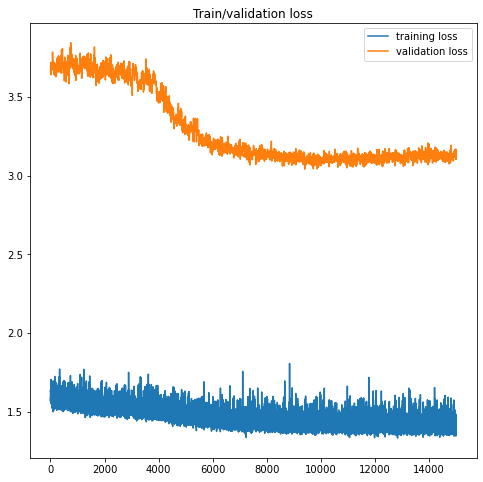

In [190]:
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
period = 500
batch_size = 116
filepath = "weights/fruit_prediction/val{val_loss:.3f}_train{loss:.3f}_ep{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, period= period)
callbacks_list = [checkpoint]

#from tensorflow.keras.utils import to_categorical
#y_train_bin = to_categorical(y_train)
#y_val_bin = to_categorical(y_val)
#y_test_bin = to_categorical(y_test)

#lr = .00001
#K.set_value(model.optimizer.lr, lr)
H = model.fit(x = train, y = y_train,
                validation_data = (val, y_val),
                epochs = 15000, batch_size = batch_size, callbacks = callbacks_list )

print(K.get_value(model.optimizer.lr))
plt.figure(figsize=(8,8))
plt.plot(H.history['loss'], label='training loss')
plt.plot(H.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Train/validation loss')
plt.show()

array([1., 3., 4., 3., 4., 3., 3., 3., 4., 1., 3., 3., 3., 3., 1., 4., 3.,
       3., 3., 4., 4., 3., 3., 4., 4., 1., 4., 4., 3., 4., 4., 4., 1., 0.,
       3., 0., 3., 4., 4., 3., 1., 3., 4., 1., 3., 4., 4., 4., 3., 4., 4.,
       4., 4., 3., 3., 0., 0., 1., 4., 4., 4., 4., 4., 3., 0., 1., 1., 3.,
       4., 4., 0., 3., 4., 4.])

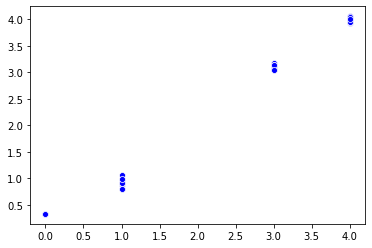

In [172]:
sns.scatterplot(y_train, [i[0] for i in model.predict(train)], color = "blue")
y_train


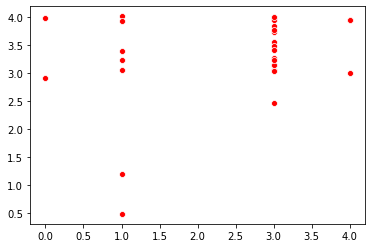

In [173]:
sns.scatterplot(y_val, [i[0] for i in model.predict(val)], color = "red")

In [333]:
y_test

array([3., 3., 1., 4., 4., 3., 0., 4., 0., 1., 4., 0., 3., 3., 3., 4., 1.,
       1., 4., 0., 4., 1., 1., 1.])

In [398]:
data = pd.concat([train, val])
def transformOrdinal(y):
    target = np.array([int(i) for i in y])
    new_target = []
    for i in target:
        if i == 3:
            new_target = new_target + [2]
        elif i == 4: 
            new_target = new_target + [3]
        else:
            new_target = new_target + [i]
    return(np.array(new_target))
        
new_target = transformOrdinal(np.concatenate([y_train, y_val]))
y_train_ord = transformOrdinal(y_train)
y_val_ord = transformOrdinal(y_val)
y_test_ord = transformOrdinal(y_test)

## Predictive power

In [820]:
def impute(mapping):
    for i in np.arange(mapping.shape[1]):
        mapping.iloc[:, i] = [float(j) for j in mapping.iloc[:, i]]
        nans = [math.isnan(j) for j in mapping.iloc[:, i]]
        imputed = np.nanmedian(mapping.iloc[:, i])
        mapping.iloc[:, i].loc[nans] = imputed
    return(mapping)

In [829]:

#One sample per person
data_16s_grouped = encoded_16s.groupby(map_16s.host_name).mean()
data_mtg_grouped = encoded_mtg.groupby(map_mtg.host_name).mean()
data_mtt_grouped = encoded_mtt.groupby(map_mtt.host_name).mean()


train, val, test, map_train, map_val, map_test = getEncodedData(data_16s_grouped, 
                                                          data_mtg_grouped, 
                                                          data_mtt_grouped, state = 1)
#y_train_ord = transformOrdinal(y_train)
#y_val_ord = transformOrdinal(y_val)
#y_test_ord = transformOrdinal(y_test)

137
True
Train size: (82, 300)
Train size: (28, 300)
Train size: (27, 300)


In [810]:

        
    return(mapping)
keep = np.concatenate([np.array([5,6]), np.array([12, 14]), np.arange(16, 37), np.arange(38, 41), np.arange(43,50)])
map_train_impute = impute(map_train.iloc[:, keep])
map_val_impute = impute(map_val.iloc[:, keep])
map_test_impute = impute(map_test.iloc[:, keep])

duplicated = ['meats_and_seafood', 'dairy_freq', 'vegetable_freq', 'fruit_freq']
map_train_impute = map_train_impute.drop(duplicated, axis = 1)
map_val_impute = map_val_impute.drop(duplicated, axis = 1)
map_test_impute = map_test_impute.drop(duplicated, axis = 1)
print(map_train_impute.shape)

(82, 31)


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [748]:
from sklearn.preprocessing import normalize
def buildDataset(map_train_impute, train):
    train_meta_16s = pd.concat([map_train_impute, train.iloc[:, 0:100]], axis = 1)
    train_meta_mtg = pd.concat([map_train_impute, train.iloc[:, 100:200]], axis = 1)
    train_meta_16s_mtg = pd.concat([map_train_impute, train.iloc[:, 0:200]], axis = 1)
    train_meta_mtt = pd.concat([map_train_impute, train.iloc[:, 200:300]], axis = 1)
    train_meta_all = pd.concat([map_train_impute, train], axis = 1)
    
    train_meta_16s = normalize(train_meta_16s)
    train_meta_mtg = normalize(train_meta_mtg)
    train_meta_16s_mtg = normalize(train_meta_16s_mtg)
    train_meta_mtt = normalize(train_meta_mtt)
    train_meta_all = normalize(train_meta_all)

    return(train_meta_16s, train_meta_mtg, train_meta_16s_mtg, train_meta_mtt, train_meta_all)

    

#y_train = [1 if i == 'A' else 0 for i in map_train.phenotype]
#y_val = [1 if i == 'A' else 0 for i in map_val.phenotype]
#y_test = [1 if i == 'A' else 0 for i in map_test.phenotype]

In [749]:
train_meta_16s, train_meta_mtg, train_meta_16s_mtg, train_meta_mtt, train_meta_all = buildDataset(map_train_impute, train)
val_meta_16s, val_meta_mtg, val_meta_16s_mtg, val_meta_mtt, val_meta_all = buildDataset(map_val_impute, val)
test_meta_16s, test_meta_mtg, test_meta_16s_mtg, test_meta_mtt, test_meta_all = buildDataset(map_test_impute, test)

map_train

In [725]:
alpha = .1
model_meta = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = alpha)
model_meta_16s = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = alpha)
model_meta_mtg = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = alpha)
model_meta_16s_mtg = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = alpha)
model_meta_mtt = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = alpha)
model_meta_all = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = alpha)

model_meta.fit(map_train_impute, y_train)
model_meta_16s.fit(train_meta_16s, y_train)
model_meta_mtg.fit(train_meta_mtg, y_train)
model_meta_16s_mtg.fit(train_meta_16s_mtg, y_train)
model_meta_mtt.fit(train_meta_mtt, y_train)
model_meta_all.fit(train_meta_all, y_train)

c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(l1_ratio=0.1, penalty='elasticnet', solver='saga')

In [727]:
def getAUC(model, data, y):
    probs = model.predict_proba(data, )
    probs = probs[:, 1]
    auc = roc_auc_score(y, probs)
    fpr, tpr, _ = roc_curve(y, probs)
    return(auc)

print("Train")
print(getAUC(model_meta, map_train_impute, y_train))
print(getAUC(model_meta_16s, train_meta_16s, y_train))
print(getAUC(model_meta_mtg, train_meta_mtg, y_train))
print(getAUC(model_meta_16s_mtg, train_meta_16s_mtg, y_train))
print(getAUC(model_meta_mtt, train_meta_mtt, y_train))
print(getAUC(model_meta_all, train_meta_all, y_train))

print("Val")
print(getAUC(model_meta, map_val_impute, y_val))
print(getAUC(model_meta_16s, val_meta_16s, y_val))
print(getAUC(model_meta_mtg, val_meta_mtg, y_val))
print(getAUC(model_meta_16s_mtg, val_meta_16s_mtg, y_val))
print(getAUC(model_meta_mtt, val_meta_mtt, y_val))
print(getAUC(model_meta_all, val_meta_all, y_val))

print("Test")
print(getAUC(model_meta, map_test_impute, y_test))
print(getAUC(model_meta_16s, test_meta_16s, y_test))
print(getAUC(model_meta_mtg, test_meta_mtg, y_test))
print(getAUC(model_meta_16s_mtg, test_meta_16s_mtg, y_test))
print(getAUC(model_meta_mtt, test_meta_mtt, y_test))
print(getAUC(model_meta_all, test_meta_all, y_test))


Train
0.9928571428571428
0.7827380952380952
0.6910714285714286
0.6904761904761906
0.7744047619047618
0.8279761904761904
Val
0.8112244897959184
0.5204081632653061
0.5918367346938775
0.5918367346938775
0.5102040816326531
0.5357142857142857
Test
0.6758241758241759
0.4285714285714286
0.5219780219780219
0.5219780219780219
0.5989010989010989
0.532967032967033


## Predicting fruit intake (todo: make ordinal)

c:\users\ctata\miniconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [838]:
#Concat mappings
mapping = pd.concat([map_train, map_val, map_test], axis = 0)
keep = np.concatenate([np.array([5,6]), np.array([12, 14]), np.arange(16, 37), np.arange(38, 41), np.arange(43,50)])
mapping = impute(mapping.iloc[:, keep])

duplicated = ['meats_and_seafood', 'dairy_freq', 'vegetable_freq', 'fruit']
mapping = mapping.drop(duplicated, axis = 1)

map_train_impute = mapping.iloc[0:map_train.shape[0], :]
map_val_impute = mapping.iloc[map_train.shape[0] : (map_train.shape[0] + map_val.shape[0]), :]
map_test_impute = mapping.iloc[(map_train.shape[0] + map_val.shape[0]) :, :]


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [839]:


def transformOrdinal(y):
    target = np.array([int(i) for i in y])
    new_target = []
    for i in target:
        if i == 3:
            new_target = new_target + [2]
        elif i == 4: 
            new_target = new_target + [3]
        else:
            new_target = new_target + [i]
    return(np.array(new_target))


y_train = map_train_impute.fruit_freq
map_train_fruit = map_train_impute.drop('fruit_freq', axis = 1)

y_val = map_val_impute.fruit_freq
map_val_fruit = map_val_impute.drop('fruit_freq', axis = 1)

y_test = map_test_impute.fruit_freq
map_test_fruit = map_test_impute.drop('fruit_freq', axis = 1)

y_train_ord = transformOrdinal(y_train)
y_val_ord = transformOrdinal(y_val)
y_test_ord = transformOrdinal(y_test)

train_meta_16s, train_meta_mtg, train_meta_16s_mtg, train_meta_mtt, train_meta_all = buildDataset(map_train_fruit, train)
val_meta_16s, val_meta_mtg, val_meta_16s_mtg, val_meta_mtt, val_meta_all = buildDataset(map_val_fruit, val)
test_meta_16s, test_meta_mtg, test_meta_16s_mtg, test_meta_mtt, test_meta_all = buildDataset(map_test_fruit, test)

In [842]:
Counter(y_train_ord)

Counter({1: 14, 2: 36, 3: 27, 0: 5})

In [843]:
from mord import LogisticAT

alpha = .5
model_meta = LogisticAT(alpha = alpha)
model_meta_16s = LogisticAT(alpha = alpha)
model_meta_mtg = LogisticAT(alpha = alpha)
model_meta_16s_mtg = LogisticAT(alpha = alpha)
model_meta_mtt = LogisticAT(alpha = alpha)
model_meta_all = LogisticAT(alpha = alpha)

model_meta.fit(map_train_fruit, y_train_ord)
model_meta_16s.fit(train_meta_16s, y_train_ord)
model_meta_mtg.fit(train_meta_mtg, y_train_ord)
model_meta_16s_mtg.fit(train_meta_16s_mtg, y_train_ord)
model_meta_mtt.fit(train_meta_mtt, y_train_ord)
model_meta_all.fit(train_meta_all, y_train_ord)

LogisticAT(alpha=0.5)

TRAINING
32
45
39
40
35


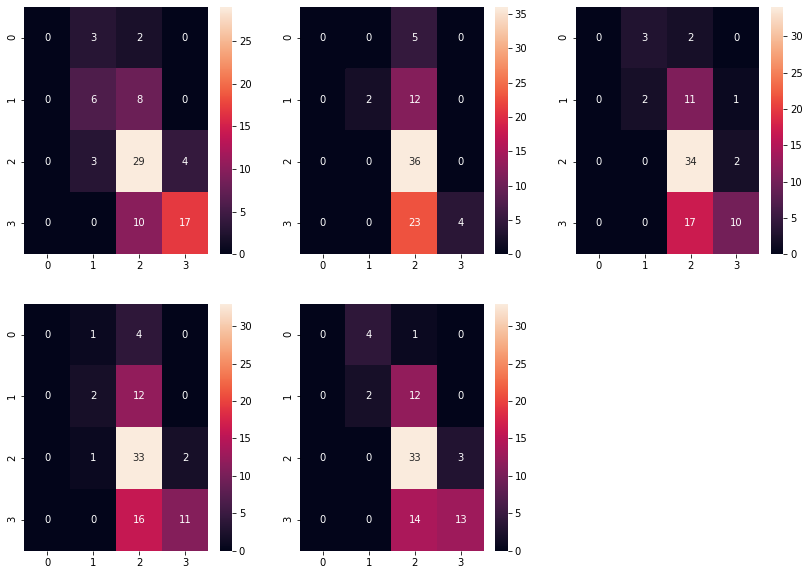

In [849]:
def getConfusionMatrix(model, data, y):
    preds = [round(i) for i in model.predict(data)]
    sns.heatmap(confusion_matrix(y, preds), annot = True)
    error = np.sum([np.abs(i - j) for i,j in zip(y, model.predict(data))])
    print(error)
    
print("TRAINING")
fig = plt.figure(figsize= (14, 7))

plt.subplot(2, 3, 1)
getConfusionMatrix(model_meta, map_train_fruit, y_train_ord)
plt.subplot(2, 3, 2)
getConfusionMatrix(model_meta_16s, train_meta_16s, y_train_ord)
plt.subplot(2, 3, 3)
getConfusionMatrix(model_meta_mtg, train_meta_mtg, y_train_ord)
plt.subplot(2, 3, 4)
getConfusionMatrix(model_meta_mtt, train_meta_mtt, y_train_ord)
plt.subplot(2, 3, 5)
getConfusionMatrix(model_meta_all, train_meta_all, y_train_ord)

Val
31
25
22
28
25


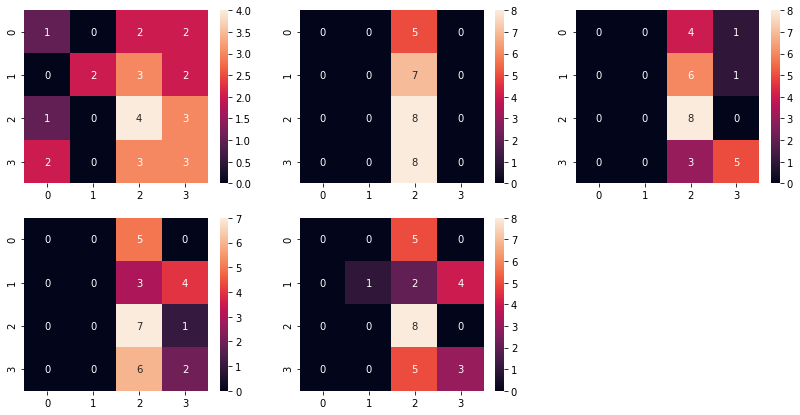

In [850]:
    
print("Val")
fig = plt.figure(figsize= (14, 7))

plt.subplot(2, 3, 1)
getConfusionMatrix(model_meta, map_val_fruit, y_val_ord)
plt.subplot(2, 3, 2)
getConfusionMatrix(model_meta_16s, val_meta_16s, y_val_ord)
plt.subplot(2, 3, 3)
getConfusionMatrix(model_meta_mtg, val_meta_mtg, y_val_ord)
plt.subplot(2, 3, 4)
getConfusionMatrix(model_meta_mtt, val_meta_mtt, y_val_ord)
plt.subplot(2, 3, 5)
getConfusionMatrix(model_meta_all, val_meta_all, y_val_ord)

Test
24
14
17
16
15


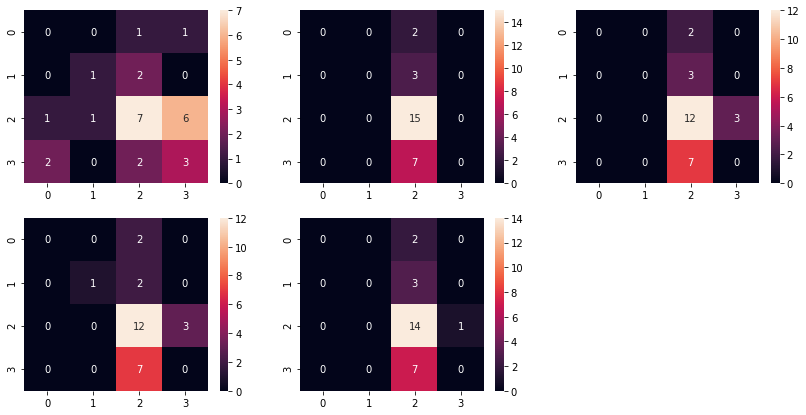

In [851]:
    
print("Test")
fig = plt.figure(figsize= (14, 7))

plt.subplot(2, 3, 1)
getConfusionMatrix(model_meta, map_test_fruit, y_test_ord)
plt.subplot(2, 3, 2)
getConfusionMatrix(model_meta_16s, test_meta_16s, y_test_ord)
plt.subplot(2, 3, 3)
getConfusionMatrix(model_meta_mtg, test_meta_mtg, y_test_ord)
plt.subplot(2, 3, 4)
getConfusionMatrix(model_meta_mtt, test_meta_mtt, y_test_ord)
plt.subplot(2, 3, 5)
getConfusionMatrix(model_meta_all, test_meta_all, y_test_ord)

In [782]:
def getError(model, data, y):
    preds = model.predict(data)
    return(np.sum([np.square(i - j) for i,j in zip(y, preds)]))

print("Train")
print(getError(model_meta, map_train_fruit, y_train))
print(getError(model_meta_16s, train_meta_16s, y_train))
print(getError(model_meta_mtg, train_meta_mtg, y_train))
print(getError(model_meta_16s_mtg, train_meta_16s_mtg, y_train))
print(getError(model_meta_mtt, train_meta_mtt, y_train))
print(getError(model_meta_all, train_meta_all, y_train))

print("Val")
print(getError(model_meta, map_val_fruit, y_val))
print(getError(model_meta_16s, val_meta_16s, y_val))
print(getError(model_meta_mtg, val_meta_mtg, y_val))
print(getError(model_meta_16s_mtg, val_meta_16s_mtg, y_val))
print(getError(model_meta_mtt, val_meta_mtt, y_val))
print(getError(model_meta_all, val_meta_all, y_val))

print("Test")
print(getError(model_meta, map_test_fruit, y_test))
print(getError(model_meta_16s, test_meta_16s, y_test))
print(getError(model_meta_mtg, test_meta_mtg, y_test))
print(getError(model_meta_16s_mtg, test_meta_16s_mtg, y_test))
print(getError(model_meta_mtt, test_meta_mtt, y_test))
print(getError(model_meta_all, test_meta_all, y_test))


Train
79.86451291007833
82.0
82.0
82.0
82.0
82.0
Val
26.33422971027412
27.999999999999996
27.999999999999996
27.999999999999996
27.999999999999996
27.999999999999996
Test
25.459594038859198
27.0
27.0
27.0
27.0
27.0


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 140 is different from 300)

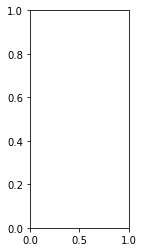

In [623]:
model = model_meta
plt.subplot(1, 3 , 1)
preds = [round(i) for i in model.predict(train)]
sns.heatmap(confusion_matrix(y_train, preds), annot = True)

plt.subplot(1, 3, 2)
preds_val = [round(i) for i in model.predict(val)]
sns.heatmap(confusion_matrix(y_val, preds_val), annot = True)

plt.subplot(1, 3, 3)
preds_test = [round(i) for i in model.predict(test)]
sns.heatmap(confusion_matrix(y_test, preds_test), annot = True)

22.511026740074158


,alpha,error
15,1000.0,2.000000
14,10000.0,7.000000
12,1000000.0,14.000000
11,4000000.0,15.000000
13,5000000.0,15.000000
7,1000000.0,19.000000
8,1500000.0,20.000000
9,2000000.0,20.000000
6,80000.0,22.000000
10,4000000.0,22.000000


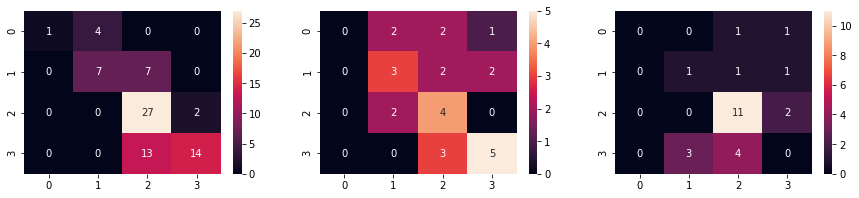

In [517]:
#sns.scatterplot(y_train_ord, model_ordinal.predict(train))

alpha = 10000000
model_ridge = linear_model.Ridge(alpha = alpha)
model_ordinal = LogisticAT(alpha = alpha)

model = model_ridge
model.fit(train, y_train_ord)

fig = plt.figure(figsize = (15, 3))
plt.subplot(1, 3 , 1)
preds = [round(i) for i in model.predict(train)]
sns.heatmap(confusion_matrix(y_train_ord, preds), annot = True)

plt.subplot(1, 3, 2)
preds_val = [round(i) for i in model.predict(val)]
sns.heatmap(confusion_matrix(y_val_ord, preds_val), annot = True)

plt.subplot(1, 3, 3)
preds_test = [round(i) for i in model.predict(test)]
sns.heatmap(confusion_matrix(y_test_ord, preds_test), annot = True)

error = np.sum([np.abs(i - j) for i,j in zip(y_val_ord, model.predict(val))])
res2 = res2.append({'alpha': alpha, 'error': error}, ignore_index = True)
print(error)
res2.sort_values('error')

In [519]:
data_16s_grouped = data_16s.groupby(map_16s.host_name).mean()
data_mtg_grouped = data_mtg.groupby(map_mtg.host_name).mean()
data_mtt_grouped = data_mtt.groupby(map_mtt.host_name).mean()
train, val, test, y_train, y_val, y_test = getEncodedData(data_16s_grouped, 
                                                          data_mtg_grouped, 
                                                          data_mtt_grouped, state = 1)

137
True
Train size: (82, 12933)
Train size: (28, 12933)
Train size: (27, 12933)


29.629279291906986


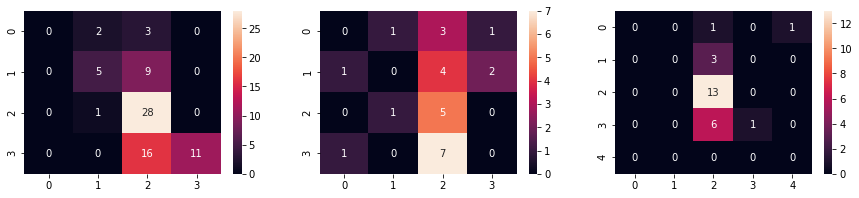

In [526]:
#sns.scatterplot(y_train_ord, model_ordinal.predict(train))

alpha = 10000000 * 1000
model_ridge = linear_model.Ridge(alpha = alpha)
model_ordinal = LogisticAT(alpha = alpha)

model = model_ridge
model.fit(train, y_train_ord)

fig = plt.figure(figsize = (15, 3))
plt.subplot(1, 3 , 1)
preds = [round(i) for i in model.predict(train)]
sns.heatmap(confusion_matrix(y_train_ord, preds), annot = True)

plt.subplot(1, 3, 2)
preds_val = [round(i) for i in model.predict(val)]
sns.heatmap(confusion_matrix(y_val_ord, preds_val), annot = True)

plt.subplot(1, 3, 3)
preds_test = [round(i) for i in model.predict(test)]
sns.heatmap(confusion_matrix(y_test_ord, preds_test), annot = True)

error = np.sum([np.abs(i - j) for i,j in zip(y_val_ord, model.predict(val))])
res2 = res2.append({'alpha': alpha, 'error': error}, ignore_index = True)
print(error)

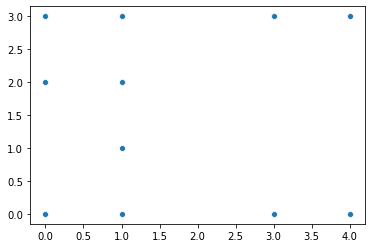

In [338]:
sns.scatterplot(y_test, model_ordinal.fit(data, new_target).predict(test))

In [278]:
#Linear regression classifier

train_error = []
val_error = []
alphas = [10, 100, 1000, 10000, 100000, 200000, 400000, 600000]
for alpha in alphas:
    lin_model = linear_model.Ridge(alpha = alpha).fit(train, y_train)
    #sns.scatterplot(y_train, lin_model.predict(train), color = "blue")
    train_error.append(np.sum([(i - j)*(i-j) for i,j in zip(np.array(y_train), lin_model.predict(train))]))
    val_error.append(np.sum([(i - j)*(i-j) for i,j in zip(np.array(y_val), lin_model.predict(val))]))

c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.43444e-09): result may not be accurate.
  overwrite_a=False)
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.36616e-08): result may not be accurate.
  overwrite_a=False)


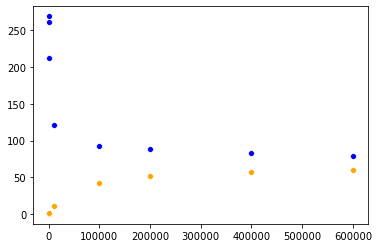

In [279]:
sns.scatterplot(alphas, train_error, color = 'orange')
sns.scatterplot(alphas, val_error, color = 'blue')

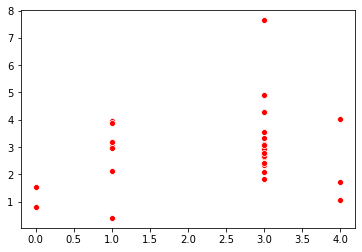

In [281]:
sns.scatterplot(y_val, lin_model.predict(val), color = "red")


77.44986534574196

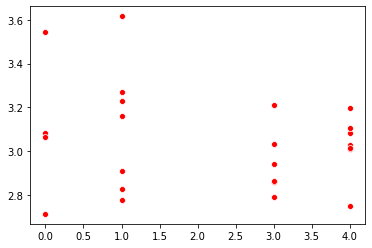

In [243]:
sns.scatterplot(y_test, lin_model.predict(test), color = "red")
np.sum([(i - j)*(i-j) for i,j in zip(np.array(y_test), lin_model.predict(test))])

In [72]:
#model = load_model("weights/phenotype_prediction/val0.727_train0.700_ep4000.hdf5")
probs = [i[0] for i in model.predict(train)]
auc = roc_auc_score(y_train_bin, probs)
fpr, tpr, _ = roc_curve(y_train_bin, probs)
print("Train AUC: " + str(auc))

probs = [i[0] for i in model.predict(val)]
auc = roc_auc_score(y_val_bin, probs)
fpr, tpr, _ = roc_curve(y_val_bin, probs)
print("Val AUC: " + str(auc))

probs = [i[0] for i in model.predict(test)]
auc = roc_auc_score(y_test_bin, probs)
fpr, tpr, _ = roc_curve(y_test_bin, probs)
print("Test AUC: " + str(auc))

ValueError: Expected 2D array, got 1D array instead:
array=[0.1238213  0.16960075 0.1395305  0.12533261 0.1317826  0.10393239
 0.13969186 0.1145157  0.1124787  0.05471594 0.00327227 0.22799228
 0.15664648 0.13264993 0.12086084 0.17976792 0.13146527 0.15501584
 0.15050927 0.12266059 0.01295319 0.13681865 0.13362564 0.11465648
 0.10991893 0.07720083 0.03064542 0.13831842 0.13256843 0.13948548
 0.09892607 0.04295729 0.13589965 0.01554332 0.12376375 0.13287084
 0.15700945 0.10766868 0.12328946 0.076015   0.14999898 0.14025734
 0.12998489 0.09165563 0.15292703 0.11334688 0.14596832 0.12206189
 0.13320634 0.12801962 0.15875798 0.03372045 0.10596536 0.1137818
 0.14011194 0.1447701  0.15892495 0.11259071 0.04322052 0.09214776
 0.04880985 0.13228503 0.13194755 0.13221844 0.10808746 0.14856428
 0.14007042 0.01543318 0.14149536 0.12960728 0.13223787 0.02630436
 0.16955245 0.1477757  0.10419177 0.129379   0.12359282 0.07890258].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [290]:
probs = [i[0] for i in model.predict(train)]
auc = roc_auc_score(y_train, probs)
fpr, tpr, _ = roc_curve(y_train, probs)
print("Train AUC: " + str(auc))
print(probs)

Train AUC: 0.7332112332112332
[0.5247339, 0.5240886, 0.5026248, 0.51559836, 0.5228895, 0.52525115, 0.50733227, 0.51705027, 0.5156839, 0.47961667, 0.50852555, 0.51981485, 0.5186865, 0.52518564, 0.5195027, 0.5269901, 0.52021635, 0.52472776, 0.52478147, 0.50056887, 0.52160424, 0.48130053, 0.52266186, 0.5203322, 0.5197992, 0.49331382, 0.52132976, 0.52757233, 0.52307373, 0.4994658, 0.52156615, 0.5090067, 0.51785827, 0.48722142, 0.5212464, 0.5179599, 0.5266217, 0.5242108, 0.5224334, 0.5138607, 0.5115382, 0.5280646, 0.52074325, 0.5275774, 0.50777614, 0.51242626, 0.47190517, 0.52517354, 0.5282251, 0.52435946, 0.51644254, 0.5013229, 0.5051355, 0.51960194, 0.51873326, 0.41182232, 0.51381356, 0.51144826, 0.5045692, 0.51523167, 0.5087941, 0.49231833, 0.5206932, 0.5259653, 0.5160421, 0.43475723, 0.5253503, 0.4680472, 0.5141835, 0.51689774, 0.5256946, 0.52562886, 0.3037651, 0.52702785, 0.47006074, 0.52283293, 0.5129785, 0.5163501, 0.47113132, 0.52384806, 0.4784181]


In [14]:
def trainRandomForestModel(max_depth, n_estimators, train, y_train, val, y_val):
    clf=RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)
    clf.fit(train, y_train)

    probs = clf.predict_proba(train, )
    probs = probs[:, 1]
    train_auc = roc_auc_score(y_train, probs)
    fpr, tpr, _ = roc_curve(y_train, probs)
    #print("Train AUC: " + str(train_auc))


    probs = clf.predict_proba(val, )
    probs = probs[:, 1]
    val_auc = roc_auc_score(y_val, probs)
    fpr, tpr, _ = roc_curve(y_val, probs)
    #print("Test AUC: " + str(val_auc))
    #print("")
    
    return(train_auc, val_auc, clf)

In [15]:
from sklearn.ensemble import RandomForestClassifier
print(train.shape)

tmp_results = pd.DataFrame()
results = pd.DataFrame()
best_models = []
val_auc_best = 0
clf_best = None
depths = [2, 4, 6, 8, 10, 15, 20]
n_estimators = [ 200, 500, 1000, 1500, 2000, 2500, 3000]
for max_depth in depths:
    for n_est in n_estimators:
        for i in range(100):
            train_auc, val_auc, clf = trainRandomForestModel(max_depth, n_est,  train, y_train, val, y_val)
       
            tmp_results = tmp_results.append({'max_depth': max_depth, 'n_trees': n_est, 'train_perf': train_auc, 'val_perf': val_auc}, ignore_index = True)
        results.append(tmp_results.groupby('max_depth').mean(), ignore_index = True)

(79, 300)


KeyboardInterrupt: 

In [309]:
pd.set_option('display.max_rows', None)
print(tmp_results.groupby(['max_depth', 'n_trees']).mean())

                   train_perf  val_perf
max_depth n_trees                      
2.0       2.0        0.729570  0.522755
          5.0        0.839857  0.519133
          10.0       0.916300  0.517653
          20.0       0.970891  0.554949
          40.0       0.993602  0.556020
          60.0       0.998333  0.584388
          80.0       0.999341  0.576633
          100.0      0.999640  0.591276
          200.0      0.999976  0.621429
          500.0      1.000000  0.636173
          1000.0     1.000000  0.634847
4.0       2.0        0.862030  0.504872
          5.0        0.957390  0.519796
          10.0       0.991700  0.551097
          20.0       0.999438  0.540306
          40.0       1.000000  0.573112
          60.0       1.000000  0.584133
          80.0       1.000000  0.607194
          100.0      1.000000  0.587602
          200.0      1.000000  0.615510
          500.0      1.000000  0.638214
          1000.0     1.000000  0.643112
6.0       2.0        0.892799  0.512653


In [5]:
res = pd.read_csv("../../output/df_randomForest2.csv")
res.groupby(['max_depth', 'n_trees']).mean()

train_perf  val_perf
max_depth n_trees                      
2.0       200.0      0.999983  0.522556
          500.0      1.000000  0.513944
          1000.0     1.000000  0.518833
          1500.0     1.000000  0.519889
          2000.0     1.000000  0.517722
          2500.0     1.000000  0.521444
          3000.0     1.000000  0.523222
4.0       200.0      1.000000  0.538056
          500.0      1.000000  0.527944
          1000.0     1.000000  0.534333
          1500.0     1.000000  0.532389
          2000.0     1.000000  0.536833
          2500.0     1.000000  0.539389
          3000.0     1.000000  0.537722
6.0       200.0      1.000000  0.530778
          500.0      1.000000  0.541389
          1000.0     1.000000  0.540389
          1500.0     1.000000  0.537167
          2000.0     1.000000  0.540667
          2500.0     1.000000  0.541167
          3000.0     1.000000  0.541944
8.0       200.0      1.000000  0.543167
          500.0      1.000000  0.546750
          1000.0     1.000000  0.543667
          1500.0     1.000000  0.542056
          2000.0     1.000000  0.543056
          2500.0     1.000000  0.541833
          3000.0     1.000000  0.543667
10.0      200.0      1.000000  0.536444
          500.0      1.000000  0.543500
          1000.0     1.000000  0.540639
          1500.0     1.000000  0.539194
          2000.0     1.000000  0.542417
          2500.0     1.000000  0.539444
          3000.0     1.000000  0.540917
15.0      200.0      1.000000  0.535083
          500.0      1.000000  0.540333
          1000.0     1.000000  0.539583
          1500.0     1.000000  0.540139
          2000.0     1.000000  0.541694
          2500.0     1.000000  0.542889
          3000.0     1.000000  0.543361
20.0      200.0      1.000000  0.536750
          500.0      1.000000  0.538111
          1000.0     1.000000  0.540972
          1500.0     1.000000  0.541222
          2000.0     1.000000  0.540500
          2500.0     1.000000  0.539583
          3000.0     1.000000  0.542361

In [179]:

probs = clf_best.predict_proba(test, )
probs = probs[:, 1]
test_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
print("Test AUC: " + str(test_auc))
print("")

Test AUC: 0.5765306122448979



In [130]:
mtg_map.columns

Index(['biospecimen_id', 'biospecimen_name', 'host_name', 'timepoint',
       'familyID', 'dog', 'cat', 'min_time_antibiotics', 'stool_freq',
       'csection', 'racial_group', 'specific_food_allergy',
       'GI_issues_this_week', 'other_GI_symptoms', 'sex', 'gluten_allergy',
       'nonceliac_sensitivity', 'whole_grain', 'fermented_vegetables', 'dairy',
       'fruit', 'meal_home_prep', 'meal_ready_eat', 'meat', 'olive_oil',
       'seafood', 'sweetened_drink', 'vegetable', 'restaurant', 'sugary_food',
       'infant_diet', 'lactose_intolerance', 'age', 'multivitamin',
       'prematurely_born', 'probiotic', 'dietary_restriction', 'env_tobacco',
       'dietary_supplement', 'vitamin_B', 'vitamin_D', 'diarrhea',
       'constipation', 'starchy_food', 'meats_and_seafood', 'bread',
       'dairy_freq', 'fat_oil_freq', 'vegetable_freq', 'fruit_freq',
       'father_age', 'mother_age', 'recently_ill', 'MARA', 'phenotype'],
      dtype='object')

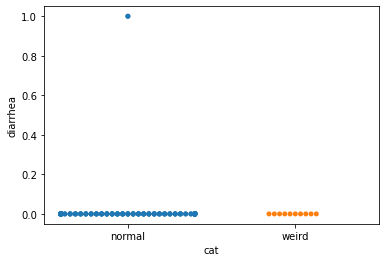

In [166]:
sns.swarmplot(x = "cat", y = "diarrhea", data = mtg_map,  orient = "v")

In [47]:
pred = autoencoder.predict(np.array(use))
rho, pval = pearsonr(pred, np.array(use))
rho_base, pval_base = spearmanr(np.array(x_val), np.array(x_val), axis = 1)

TypeError: No loop matching the specified signature and casting was found for ufunc add

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,1.000000,0.890333,0.970045,0.817507,0.833300,0.813167,0.900652,0.852455,0.932512,0.828589,...,0.779884,0.796419,0.770298,0.872713,0.797541,0.827730,0.884502,0.787297,0.894457,0.845637
1,0.890333,1.000000,0.880766,0.918882,0.909204,0.899160,0.911115,0.924907,0.853343,0.906966,...,0.897603,0.884085,0.898661,0.933311,0.920492,0.871776,0.811693,0.870553,0.929479,0.909776
2,0.970045,0.880766,1.000000,0.806964,0.816535,0.811323,0.891939,0.843783,0.912327,0.843600,...,0.782988,0.798819,0.770660,0.869764,0.790738,0.796315,0.866643,0.743322,0.878841,0.816678
3,0.817507,0.918882,0.806964,1.000000,0.919966,0.917011,0.872767,0.913290,0.788711,0.892583,...,0.907040,0.887346,0.912518,0.911585,0.936972,0.852586,0.742204,0.880233,0.895054,0.881640
4,0.833300,0.909204,0.816535,0.919966,1.000000,0.917113,0.879498,0.901774,0.804490,0.871691,...,0.886887,0.871756,0.890101,0.904889,0.915212,0.851543,0.762417,0.869053,0.905794,0.875380
5,0.813167,0.899160,0.811323,0.917011,0.917113,1.000000,0.873609,0.909416,0.772830,0.872938,...,0.901520,0.891602,0.898410,0.904146,0.920517,0.845278,0.739844,0.856257,0.878348,0.851645
6,0.900652,0.911115,0.891939,0.872767,0.879498,0.873609,1.000000,0.903488,0.879831,0.867565,...,0.859177,0.868095,0.841158,0.917186,0.870739,0.867623,0.855150,0.829521,0.919016,0.867889
7,0.852455,0.924907,0.843783,0.913290,0.901774,0.909416,0.903488,1.000000,0.823327,0.889041,...,0.913122,0.897692,0.904099,0.914970,0.915669,0.878085,0.803415,0.866723,0.904078,0.877998
8,0.932512,0.853343,0.912327,0.788711,0.804490,0.772830,0.879831,0.823327,1.000000,0.804550,...,0.749167,0.783683,0.761977,0.856973,0.776159,0.832334,0.908983,0.794388,0.880848,0.841881
9,0.828589,0.906966,0.843600,0.892583,0.871691,0.872938,0.867565,0.889041,0.804550,1.000000,...,0.889941,0.871656,0.876403,0.897450,0.884988,0.823252,0.760684,0.801021,0.882794,0.845317


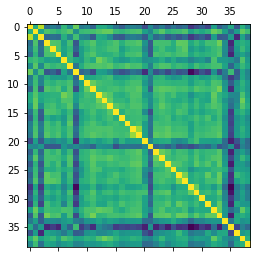

In [38]:
corr_df = pd.DataFrame(rho_base[0:x_train.shape[0], x_train.shape[0]:2*x_val.shape[0]])
plt.matshow(corr_df)
corr_df
#should be perfect correlation

0.6838305779689996


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.624878,0.657400,0.613326,0.661896,0.650567,0.646363,0.644874,0.656998,0.606024,0.632031,...,0.642260,0.641247,0.645991,0.653806,0.656032,0.634465,0.585745,0.638541,0.650224,0.638080
1,0.668757,0.720609,0.664189,0.721743,0.709404,0.713820,0.706798,0.717050,0.649199,0.699449,...,0.711849,0.706730,0.711430,0.717834,0.721119,0.684369,0.621341,0.687046,0.711589,0.691117
2,0.660488,0.702811,0.664512,0.711394,0.696016,0.700844,0.687812,0.700988,0.635598,0.686083,...,0.694728,0.690621,0.690047,0.700353,0.703251,0.658850,0.605004,0.662859,0.693392,0.667388
3,0.658039,0.698139,0.655198,0.708165,0.693608,0.699345,0.688497,0.698624,0.635995,0.678910,...,0.688149,0.686711,0.689955,0.698006,0.699198,0.663348,0.609468,0.671352,0.689950,0.667473
4,0.675342,0.714273,0.669410,0.721882,0.718183,0.718462,0.708450,0.712789,0.651236,0.692171,...,0.706043,0.702184,0.702780,0.717694,0.720794,0.680552,0.623118,0.689192,0.712265,0.685739
5,0.662888,0.700380,0.663906,0.708345,0.701074,0.707259,0.692889,0.698223,0.632998,0.681488,...,0.691477,0.689077,0.688714,0.704374,0.706102,0.659996,0.604654,0.667081,0.696334,0.666319
6,0.656895,0.705506,0.646151,0.708662,0.697576,0.700395,0.693661,0.704512,0.639793,0.675955,...,0.694772,0.689557,0.696856,0.703572,0.708712,0.676461,0.614333,0.686695,0.700448,0.679384
7,0.668830,0.718507,0.663879,0.721179,0.710082,0.713721,0.705120,0.718804,0.649624,0.696685,...,0.711219,0.702735,0.712820,0.715229,0.719389,0.684651,0.619406,0.689096,0.709259,0.687164
8,0.657642,0.685415,0.636412,0.685678,0.677343,0.672858,0.677359,0.683240,0.652919,0.645572,...,0.661804,0.666340,0.673184,0.681971,0.682628,0.674235,0.629569,0.687329,0.680140,0.676340
9,0.598039,0.650452,0.614648,0.655407,0.632062,0.642462,0.628239,0.638500,0.583457,0.659037,...,0.645706,0.642171,0.651653,0.649326,0.649370,0.590189,0.564419,0.598144,0.638942,0.613096


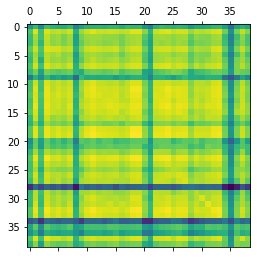

In [43]:
#Get samples in pred correlation with corresponding samples in x_val
#if we're learning well, we should have very high correlation between same samples
corr_df = pd.DataFrame(rho[0:pred.shape[0], pred.shape[0]:2*pred.shape[0]])
print(np.mean(corr_df.mean()))
plt.matshow(corr_df)
corr_df

In [120]:
print(pred.shape)
print(rho.shape)
corrs = []
for i in np.arange(pred.shape[0]):
    corr, pval = spearmanr(pred[i, :], np.array(x_val.iloc[i, :]))
    corrs = corrs + [corr]
print(corrs)
pd.DataFrame(rho)

(5, 5714)
(10, 10)
[0.640979841977111, 0.7339812685652771, 0.6566357352925403, 0.7215636216666738, 0.7177418986615736]


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.910001,0.934328,0.953284,0.892430,0.640980,0.700849,0.637515,0.694894,0.685759
1,0.910001,1.000000,0.926616,0.941203,0.934410,0.664085,0.733981,0.660550,0.734905,0.721610
2,0.934328,0.926616,1.000000,0.960288,0.949413,0.659087,0.722270,0.656636,0.720929,0.710318
3,0.953284,0.941203,0.960288,1.000000,0.936186,0.659656,0.724040,0.656271,0.721564,0.710726
4,0.892430,0.934410,0.949413,0.936186,1.000000,0.664202,0.728782,0.661213,0.730800,0.717742
5,0.640980,0.664085,0.659087,0.659656,0.664202,1.000000,0.890333,0.970045,0.817507,0.833300
6,0.700849,0.733981,0.722270,0.724040,0.728782,0.890333,1.000000,0.880766,0.918882,0.909204
7,0.637515,0.660550,0.656636,0.656271,0.661213,0.970045,0.880766,1.000000,0.806964,0.816535
8,0.694894,0.734905,0.720929,0.721564,0.730800,0.817507,0.918882,0.806964,1.000000,0.919966
9,0.685759,0.721610,0.710318,0.710726,0.717742,0.833300,0.909204,0.816535,0.919966,1.000000


In [114]:
corrs = []
for i in np.arange(pred.shape[0]):
    corr, pval = spearmanr(pred[i, :], np.array(x_val.iloc[i, :]))
    corrs = corrs + [corr]
print(corrs)

corr2, pvals = spearmanr(pred, np.array(x_val.iloc[0:5, :]), axis = 1)
print(pred.shape)
pd.DataFrame(corr2)

[0.640979841977111, 0.7339812685652771, 0.6566357352925403, 0.7215636216666738, 0.7177418986615736, 0.7050356701776814, 0.6979751868273045, 0.7333096066980002, 0.6066055641271839, 0.6902274482444634]
(10, 5714)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,0.910001,0.934328,0.953284,0.892430,0.875704,0.905041,0.933825,0.860160,0.891006,0.640980,0.700849,0.637515,0.694894,0.685759
1,0.910001,1.000000,0.926616,0.941203,0.934410,0.906142,0.947901,0.955926,0.882629,0.913283,0.664085,0.733981,0.660550,0.734905,0.721610
2,0.934328,0.926616,1.000000,0.960288,0.949413,0.941362,0.901040,0.957720,0.809922,0.927472,0.659087,0.722270,0.656636,0.720929,0.710318
3,0.953284,0.941203,0.960288,1.000000,0.936186,0.917901,0.927825,0.962896,0.849920,0.922572,0.659656,0.724040,0.656271,0.721564,0.710726
4,0.892430,0.934410,0.949413,0.936186,1.000000,0.966724,0.911766,0.955326,0.809335,0.919584,0.664202,0.728782,0.661213,0.730800,0.717742
5,0.875704,0.906142,0.941362,0.917901,0.966724,1.000000,0.891383,0.933353,0.777506,0.905796,0.652504,0.715718,0.649832,0.716202,0.704099
6,0.905041,0.947901,0.901040,0.927825,0.911766,0.891383,1.000000,0.941457,0.903386,0.892841,0.656147,0.723107,0.651590,0.719512,0.709123
7,0.933825,0.955926,0.957720,0.962896,0.955326,0.933353,0.941457,1.000000,0.858260,0.922587,0.668937,0.737605,0.666278,0.738549,0.724482
8,0.860160,0.882629,0.809922,0.849920,0.809335,0.777506,0.903386,0.858260,1.000000,0.803575,0.610415,0.667469,0.602765,0.658602,0.653684
9,0.891006,0.913283,0.927472,0.922572,0.919584,0.905796,0.892841,0.922587,0.803575,1.000000,0.647303,0.708010,0.647130,0.709179,0.700648


In [ ]:
#Reformat
def reformat(data):
    data = np.array(data)
    return(np.reshape(data, (len(data), data.shape[1], 1)))

In [ ]:
def fitModel(x_train, y_train, x_val, y_val, embedding_size = 64, batch_size = 10, epochs = 50, lr = .0001, period = 20):
    
    input_shape = (x_train[0, :].shape[0], 1)
    base_network = create_base_network(input_shape, embedding_size)
    input_data = Input(shape=input_shape, name='input_data') # input layer for images
    input_labels = Input(shape=(1,), name='input_label')    # input layer for labels
    embeddings = base_network([input_data])      # output of network -> embeddings
    print(embeddings)
    labels_plus_embeddings = concatenate([input_labels, embeddings])  # concatenating the labels + embeddings

    # Defining a model with inputs (images, labels) and outputs (labels_plus_embeddings)
    model = Model(inputs=[input_data, input_labels],
                  outputs=labels_plus_embeddings)
    model.summary()

    opt = Adam(lr=lr)  # choose optimiser. RMS is good too!

    model.compile(loss=triplet_loss_adapted_from_tf,
                  optimizer=opt)

    filepath = "weights/testing_ep{epoch:02d}_BS%d.hdf5" % batch_size
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, period= period)
    callbacks_list = [checkpoint]

    # Uses 'dummy' embeddings + dummy gt labels. Will be removed as soon as loaded, to free memory
    dummy_gt_train = np.zeros((len(x_train), embedding_size + 1))
    dummy_gt_val = np.zeros((len(x_val), embedding_size + 1))


    H = model.fit(
        x=[np.array(x_train), np.array(y_train)],
        y=dummy_gt_train, 
        epochs= epochs, batch_size= batch_size,
        validation_data=([np.array(x_val), np.array(y_val)], dummy_gt_val),
        callbacks=callbacks_list)

    plt.figure(figsize=(8,8))
    plt.plot(H.history['loss'], label='training loss')
    plt.plot(H.history['val_loss'], label='validation loss')
    plt.legend()
    plt.title('Train/validation loss')
    plt.show()
    return(model)

In [252]:
model = load_model("weights/autoencoder/testing_ep1678_BS20.hdf5")
print(model.summary())
print(model.get_weights())
model.fit(np.array(x_train), np.array(x_train),
                validation_data = (np.array(x_val), np.array(x_val)),
                epochs = 10, batch_size = 20)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 5714)]            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5714)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              5715000   
_________________________________________________________________
dense_11 (Dense)             (None, 100)               100100    
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              101000    
_________________________________________________________________
dense_13 (Dense)             (None, 5714)              5719714   
Total params: 11,635,814
Trainable params: 11,635,814
Non-trainable params: 0
______________________________________________

116/116 [==============================] - 1s 6ms/sample - loss: 2.6621 - val_loss: 3.5644
Epoch 2/10
116/116 [==============================] - 0s 4ms/sample - loss: 2.6621 - val_loss: 3.5665
Epoch 3/10
116/116 [==============================] - 1s 9ms/sample - loss: 2.6619 - val_loss: 3.5651
Epoch 4/10
116/116 [==============================] - 1s 7ms/sample - loss: 2.6620 - val_loss: 3.5638
Epoch 5/10
116/116 [==============================] - 0s 4ms/sample - loss: 2.6621 - val_loss: 3.5655
Epoch 6/10
116/116 [==============================] - 1s 5ms/sample - loss: 2.6619 - val_loss: 3.5637
Epoch 7/10
116/116 [==============================] - 1s 5ms/sample - loss: 2.6621 - val_loss: 3.5659
Epoch 8/10
 80/116 [===================>..........] - ETA: 0s - loss: 2.6088

KeyboardInterrupt: 

In [240]:
epochs = 20
weights_file = "weights/autoencoder/testing_ep20_BS20.hdf5"
input_shape = x_train.shape[1]
embedding_size = 100
batch_size = 20
period = 10
initial_epoch = 0


#load existing weights
if not weights_file == "":
	autoencoder_tmp.load_weights(weights_file)
	initial_epoch = int(weights_file.split('_')[1][2:])

autoencoder_tmp.compile(optimizer = Adam(lr), loss = 'mean_squared_logarithmic_error')



#train model

H = autoencoder_tmp.fit(np.array(x_train), np.array(x_train),
                validation_data = (np.array(x_val), np.array(x_val)),
                epochs = epochs, batch_size = batch_size, initial_epoch = initial_epoch)


Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 5714)]            0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 5714)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 1000)              5715000   
_________________________________________________________________
dense_51 (Dense)             (None, 100)               100100    
_________________________________________________________________
dense_52 (Dense)             (None, 1000)              101000    
_________________________________________________________________
dense_53 (Dense)             (None, 5714)              5719714   
Total params: 11,635,814
Trainable params: 11,635,814
Non-trainable params: 0
______________________________________________

In [ ]:
corrs_base_pearson = np.zeros((use.shape[0], use.shape[0]))
for i in np.arange(use.shape[0]):
    for j in np.arange(use.shape[0]):
        corrs_base_pearson[i,j] = pearsonr(np.array(use)[i, :], np.array(use)[j, :])[0]